# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [30]:
import subprocess
import sys

def run_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()
    print(output.decode('utf-8'))
    print(error.decode('utf-8'), file=sys.stderr)

# Install required packages
run_command(f"{sys.executable} -m pip install -q swig")
run_command(f"{sys.executable} -m pip install box2d==2.3.2 'gym[box2d]==0.25.2' box2d-py pyvirtualdisplay tqdm numpy==1.22.4 matplotlib")
run_command(f"{sys.executable} -m pip install box2d==2.3.2 box2d-kengz")
run_command(f"{sys.executable} -m pip install torch")
run_command(f"{sys.executable} -m pip freeze > requirements.txt")

# Print installed packages for verification
run_command(f"{sys.executable} -m pip list")

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable



You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable



You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)



You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.



Package                 Version
----------------------- ---------
absl-py                 1.4.0
altgraph                0.17.2
appnope                 0.1.3
asttokens               2.4.1
Box2D                   2.3.2
Box2D-kengz             2.3.3
box2d-py                2.3.5
cachetools              5.3.1
certifi                 2023.7.22
charset-normalizer      3.2.0
cloudpickle             3.1.0
comm                    0.2.0
contourpy               1.2.1
cycler                  0.12.1
debugpy                 1.8.0
decorator               5.1.1
exceptiongroup          1.1.3
executing               2.0.1
filelock                3.16.1
fonttools               4.54.1
fsspec                  2024.10.0
future                  0.18.2
google-auth             2.22.0
google-auth-oauthlib    1.0.0
grpcio                  1.56.2
gym                     0.25.2
gym-notices             0.0.8
idna                    3.4
importlib-metadata      6.8.0
importlib_resources     6.4.5
ipykernel           

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.




Next, set up virtual display，and import all necessaary packages.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
from gym.wrappers import StepAPICompatibility
from tqdm import tqdm

print("Imports completed successfully")

Imports completed successfully


# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [33]:
seed = 2023
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [34]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
env = StepAPICompatibility(env, new_step_api=True)
fix(env, seed)

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [35]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
observation, reward, done, info = env.step(random_action)

In [ ]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [ ]:
print(reward)

-1.4981841929643156


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

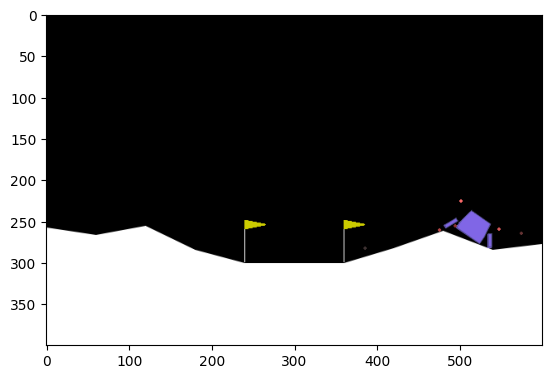

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Network & Agent
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)

# Value Network
class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(8, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [ ]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)
        self.scheduler = StepLR(self.optimizer, step_size=1000, gamma=0.9)
        self.rewards = None
        self.discounted_rewards = None

    def forward(self, state):
        return self.network(state)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def learn_A2C(self, log_probs, rewards, states, value_func):
        with torch.no_grad():
            values = value_func(states).squeeze()
        advantages = rewards - values
        loss = (-log_probs * advantages).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

## **Policy gradient**

In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the agent every 5 episodes
NUM_BATCH = 500        # totally update the agent for 500 episodes
gamma = 0.99            # Discount factor

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):

        state = env.reset()
        total_reward, total_step = 0, 0
        episode_rewards = []  # Store episode-specific rewards

        while True:
            action, log_prob = agent.sample(state)  # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)  # Store log probability
            episode_rewards.append(reward)  # Store immediate reward
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

        # Convert episode rewards to discounted cumulative rewards
        discounted_rewards = []
        cumulative_reward = 0

        # Compute cumulative decaying rewards for the episode
        for r in reversed(episode_rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)  # Insert at the front to keep the right order

        rewards.extend(discounted_rewards)  # Extend the rewards list with the episode's discounted rewards

    print(f"Rewards shape: {np.shape(rewards)}")

    # Record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Update the agent using cumulative decaying rewards
    rewards = np.array(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # Normalize the rewards
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

    # Print shapes for debugging
    print("Log probs size: ", torch.stack(log_probs).size())
    print("Rewards size: ", torch.from_numpy(rewards).size())

    # Print the AVG total reward achieved so far
    print(f"AVG Total Reward so far: {avg_total_reward:.2f}")


## **Actor Critic**

In [ ]:
# Actor
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

# Value
value_func = ValueNet()
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.0005)

agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the agent every 5 episodes
NUM_BATCH = 100         # totally update the agent for 500 episodes
gamma = 0.99           # Discount factor

avg_total_rewards, avg_final_rewards = [], []
vf_losses = []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    states = []

    # 收集轨迹
    for episode in range(EPISODE_PER_BATCH):

        state = env.reset()
        total_reward, total_step = 0, 0
        episode_rewards = []       # 存储每个episode的奖励
        episode_states = []        # 存储每个episode的状态
        episode_log_probs = []     # 存储每个episode的log概率

        while True:
            episode_states.append(state)  # 收集状态
            action, log_prob = agent.sample(state)  # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            episode_log_probs.append(log_prob)  # 存储log概率
            episode_rewards.append(reward)      # 存储即时奖励
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

        # 将每个episode的奖励转换为折扣累计奖励
        discounted_rewards = []
        cumulative_reward = 0

        # 计算每个episode的累计折扣奖励
        for r in reversed(episode_rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)  # 在前面插入以保持正确顺序

        # 将每个episode的数据扩展到主列表
        rewards.extend(discounted_rewards)
        log_probs.extend(episode_log_probs)
        states.extend(episode_states)

    # 记录训练过程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 准备张量
    states = torch.FloatTensor(states)
    rewards = np.array(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 归一化奖励
    rewards = torch.FloatTensor(rewards)

    # 更新价值函数
    opt1.zero_grad()
    values = value_func(states).squeeze()
    vf_loss = F.mse_loss(values, rewards, reduction='sum')
    vf_loss.backward()
    opt1.step()

    vf_losses.append(vf_loss.item())

    # 使用优势Actor-Critic（A2C）更新策略网络
    log_probs = torch.stack(log_probs)
    agent.learn_A2C(log_probs, rewards, states, value_func)


    # 打印调试信息
    print("States size: ", states.size())
    print("Values size: ", values.size())
    print("Log probs size: ", log_probs.size())
    print("Rewards size: ", rewards.size())

    # 打印到目前为止的平均总奖励
    print(f"AVG Total Reward so far: {np.mean(avg_total_rewards):.2f}")



  0%|          | 0/100 [00:00<?, ?it/s]

States size:  torch.Size([431, 8])
Values size:  torch.Size([431])
Log probs size:  torch.Size([431])
Rewards size:  torch.Size([431])
AVG Total Reward so far: -259.08
States size:  torch.Size([418, 8])
Values size:  torch.Size([418])
Log probs size:  torch.Size([418])
Rewards size:  torch.Size([418])
AVG Total Reward so far: -246.13
States size:  torch.Size([398, 8])
Values size:  torch.Size([398])
Log probs size:  torch.Size([398])
Rewards size:  torch.Size([398])
AVG Total Reward so far: -231.52
States size:  torch.Size([454, 8])
Values size:  torch.Size([454])
Log probs size:  torch.Size([454])
Rewards size:  torch.Size([454])
AVG Total Reward so far: -237.59
States size:  torch.Size([479, 8])
Values size:  torch.Size([479])
Log probs size:  torch.Size([479])
Rewards size:  torch.Size([479])
AVG Total Reward so far: -208.97
States size:  torch.Size([515, 8])
Values size:  torch.Size([515])
Log probs size:  torch.Size([515])
Rewards size:  torch.Size([515])
AVG Total Reward so far: 

## **Training Result**
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


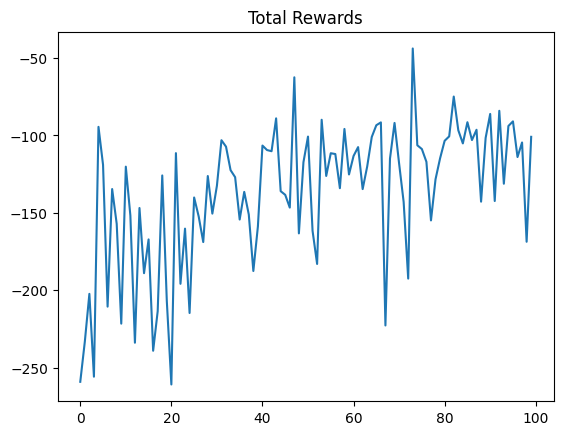

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


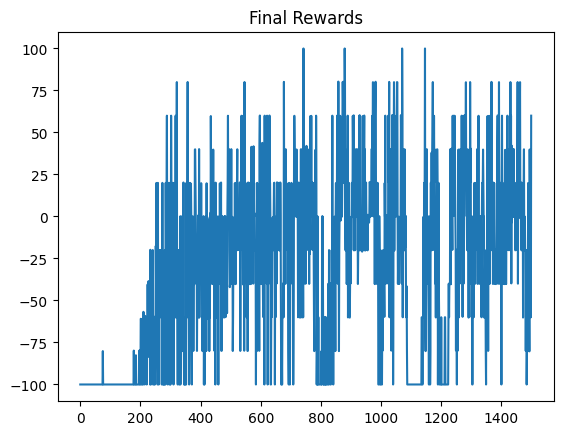

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

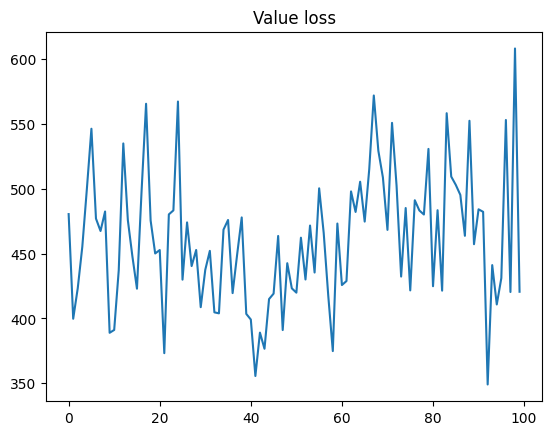

In [ ]:
plt.plot(vf_losses)
plt.title("Value loss")
plt.show()

## **DQN**
https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/01-dqn.ipynb

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(8, hidden_dim)
        self.output = nn.Linear(hidden_dim, 4)
    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

In [37]:
q_model = QNet().to(device)
q_target_model = QNet().to(device)
q_target_model.load_state_dict(q_model.state_dict()) #
_ = q_target_model.requires_grad_(False)  # target q-network doen't need grad

In [38]:
# Reply buffer
class ReplayMemory:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, sample_size):
        items = random.sample(self.buffer, sample_size)
        states = [i[0] for i in items]
        actions = [i[1] for i in items]
        rewards = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones = [i[4] for i in items]

        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        n_states = torch.tensor(n_states, dtype=torch.float).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device)

        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

memory = ReplayMemory(buffer_size=10000)

In [39]:
gamma = 0.99

opt = torch.optim.Adam(q_model.parameters(), lr=0.0005)

# Function to optimize the Q-network
def optimize(states, actions, rewards, next_states, dones):
    with torch.no_grad():
        target_vals_for_all_actions = q_target_model(next_states)
        target_actions = torch.argmax(target_vals_for_all_actions, 1)
        target_actions_one_hot = F.one_hot(target_actions, env.action_space.n).float()
        target_vals = torch.sum(target_vals_for_all_actions * target_actions_one_hot, 1)
        target_vals_masked = (1.0 - dones) * target_vals
        q_vals1 = rewards + gamma * target_vals_masked

    opt.zero_grad()
    actions_one_hot = F.one_hot(actions, env.action_space.n).float()
    q_vals2 = torch.sum(q_model(states) * actions_one_hot, 1)
    loss = F.mse_loss(q_vals1.detach(), q_vals2, reduction="mean")
    loss.backward()
    opt.step()

In [40]:
# pick up action from q-network with greedy exploration
def pick_sample(s, epsilon):
    with torch.no_grad():
        # get optimal action,
        # but with greedy exploration (to prevent picking up same values in the first stage)
        if np.random.random() > epsilon:
            s_batch = torch.tensor(s, dtype=torch.float).to(device)
            s_batch = s_batch.unsqueeze(dim=0)  # to make batch with size=1
            q_vals_for_all_actions = q_model(s_batch)
            a = torch.argmax(q_vals_for_all_actions, 1)
            a = a.squeeze(dim=0)
            a = a.tolist()
        else:
            a = np.random.randint(0, env.action_space.n)
        return a
# evaluate current agent with no exploration
def evaluate():
    with torch.no_grad():
        s = env.reset()
        done = False
        total = 0
        while not done:
            a = pick_sample(s, 0.0)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated  # Combine termination conditions
            total += r
            s = s_next
        return total


In [41]:
from tqdm import tqdm

# Training parameters
sampling_size = 64 * 30
batch_size = 64
epsilon = 1.0
epsilon_decay = epsilon / 3000
epsilon_final = 0.1

reward_records = []

# Wrap the entire loop with tqdm for a single progress bar
for _ in tqdm(range(15000), desc="Training Progress"):
    done = True
    for _ in range(500):
        if done:
            s = env.reset()
            done = False
            cum_reward = 0

        a = pick_sample(s, epsilon)
        s_next, r, term, trunc, _ = env.step(a)
        done = term or trunc
        memory.add([s.tolist(), a, r, s_next.tolist(), float(term)])
        cum_reward += r
        s = s_next

    if memory.length() < 2000:
        continue

    # Optimize Q-network with a batch from replay memory
    states, actions, rewards, n_states, dones = memory.sample(sampling_size)
    states = torch.reshape(states, (-1, 8))
    actions = torch.reshape(actions, (-1,))
    rewards = torch.reshape(rewards, (-1,))
    n_states = torch.reshape(n_states, (-1, 8))
    dones = torch.reshape(dones, (-1,))

    for j in range(0, states.size(0), batch_size):
        optimize(
            states[j:j + batch_size],
            actions[j:j + batch_size],
            rewards[j:j + batch_size],
            n_states[j:j + batch_size],
            dones[j:j + batch_size]
        )

    # Evaluate and record rewards
    total_reward = evaluate()
    reward_records.append(total_reward)
    iteration_num = len(reward_records)
    print(f"Run iteration {iteration_num} rewards {total_reward:3} epsilon {epsilon:1.5f}")

    # Use \r to overwrite the line for smoother output within tqdm
    tqdm.write(f"Run iteration {iteration_num} rewards {total_reward:3} epsilon {epsilon:1.5f}")

    if iteration_num % 50 == 0:
        q_target_model.load_state_dict(q_model.state_dict())

    if epsilon - epsilon_decay >= epsilon_final:
        epsilon -= epsilon_decay

    if np.average(reward_records[-200:]) > 495.0:
       break

env.close()
print("\nDone")


Training Progress:   0%|          | 6/15000 [00:00<17:25, 14.34it/s]

Run iteration 1 rewards -329.81356537213145 epsilon 1.00000
Run iteration 1 rewards -329.81356537213145 epsilon 1.00000
Run iteration 2 rewards -474.8464202658307 epsilon 0.99967
Run iteration 2 rewards -474.8464202658307 epsilon 0.99967
Run iteration 3 rewards -348.5777773381043 epsilon 0.99933
Run iteration 3 rewards -348.5777773381043 epsilon 0.99933


Training Progress:   0%|          | 8/15000 [00:00<17:28, 14.30it/s]

Run iteration 4 rewards -322.3118033976525 epsilon 0.99900
Run iteration 4 rewards -322.3118033976525 epsilon 0.99900
Run iteration 5 rewards -137.4222972263613 epsilon 0.99867
Run iteration 5 rewards -137.4222972263613 epsilon 0.99867
Run iteration 6 rewards -1421.950974156293 epsilon 0.99833
Run iteration 6 rewards -1421.950974156293 epsilon 0.99833


Training Progress:   0%|          | 12/15000 [00:00<20:00, 12.49it/s]

Run iteration 7 rewards -983.1956059130703 epsilon 0.99800
Run iteration 7 rewards -983.1956059130703 epsilon 0.99800
Run iteration 8 rewards -765.0403254190945 epsilon 0.99767
Run iteration 8 rewards -765.0403254190945 epsilon 0.99767
Run iteration 9 rewards -717.1813401561806 epsilon 0.99733
Run iteration 9 rewards -717.1813401561806 epsilon 0.99733


Training Progress:   0%|          | 14/15000 [00:01<19:46, 12.63it/s]

Run iteration 10 rewards -742.952005813022 epsilon 0.99700
Run iteration 10 rewards -742.952005813022 epsilon 0.99700
Run iteration 11 rewards -690.5413958368523 epsilon 0.99667
Run iteration 11 rewards -690.5413958368523 epsilon 0.99667
Run iteration 12 rewards -518.4642877159704 epsilon 0.99633
Run iteration 12 rewards -518.4642877159704 epsilon 0.99633


Training Progress:   0%|          | 18/15000 [00:01<20:27, 12.21it/s]

Run iteration 13 rewards -398.5751597482757 epsilon 0.99600
Run iteration 13 rewards -398.5751597482757 epsilon 0.99600
Run iteration 14 rewards -627.3635257311043 epsilon 0.99567
Run iteration 14 rewards -627.3635257311043 epsilon 0.99567
Run iteration 15 rewards -921.0532030991734 epsilon 0.99533
Run iteration 15 rewards -921.0532030991734 epsilon 0.99533


Training Progress:   0%|          | 20/15000 [00:01<27:18,  9.14it/s]

Run iteration 16 rewards -844.2158083357231 epsilon 0.99500
Run iteration 16 rewards -844.2158083357231 epsilon 0.99500
Run iteration 17 rewards -998.279437353977 epsilon 0.99467
Run iteration 17 rewards -998.279437353977 epsilon 0.99467


Training Progress:   0%|          | 22/15000 [00:01<27:24,  9.11it/s]

Run iteration 18 rewards -767.9231586692761 epsilon 0.99433
Run iteration 18 rewards -767.9231586692761 epsilon 0.99433
Run iteration 19 rewards -933.4255279975304 epsilon 0.99400
Run iteration 19 rewards -933.4255279975304 epsilon 0.99400


Training Progress:   0%|          | 24/15000 [00:02<27:49,  8.97it/s]

Run iteration 20 rewards -849.4477646711116 epsilon 0.99367
Run iteration 20 rewards -849.4477646711116 epsilon 0.99367
Run iteration 21 rewards -991.5969635135953 epsilon 0.99333
Run iteration 21 rewards -991.5969635135953 epsilon 0.99333


Training Progress:   0%|          | 26/15000 [00:02<33:04,  7.55it/s]

Run iteration 22 rewards -520.4124573698225 epsilon 0.99300
Run iteration 22 rewards -520.4124573698225 epsilon 0.99300
Run iteration 23 rewards -693.343078897801 epsilon 0.99267
Run iteration 23 rewards -693.343078897801 epsilon 0.99267


Training Progress:   0%|          | 28/15000 [00:02<31:29,  7.92it/s]

Run iteration 24 rewards -783.2872297039021 epsilon 0.99233
Run iteration 24 rewards -783.2872297039021 epsilon 0.99233
Run iteration 25 rewards -191.22683209814582 epsilon 0.99200
Run iteration 25 rewards -191.22683209814582 epsilon 0.99200


Training Progress:   0%|          | 30/15000 [00:03<29:09,  8.56it/s]

Run iteration 26 rewards -735.9603488649262 epsilon 0.99167
Run iteration 26 rewards -735.9603488649262 epsilon 0.99167
Run iteration 27 rewards -845.2838932330975 epsilon 0.99133
Run iteration 27 rewards -845.2838932330975 epsilon 0.99133
Run iteration 28 rewards -986.1723023905038 epsilon 0.99100
Run iteration 28 rewards -986.1723023905038 epsilon 0.99100


Training Progress:   0%|          | 34/15000 [00:03<26:07,  9.55it/s]

Run iteration 29 rewards -1003.8009439028975 epsilon 0.99067
Run iteration 29 rewards -1003.8009439028975 epsilon 0.99067
Run iteration 30 rewards -834.9110838190173 epsilon 0.99033
Run iteration 30 rewards -834.9110838190173 epsilon 0.99033
Run iteration 31 rewards -434.4478286027987 epsilon 0.99000
Run iteration 31 rewards -434.4478286027987 epsilon 0.99000


Training Progress:   0%|          | 36/15000 [00:03<25:21,  9.83it/s]

Run iteration 32 rewards -991.6504889917477 epsilon 0.98967
Run iteration 32 rewards -991.6504889917477 epsilon 0.98967
Run iteration 33 rewards -793.0378263505062 epsilon 0.98933
Run iteration 33 rewards -793.0378263505062 epsilon 0.98933
Run iteration 34 rewards -692.5955455471143 epsilon 0.98900
Run iteration 34 rewards -692.5955455471143 epsilon 0.98900


Training Progress:   0%|          | 40/15000 [00:03<24:34, 10.14it/s]

Run iteration 35 rewards -691.6025694109655 epsilon 0.98867
Run iteration 35 rewards -691.6025694109655 epsilon 0.98867
Run iteration 36 rewards -659.2268025047534 epsilon 0.98833
Run iteration 36 rewards -659.2268025047534 epsilon 0.98833
Run iteration 37 rewards -823.7584821137777 epsilon 0.98800
Run iteration 37 rewards -823.7584821137777 epsilon 0.98800


Training Progress:   0%|          | 42/15000 [00:04<22:50, 10.91it/s]

Run iteration 38 rewards -446.2000802196025 epsilon 0.98767
Run iteration 38 rewards -446.2000802196025 epsilon 0.98767
Run iteration 39 rewards -215.37117087413102 epsilon 0.98733
Run iteration 39 rewards -215.37117087413102 epsilon 0.98733
Run iteration 40 rewards -608.51232551937 epsilon 0.98700
Run iteration 40 rewards -608.51232551937 epsilon 0.98700


Training Progress:   0%|          | 46/15000 [00:04<22:03, 11.30it/s]

Run iteration 41 rewards -681.9927307605936 epsilon 0.98667
Run iteration 41 rewards -681.9927307605936 epsilon 0.98667
Run iteration 42 rewards -724.5481985974144 epsilon 0.98633
Run iteration 42 rewards -724.5481985974144 epsilon 0.98633
Run iteration 43 rewards -417.43530212924077 epsilon 0.98600
Run iteration 43 rewards -417.43530212924077 epsilon 0.98600


Training Progress:   0%|          | 48/15000 [00:04<22:57, 10.85it/s]

Run iteration 44 rewards -432.28396632221524 epsilon 0.98567
Run iteration 44 rewards -432.28396632221524 epsilon 0.98567
Run iteration 45 rewards -912.3497700926548 epsilon 0.98533
Run iteration 45 rewards -912.3497700926548 epsilon 0.98533


Training Progress:   0%|          | 50/15000 [00:04<23:34, 10.57it/s]

Run iteration 46 rewards -1031.1385489804363 epsilon 0.98500
Run iteration 46 rewards -1031.1385489804363 epsilon 0.98500
Run iteration 47 rewards -932.7426122530206 epsilon 0.98467
Run iteration 47 rewards -932.7426122530206 epsilon 0.98467


Training Progress:   0%|          | 52/15000 [00:05<25:26,  9.79it/s]

Run iteration 48 rewards -320.29990068716006 epsilon 0.98433
Run iteration 48 rewards -320.29990068716006 epsilon 0.98433
Run iteration 49 rewards -1121.7801214071287 epsilon 0.98400
Run iteration 49 rewards -1121.7801214071287 epsilon 0.98400


Training Progress:   0%|          | 54/15000 [00:05<26:58,  9.23it/s]

Run iteration 50 rewards -690.1351642997508 epsilon 0.98367
Run iteration 50 rewards -690.1351642997508 epsilon 0.98367
Run iteration 51 rewards -1409.9530814743923 epsilon 0.98333
Run iteration 51 rewards -1409.9530814743923 epsilon 0.98333


Training Progress:   0%|          | 56/15000 [00:05<26:31,  9.39it/s]

Run iteration 52 rewards -1392.8324307951452 epsilon 0.98300
Run iteration 52 rewards -1392.8324307951452 epsilon 0.98300
Run iteration 53 rewards -967.9176052198736 epsilon 0.98267
Run iteration 53 rewards -967.9176052198736 epsilon 0.98267


Training Progress:   0%|          | 57/15000 [00:05<27:21,  9.10it/s]

Run iteration 54 rewards -1054.7925075390738 epsilon 0.98233
Run iteration 54 rewards -1054.7925075390738 epsilon 0.98233


Training Progress:   0%|          | 59/15000 [00:06<37:45,  6.60it/s]

Run iteration 55 rewards -2154.4245514251697 epsilon 0.98200
Run iteration 55 rewards -2154.4245514251697 epsilon 0.98200
Run iteration 56 rewards -1337.586467013041 epsilon 0.98167
Run iteration 56 rewards -1337.586467013041 epsilon 0.98167


Training Progress:   0%|          | 61/15000 [00:06<39:50,  6.25it/s]

Run iteration 57 rewards -653.4939157864652 epsilon 0.98133
Run iteration 57 rewards -653.4939157864652 epsilon 0.98133
Run iteration 58 rewards -648.0816120631536 epsilon 0.98100
Run iteration 58 rewards -648.0816120631536 epsilon 0.98100


Training Progress:   0%|          | 63/15000 [00:06<37:34,  6.62it/s]

Run iteration 59 rewards -770.815777731281 epsilon 0.98067
Run iteration 59 rewards -770.815777731281 epsilon 0.98067
Run iteration 60 rewards -849.7331344223513 epsilon 0.98033
Run iteration 60 rewards -849.7331344223513 epsilon 0.98033


Training Progress:   0%|          | 64/15000 [00:06<36:57,  6.74it/s]

Run iteration 61 rewards -1250.7692761201001 epsilon 0.98000
Run iteration 61 rewards -1250.7692761201001 epsilon 0.98000
Run iteration 62 rewards -538.663660299107 epsilon 0.97967


Training Progress:   0%|          | 65/15000 [00:07<40:55,  6.08it/s]

Run iteration 62 rewards -538.663660299107 epsilon 0.97967
Run iteration 63 rewards -1055.871424074261 epsilon 0.97933
Run iteration 63 rewards -1055.871424074261 epsilon 0.97933
Run iteration 64 rewards -1581.867597269672 epsilon 0.97900
Run iteration 64 rewards -1581.867597269672 epsilon 0.97900


Training Progress:   0%|          | 69/15000 [00:07<33:11,  7.50it/s]

Run iteration 65 rewards -1102.3725210860362 epsilon 0.97867
Run iteration 65 rewards -1102.3725210860362 epsilon 0.97867
Run iteration 66 rewards -1587.3490584596755 epsilon 0.97833
Run iteration 66 rewards -1587.3490584596755 epsilon 0.97833


Training Progress:   0%|          | 71/15000 [00:07<29:33,  8.42it/s]

Run iteration 67 rewards -1181.031299531398 epsilon 0.97800
Run iteration 67 rewards -1181.031299531398 epsilon 0.97800
Run iteration 68 rewards -521.0235987246291 epsilon 0.97767
Run iteration 68 rewards -521.0235987246291 epsilon 0.97767


Training Progress:   0%|          | 73/15000 [00:07<30:27,  8.17it/s]

Run iteration 69 rewards -905.8012531767175 epsilon 0.97733
Run iteration 69 rewards -905.8012531767175 epsilon 0.97733
Run iteration 70 rewards -1754.835030537581 epsilon 0.97700
Run iteration 70 rewards -1754.835030537581 epsilon 0.97700


Training Progress:   0%|          | 75/15000 [00:08<30:53,  8.05it/s]

Run iteration 71 rewards -1023.3779257735592 epsilon 0.97667
Run iteration 71 rewards -1023.3779257735592 epsilon 0.97667
Run iteration 72 rewards -613.3919395872189 epsilon 0.97633
Run iteration 72 rewards -613.3919395872189 epsilon 0.97633


Training Progress:   1%|          | 77/15000 [00:08<29:46,  8.35it/s]

Run iteration 73 rewards -954.815311506601 epsilon 0.97600
Run iteration 73 rewards -954.815311506601 epsilon 0.97600
Run iteration 74 rewards -612.1492513075702 epsilon 0.97567
Run iteration 74 rewards -612.1492513075702 epsilon 0.97567


Training Progress:   1%|          | 79/15000 [00:08<28:03,  8.86it/s]

Run iteration 75 rewards -701.2021068962341 epsilon 0.97533
Run iteration 75 rewards -701.2021068962341 epsilon 0.97533
Run iteration 76 rewards -919.918650972077 epsilon 0.97500
Run iteration 76 rewards -919.918650972077 epsilon 0.97500
Run iteration 77 rewards -1127.2206071614482 epsilon 0.97467
Run iteration 77 rewards -1127.2206071614482 epsilon 0.97467


Training Progress:   1%|          | 83/15000 [00:08<24:44, 10.05it/s]

Run iteration 78 rewards -1233.974508472419 epsilon 0.97433
Run iteration 78 rewards -1233.974508472419 epsilon 0.97433
Run iteration 79 rewards -842.7961859085937 epsilon 0.97400
Run iteration 79 rewards -842.7961859085937 epsilon 0.97400
Run iteration 80 rewards -503.6107684350043 epsilon 0.97367
Run iteration 80 rewards -503.6107684350043 epsilon 0.97367


Training Progress:   1%|          | 86/15000 [00:09<26:41,  9.31it/s]

Run iteration 81 rewards -3728.5651620467693 epsilon 0.97333
Run iteration 81 rewards -3728.5651620467693 epsilon 0.97333
Run iteration 82 rewards -1087.6546140339008 epsilon 0.97300
Run iteration 82 rewards -1087.6546140339008 epsilon 0.97300
Run iteration 83 rewards -637.6315654306912 epsilon 0.97267
Run iteration 83 rewards -637.6315654306912 epsilon 0.97267


Training Progress:   1%|          | 89/15000 [00:09<25:52,  9.61it/s]

Run iteration 84 rewards -490.36359776255483 epsilon 0.97233
Run iteration 84 rewards -490.36359776255483 epsilon 0.97233
Run iteration 85 rewards -546.3808624538593 epsilon 0.97200
Run iteration 85 rewards -546.3808624538593 epsilon 0.97200
Run iteration 86 rewards -610.3359567035347 epsilon 0.97167
Run iteration 86 rewards -610.3359567035347 epsilon 0.97167


Training Progress:   1%|          | 91/15000 [00:09<24:32, 10.13it/s]

Run iteration 87 rewards -498.3551536758501 epsilon 0.97133
Run iteration 87 rewards -498.3551536758501 epsilon 0.97133
Run iteration 88 rewards -339.9043680702089 epsilon 0.97100
Run iteration 88 rewards -339.9043680702089 epsilon 0.97100
Run iteration 89 rewards -408.7243504279032 epsilon 0.97067
Run iteration 89 rewards -408.7243504279032 epsilon 0.97067


Training Progress:   1%|          | 93/15000 [00:10<24:01, 10.34it/s]

Run iteration 90 rewards -590.3821201252377 epsilon 0.97033
Run iteration 90 rewards -590.3821201252377 epsilon 0.97033
Run iteration 91 rewards -605.2108892891084 epsilon 0.97000
Run iteration 91 rewards -605.2108892891084 epsilon 0.97000


Training Progress:   1%|          | 95/15000 [00:10<24:46, 10.03it/s]

Run iteration 92 rewards -878.9368901632195 epsilon 0.96967
Run iteration 92 rewards -878.9368901632195 epsilon 0.96967
Run iteration 93 rewards -780.8465503233566 epsilon 0.96933
Run iteration 93 rewards -780.8465503233566 epsilon 0.96933


Training Progress:   1%|          | 98/15000 [00:10<25:44,  9.65it/s]

Run iteration 94 rewards -986.8528336022669 epsilon 0.96900
Run iteration 94 rewards -986.8528336022669 epsilon 0.96900
Run iteration 95 rewards -582.1428558866328 epsilon 0.96867
Run iteration 95 rewards -582.1428558866328 epsilon 0.96867


Training Progress:   1%|          | 100/15000 [00:10<26:23,  9.41it/s]

Run iteration 96 rewards -980.372955645288 epsilon 0.96833
Run iteration 96 rewards -980.372955645288 epsilon 0.96833
Run iteration 97 rewards -498.86028247018095 epsilon 0.96800
Run iteration 97 rewards -498.86028247018095 epsilon 0.96800


Training Progress:   1%|          | 102/15000 [00:11<25:42,  9.66it/s]

Run iteration 98 rewards -564.2120114995263 epsilon 0.96767
Run iteration 98 rewards -564.2120114995263 epsilon 0.96767
Run iteration 99 rewards -805.5291032063851 epsilon 0.96733
Run iteration 99 rewards -805.5291032063851 epsilon 0.96733
Run iteration 100 rewards -806.5690607065636 epsilon 0.96700
Run iteration 100 rewards -806.5690607065636 epsilon 0.96700


Training Progress:   1%|          | 104/15000 [00:11<27:09,  9.14it/s]

Run iteration 101 rewards -399.8991887791103 epsilon 0.96667
Run iteration 101 rewards -399.8991887791103 epsilon 0.96667
Run iteration 102 rewards -954.6322635485051 epsilon 0.96633
Run iteration 102 rewards -954.6322635485051 epsilon 0.96633


Training Progress:   1%|          | 107/15000 [00:11<28:12,  8.80it/s]

Run iteration 103 rewards -704.2974498181211 epsilon 0.96600
Run iteration 103 rewards -704.2974498181211 epsilon 0.96600
Run iteration 104 rewards -2187.5702893511607 epsilon 0.96567
Run iteration 104 rewards -2187.5702893511607 epsilon 0.96567


Training Progress:   1%|          | 109/15000 [00:11<33:11,  7.48it/s]

Run iteration 105 rewards -5234.872513953096 epsilon 0.96533
Run iteration 105 rewards -5234.872513953096 epsilon 0.96533
Run iteration 106 rewards -1908.9256060871396 epsilon 0.96500
Run iteration 106 rewards -1908.9256060871396 epsilon 0.96500


Training Progress:   1%|          | 111/15000 [00:12<30:26,  8.15it/s]

Run iteration 107 rewards -985.4262195177074 epsilon 0.96467
Run iteration 107 rewards -985.4262195177074 epsilon 0.96467
Run iteration 108 rewards -562.8057186807005 epsilon 0.96433
Run iteration 108 rewards -562.8057186807005 epsilon 0.96433


Training Progress:   1%|          | 113/15000 [00:12<30:24,  8.16it/s]

Run iteration 109 rewards -1222.1554055763058 epsilon 0.96400
Run iteration 109 rewards -1222.1554055763058 epsilon 0.96400
Run iteration 110 rewards -412.539902578586 epsilon 0.96367
Run iteration 110 rewards -412.539902578586 epsilon 0.96367


Training Progress:   1%|          | 116/15000 [00:12<26:57,  9.20it/s]

Run iteration 111 rewards -470.30608858116415 epsilon 0.96333
Run iteration 111 rewards -470.30608858116415 epsilon 0.96333
Run iteration 112 rewards -424.1007361743739 epsilon 0.96300
Run iteration 112 rewards -424.1007361743739 epsilon 0.96300
Run iteration 113 rewards -490.3657360513781 epsilon 0.96267
Run iteration 113 rewards -490.3657360513781 epsilon 0.96267


Training Progress:   1%|          | 118/15000 [00:13<33:34,  7.39it/s]

Run iteration 114 rewards -689.5277687776477 epsilon 0.96233
Run iteration 114 rewards -689.5277687776477 epsilon 0.96233
Run iteration 115 rewards -555.8657981896099 epsilon 0.96200
Run iteration 115 rewards -555.8657981896099 epsilon 0.96200


Training Progress:   1%|          | 120/15000 [00:13<35:37,  6.96it/s]

Run iteration 116 rewards -563.4598094112241 epsilon 0.96167
Run iteration 116 rewards -563.4598094112241 epsilon 0.96167
Run iteration 117 rewards -624.5728551251435 epsilon 0.96133
Run iteration 117 rewards -624.5728551251435 epsilon 0.96133


Training Progress:   1%|          | 122/15000 [00:13<35:40,  6.95it/s]

Run iteration 118 rewards -570.630377883239 epsilon 0.96100
Run iteration 118 rewards -570.630377883239 epsilon 0.96100
Run iteration 119 rewards -417.6226544410548 epsilon 0.96067
Run iteration 119 rewards -417.6226544410548 epsilon 0.96067


Training Progress:   1%|          | 124/15000 [00:14<39:22,  6.30it/s]

Run iteration 120 rewards -581.0420943750369 epsilon 0.96033
Run iteration 120 rewards -581.0420943750369 epsilon 0.96033
Run iteration 121 rewards -549.9266547390835 epsilon 0.96000
Run iteration 121 rewards -549.9266547390835 epsilon 0.96000


Training Progress:   1%|          | 126/15000 [00:14<35:09,  7.05it/s]

Run iteration 122 rewards -569.2572047842046 epsilon 0.95967
Run iteration 122 rewards -569.2572047842046 epsilon 0.95967
Run iteration 123 rewards -385.8567950741606 epsilon 0.95933
Run iteration 123 rewards -385.8567950741606 epsilon 0.95933


Training Progress:   1%|          | 128/15000 [00:14<34:53,  7.10it/s]

Run iteration 124 rewards -476.1276425272261 epsilon 0.95900
Run iteration 124 rewards -476.1276425272261 epsilon 0.95900
Run iteration 125 rewards -386.4163234630237 epsilon 0.95867
Run iteration 125 rewards -386.4163234630237 epsilon 0.95867


Training Progress:   1%|          | 129/15000 [00:14<37:24,  6.63it/s]

Run iteration 126 rewards -576.0910082100582 epsilon 0.95833
Run iteration 126 rewards -576.0910082100582 epsilon 0.95833


Training Progress:   1%|          | 130/15000 [00:14<44:23,  5.58it/s]

Run iteration 127 rewards -565.3940203848017 epsilon 0.95800
Run iteration 127 rewards -565.3940203848017 epsilon 0.95800


Training Progress:   1%|          | 132/15000 [00:15<43:19,  5.72it/s]

Run iteration 128 rewards -488.7064563331119 epsilon 0.95767
Run iteration 128 rewards -488.7064563331119 epsilon 0.95767
Run iteration 129 rewards -623.8872549888717 epsilon 0.95733
Run iteration 129 rewards -623.8872549888717 epsilon 0.95733


Training Progress:   1%|          | 133/15000 [00:15<39:32,  6.27it/s]

Run iteration 130 rewards -512.5331874355956 epsilon 0.95700
Run iteration 130 rewards -512.5331874355956 epsilon 0.95700


Training Progress:   1%|          | 135/15000 [00:16<1:13:50,  3.35it/s]

Run iteration 131 rewards -511.8829221826497 epsilon 0.95667
Run iteration 131 rewards -511.8829221826497 epsilon 0.95667
Run iteration 132 rewards -453.493493992081 epsilon 0.95633
Run iteration 132 rewards -453.493493992081 epsilon 0.95633


Training Progress:   1%|          | 135/15000 [00:16<1:13:50,  3.35it/s]

Run iteration 133 rewards -287.6921375292433 epsilon 0.95600
Run iteration 133 rewards -287.6921375292433 epsilon 0.95600


Training Progress:   1%|          | 138/15000 [00:17<1:17:42,  3.19it/s]

Run iteration 134 rewards -490.9338084856187 epsilon 0.95567
Run iteration 134 rewards -490.9338084856187 epsilon 0.95567
Run iteration 135 rewards -489.2156105314205 epsilon 0.95533
Run iteration 135 rewards -489.2156105314205 epsilon 0.95533


Training Progress:   1%|          | 140/15000 [00:17<55:58,  4.42it/s]  

Run iteration 136 rewards -438.85805892007284 epsilon 0.95500
Run iteration 136 rewards -438.85805892007284 epsilon 0.95500
Run iteration 137 rewards -310.5074208903061 epsilon 0.95467
Run iteration 137 rewards -310.5074208903061 epsilon 0.95467


Training Progress:   1%|          | 142/15000 [00:17<44:24,  5.58it/s]

Run iteration 138 rewards -207.77251070991338 epsilon 0.95433
Run iteration 138 rewards -207.77251070991338 epsilon 0.95433
Run iteration 139 rewards -330.8071246712502 epsilon 0.95400
Run iteration 139 rewards -330.8071246712502 epsilon 0.95400


Training Progress:   1%|          | 144/15000 [00:19<1:28:51,  2.79it/s]

Run iteration 140 rewards -256.13404235997297 epsilon 0.95367
Run iteration 140 rewards -256.13404235997297 epsilon 0.95367
Run iteration 141 rewards -349.15610675678414 epsilon 0.95333
Run iteration 141 rewards -349.15610675678414 epsilon 0.95333


Training Progress:   1%|          | 146/15000 [00:19<1:00:20,  4.10it/s]

Run iteration 142 rewards -451.31769138601703 epsilon 0.95300
Run iteration 142 rewards -451.31769138601703 epsilon 0.95300
Run iteration 143 rewards -567.0234798823008 epsilon 0.95267
Run iteration 143 rewards -567.0234798823008 epsilon 0.95267


Training Progress:   1%|          | 147/15000 [00:20<2:16:21,  1.82it/s]

Run iteration 144 rewards -232.55066913771952 epsilon 0.95233
Run iteration 144 rewards -232.55066913771952 epsilon 0.95233


Training Progress:   1%|          | 149/15000 [00:22<2:13:56,  1.85it/s]

Run iteration 145 rewards -229.48403632338596 epsilon 0.95200
Run iteration 145 rewards -229.48403632338596 epsilon 0.95200
Run iteration 146 rewards -145.51566440706054 epsilon 0.95167
Run iteration 146 rewards -145.51566440706054 epsilon 0.95167


Training Progress:   1%|          | 151/15000 [00:23<2:26:31,  1.69it/s]

Run iteration 147 rewards -261.57907695018406 epsilon 0.95133
Run iteration 147 rewards -261.57907695018406 epsilon 0.95133
Run iteration 148 rewards -338.76315796242415 epsilon 0.95100
Run iteration 148 rewards -338.76315796242415 epsilon 0.95100


Training Progress:   1%|          | 153/15000 [00:24<2:19:19,  1.78it/s]

Run iteration 149 rewards -273.2471976131072 epsilon 0.95067
Run iteration 149 rewards -273.2471976131072 epsilon 0.95067
Run iteration 150 rewards -394.40766474059666 epsilon 0.95033
Run iteration 150 rewards -394.40766474059666 epsilon 0.95033


Training Progress:   1%|          | 154/15000 [00:24<1:55:10,  2.15it/s]

Run iteration 151 rewards -330.9009955499472 epsilon 0.95000
Run iteration 151 rewards -330.9009955499472 epsilon 0.95000


Training Progress:   1%|          | 155/15000 [00:26<3:07:28,  1.32it/s]

Run iteration 152 rewards -263.7287645644797 epsilon 0.94967
Run iteration 152 rewards -263.7287645644797 epsilon 0.94967


Training Progress:   1%|          | 157/15000 [00:28<3:05:28,  1.33it/s]

Run iteration 153 rewards -280.12418949237764 epsilon 0.94933
Run iteration 153 rewards -280.12418949237764 epsilon 0.94933
Run iteration 154 rewards -405.0305628297683 epsilon 0.94900
Run iteration 154 rewards -405.0305628297683 epsilon 0.94900


Training Progress:   1%|          | 159/15000 [00:28<2:06:22,  1.96it/s]

Run iteration 155 rewards -372.06001780226035 epsilon 0.94867
Run iteration 155 rewards -372.06001780226035 epsilon 0.94867
Run iteration 156 rewards -215.63564694729732 epsilon 0.94833
Run iteration 156 rewards -215.63564694729732 epsilon 0.94833


Training Progress:   1%|          | 161/15000 [00:29<1:19:23,  3.12it/s]

Run iteration 157 rewards -450.0622678574709 epsilon 0.94800
Run iteration 157 rewards -450.0622678574709 epsilon 0.94800
Run iteration 158 rewards -204.12786303945032 epsilon 0.94767
Run iteration 158 rewards -204.12786303945032 epsilon 0.94767


Training Progress:   1%|          | 162/15000 [00:29<1:03:49,  3.87it/s]

Run iteration 159 rewards -337.6823007906689 epsilon 0.94733
Run iteration 159 rewards -337.6823007906689 epsilon 0.94733


Training Progress:   1%|          | 164/15000 [00:29<1:04:11,  3.85it/s]

Run iteration 160 rewards -168.3639544822629 epsilon 0.94700
Run iteration 160 rewards -168.3639544822629 epsilon 0.94700
Run iteration 161 rewards -402.41991757652045 epsilon 0.94667
Run iteration 161 rewards -402.41991757652045 epsilon 0.94667


Training Progress:   1%|          | 166/15000 [00:29<44:56,  5.50it/s]  

Run iteration 162 rewards -365.4938682818979 epsilon 0.94633
Run iteration 162 rewards -365.4938682818979 epsilon 0.94633
Run iteration 163 rewards -222.74590158162886 epsilon 0.94600
Run iteration 163 rewards -222.74590158162886 epsilon 0.94600


Training Progress:   1%|          | 167/15000 [00:30<39:21,  6.28it/s]

Run iteration 164 rewards -460.06183481786985 epsilon 0.94567
Run iteration 164 rewards -460.06183481786985 epsilon 0.94567


Training Progress:   1%|          | 169/15000 [00:30<1:06:47,  3.70it/s]

Run iteration 165 rewards -516.7451145382294 epsilon 0.94533
Run iteration 165 rewards -516.7451145382294 epsilon 0.94533
Run iteration 166 rewards -289.83071375656135 epsilon 0.94500
Run iteration 166 rewards -289.83071375656135 epsilon 0.94500


Training Progress:   1%|          | 171/15000 [00:31<49:30,  4.99it/s]  

Run iteration 167 rewards -527.6529282838933 epsilon 0.94467
Run iteration 167 rewards -527.6529282838933 epsilon 0.94467
Run iteration 168 rewards -237.3930141748113 epsilon 0.94433
Run iteration 168 rewards -237.3930141748113 epsilon 0.94433


Training Progress:   1%|          | 173/15000 [00:31<41:10,  6.00it/s]

Run iteration 169 rewards -93.69115311199131 epsilon 0.94400
Run iteration 169 rewards -93.69115311199131 epsilon 0.94400
Run iteration 170 rewards -225.83685495317582 epsilon 0.94367
Run iteration 170 rewards -225.83685495317582 epsilon 0.94367


Training Progress:   1%|          | 175/15000 [00:31<38:43,  6.38it/s]

Run iteration 171 rewards -384.1774433291702 epsilon 0.94333
Run iteration 171 rewards -384.1774433291702 epsilon 0.94333
Run iteration 172 rewards -374.7443034758399 epsilon 0.94300
Run iteration 172 rewards -374.7443034758399 epsilon 0.94300


Training Progress:   1%|          | 177/15000 [00:31<34:55,  7.07it/s]

Run iteration 173 rewards -250.12819101538477 epsilon 0.94267
Run iteration 173 rewards -250.12819101538477 epsilon 0.94267
Run iteration 174 rewards -286.8334334326017 epsilon 0.94233
Run iteration 174 rewards -286.8334334326017 epsilon 0.94233


Training Progress:   1%|          | 179/15000 [00:32<37:54,  6.52it/s]

Run iteration 175 rewards -347.2006828648714 epsilon 0.94200
Run iteration 175 rewards -347.2006828648714 epsilon 0.94200
Run iteration 176 rewards -389.9489442009822 epsilon 0.94167
Run iteration 176 rewards -389.9489442009822 epsilon 0.94167


Training Progress:   1%|          | 181/15000 [00:32<36:11,  6.83it/s]

Run iteration 177 rewards -335.1090095929004 epsilon 0.94133
Run iteration 177 rewards -335.1090095929004 epsilon 0.94133
Run iteration 178 rewards -60.189283820759115 epsilon 0.94100
Run iteration 178 rewards -60.189283820759115 epsilon 0.94100


Training Progress:   1%|          | 183/15000 [00:32<35:15,  7.00it/s]

Run iteration 179 rewards -236.98306298570608 epsilon 0.94067
Run iteration 179 rewards -236.98306298570608 epsilon 0.94067
Run iteration 180 rewards -416.0599338833504 epsilon 0.94033
Run iteration 180 rewards -416.0599338833504 epsilon 0.94033


Training Progress:   1%|          | 185/15000 [00:33<35:08,  7.02it/s]

Run iteration 181 rewards -257.8159181680113 epsilon 0.94000
Run iteration 181 rewards -257.8159181680113 epsilon 0.94000
Run iteration 182 rewards -348.3707637188171 epsilon 0.93967
Run iteration 182 rewards -348.3707637188171 epsilon 0.93967


Training Progress:   1%|          | 187/15000 [00:33<33:26,  7.38it/s]

Run iteration 183 rewards -417.3677813750678 epsilon 0.93933
Run iteration 183 rewards -417.3677813750678 epsilon 0.93933
Run iteration 184 rewards -374.45254930917054 epsilon 0.93900
Run iteration 184 rewards -374.45254930917054 epsilon 0.93900


Training Progress:   1%|▏         | 189/15000 [00:33<29:43,  8.30it/s]

Run iteration 185 rewards -303.2852007826717 epsilon 0.93867
Run iteration 185 rewards -303.2852007826717 epsilon 0.93867
Run iteration 186 rewards -376.8970165016732 epsilon 0.93833
Run iteration 186 rewards -376.8970165016732 epsilon 0.93833


Training Progress:   1%|▏         | 191/15000 [00:33<30:05,  8.20it/s]

Run iteration 187 rewards -391.77946078796793 epsilon 0.93800
Run iteration 187 rewards -391.77946078796793 epsilon 0.93800
Run iteration 188 rewards -506.7860367094761 epsilon 0.93767
Run iteration 188 rewards -506.7860367094761 epsilon 0.93767


Training Progress:   1%|▏         | 193/15000 [00:34<32:28,  7.60it/s]

Run iteration 189 rewards -458.67375334543647 epsilon 0.93733
Run iteration 189 rewards -458.67375334543647 epsilon 0.93733
Run iteration 190 rewards -463.9045114889465 epsilon 0.93700
Run iteration 190 rewards -463.9045114889465 epsilon 0.93700


Training Progress:   1%|▏         | 195/15000 [00:34<31:19,  7.88it/s]

Run iteration 191 rewards -354.1370959925753 epsilon 0.93667
Run iteration 191 rewards -354.1370959925753 epsilon 0.93667
Run iteration 192 rewards -310.29231885716035 epsilon 0.93633
Run iteration 192 rewards -310.29231885716035 epsilon 0.93633


Training Progress:   1%|▏         | 197/15000 [00:34<31:02,  7.95it/s]

Run iteration 193 rewards -359.87554533702314 epsilon 0.93600
Run iteration 193 rewards -359.87554533702314 epsilon 0.93600
Run iteration 194 rewards -276.9718431626203 epsilon 0.93567
Run iteration 194 rewards -276.9718431626203 epsilon 0.93567


Training Progress:   1%|▏         | 199/15000 [00:34<33:12,  7.43it/s]

Run iteration 195 rewards -331.99265279234373 epsilon 0.93533
Run iteration 195 rewards -331.99265279234373 epsilon 0.93533
Run iteration 196 rewards -437.65804675083353 epsilon 0.93500
Run iteration 196 rewards -437.65804675083353 epsilon 0.93500


Training Progress:   1%|▏         | 201/15000 [00:35<39:58,  6.17it/s]

Run iteration 197 rewards -447.7867426438267 epsilon 0.93467
Run iteration 197 rewards -447.7867426438267 epsilon 0.93467
Run iteration 198 rewards -224.75239638281803 epsilon 0.93433
Run iteration 198 rewards -224.75239638281803 epsilon 0.93433


Training Progress:   1%|▏         | 203/15000 [00:35<34:01,  7.25it/s]

Run iteration 199 rewards -312.22329424949595 epsilon 0.93400
Run iteration 199 rewards -312.22329424949595 epsilon 0.93400
Run iteration 200 rewards -216.31510612708297 epsilon 0.93367
Run iteration 200 rewards -216.31510612708297 epsilon 0.93367


Training Progress:   1%|▏         | 205/15000 [00:35<31:25,  7.85it/s]

Run iteration 201 rewards -342.807989369961 epsilon 0.93333
Run iteration 201 rewards -342.807989369961 epsilon 0.93333
Run iteration 202 rewards -368.40426474082324 epsilon 0.93300
Run iteration 202 rewards -368.40426474082324 epsilon 0.93300


Training Progress:   1%|▏         | 207/15000 [00:36<30:12,  8.16it/s]

Run iteration 203 rewards -174.72816252893386 epsilon 0.93267
Run iteration 203 rewards -174.72816252893386 epsilon 0.93267
Run iteration 204 rewards -317.1389579428842 epsilon 0.93233
Run iteration 204 rewards -317.1389579428842 epsilon 0.93233


Training Progress:   1%|▏         | 209/15000 [00:36<29:42,  8.30it/s]

Run iteration 205 rewards -281.27746144687126 epsilon 0.93200
Run iteration 205 rewards -281.27746144687126 epsilon 0.93200
Run iteration 206 rewards -275.7445482702725 epsilon 0.93167
Run iteration 206 rewards -275.7445482702725 epsilon 0.93167


Training Progress:   1%|▏         | 211/15000 [00:36<28:06,  8.77it/s]

Run iteration 207 rewards -189.92128205250867 epsilon 0.93133
Run iteration 207 rewards -189.92128205250867 epsilon 0.93133
Run iteration 208 rewards -426.56948005370964 epsilon 0.93100
Run iteration 208 rewards -426.56948005370964 epsilon 0.93100


Training Progress:   1%|▏         | 211/15000 [00:36<28:06,  8.77it/s]

Run iteration 209 rewards -313.45770777319933 epsilon 0.93067
Run iteration 209 rewards -313.45770777319933 epsilon 0.93067


Training Progress:   1%|▏         | 213/15000 [00:37<41:56,  5.88it/s]

Run iteration 210 rewards -319.8264009308326 epsilon 0.93033
Run iteration 210 rewards -319.8264009308326 epsilon 0.93033
Run iteration 211 rewards -152.88579400036497 epsilon 0.93000
Run iteration 211 rewards -152.88579400036497 epsilon 0.93000


Training Progress:   1%|▏         | 216/15000 [00:37<41:44,  5.90it/s]

Run iteration 212 rewards -490.4237370247575 epsilon 0.92967
Run iteration 212 rewards -490.4237370247575 epsilon 0.92967
Run iteration 213 rewards -285.79138682615314 epsilon 0.92933
Run iteration 213 rewards -285.79138682615314 epsilon 0.92933


Training Progress:   1%|▏         | 217/15000 [00:37<37:48,  6.52it/s]

Run iteration 214 rewards -369.5970363983882 epsilon 0.92900
Run iteration 214 rewards -369.5970363983882 epsilon 0.92900


Training Progress:   1%|▏         | 218/15000 [00:37<43:25,  5.67it/s]

Run iteration 215 rewards -619.5448188064113 epsilon 0.92867
Run iteration 215 rewards -619.5448188064113 epsilon 0.92867


Training Progress:   1%|▏         | 221/15000 [00:38<36:31,  6.74it/s]

Run iteration 216 rewards -344.8307926291459 epsilon 0.92833
Run iteration 216 rewards -344.8307926291459 epsilon 0.92833
Run iteration 217 rewards -233.21347772358973 epsilon 0.92800
Run iteration 217 rewards -233.21347772358973 epsilon 0.92800
Run iteration 218 rewards -503.2919586431808 epsilon 0.92767
Run iteration 218 rewards -503.2919586431808 epsilon 0.92767


Training Progress:   1%|▏         | 222/15000 [00:39<1:36:55,  2.54it/s]

Run iteration 219 rewards -251.68999782610246 epsilon 0.92733
Run iteration 219 rewards -251.68999782610246 epsilon 0.92733


Training Progress:   1%|▏         | 224/15000 [00:40<1:45:05,  2.34it/s]

Run iteration 220 rewards -557.6479631751931 epsilon 0.92700
Run iteration 220 rewards -557.6479631751931 epsilon 0.92700
Run iteration 221 rewards -413.95228622811146 epsilon 0.92667
Run iteration 221 rewards -413.95228622811146 epsilon 0.92667


Training Progress:   2%|▏         | 226/15000 [00:40<1:10:20,  3.50it/s]

Run iteration 222 rewards -347.7274103027736 epsilon 0.92633
Run iteration 222 rewards -347.7274103027736 epsilon 0.92633
Run iteration 223 rewards -276.4192997716358 epsilon 0.92600
Run iteration 223 rewards -276.4192997716358 epsilon 0.92600


Training Progress:   2%|▏         | 228/15000 [00:40<50:16,  4.90it/s]  

Run iteration 224 rewards -631.2636107107188 epsilon 0.92567
Run iteration 224 rewards -631.2636107107188 epsilon 0.92567
Run iteration 225 rewards -273.7492304377529 epsilon 0.92533
Run iteration 225 rewards -273.7492304377529 epsilon 0.92533


Training Progress:   2%|▏         | 230/15000 [00:41<37:27,  6.57it/s]

Run iteration 226 rewards -236.83113262918266 epsilon 0.92500
Run iteration 226 rewards -236.83113262918266 epsilon 0.92500
Run iteration 227 rewards -224.26671781122286 epsilon 0.92467
Run iteration 227 rewards -224.26671781122286 epsilon 0.92467
Run iteration 228 rewards -331.58800276577904 epsilon 0.92433


Training Progress:   2%|▏         | 233/15000 [00:41<29:49,  8.25it/s]

Run iteration 228 rewards -331.58800276577904 epsilon 0.92433
Run iteration 229 rewards -304.5030967292095 epsilon 0.92400
Run iteration 229 rewards -304.5030967292095 epsilon 0.92400
Run iteration 230 rewards -239.40322929387605 epsilon 0.92367
Run iteration 230 rewards -239.40322929387605 epsilon 0.92367


Training Progress:   2%|▏         | 235/15000 [00:41<36:39,  6.71it/s]

Run iteration 231 rewards -402.902257776231 epsilon 0.92333
Run iteration 231 rewards -402.902257776231 epsilon 0.92333
Run iteration 232 rewards -406.19972571014625 epsilon 0.92300
Run iteration 232 rewards -406.19972571014625 epsilon 0.92300


Training Progress:   2%|▏         | 237/15000 [00:42<32:55,  7.47it/s]

Run iteration 233 rewards -359.86814626740215 epsilon 0.92267
Run iteration 233 rewards -359.86814626740215 epsilon 0.92267
Run iteration 234 rewards -151.45725958252208 epsilon 0.92233
Run iteration 234 rewards -151.45725958252208 epsilon 0.92233
Run iteration 235 rewards -288.34826708394274 epsilon 0.92200
Run iteration 235 rewards -288.34826708394274 epsilon 0.92200


Training Progress:   2%|▏         | 240/15000 [00:42<29:17,  8.40it/s]

Run iteration 236 rewards -282.8499552944054 epsilon 0.92167
Run iteration 236 rewards -282.8499552944054 epsilon 0.92167
Run iteration 237 rewards -400.5479176299908 epsilon 0.92133
Run iteration 237 rewards -400.5479176299908 epsilon 0.92133


Training Progress:   2%|▏         | 242/15000 [00:42<30:27,  8.08it/s]

Run iteration 238 rewards -470.8035002870623 epsilon 0.92100
Run iteration 238 rewards -470.8035002870623 epsilon 0.92100
Run iteration 239 rewards -176.1529586681009 epsilon 0.92067
Run iteration 239 rewards -176.1529586681009 epsilon 0.92067


Training Progress:   2%|▏         | 244/15000 [00:42<28:11,  8.73it/s]

Run iteration 240 rewards -249.416885003985 epsilon 0.92033
Run iteration 240 rewards -249.416885003985 epsilon 0.92033
Run iteration 241 rewards -306.0444546404695 epsilon 0.92000
Run iteration 241 rewards -306.0444546404695 epsilon 0.92000


Training Progress:   2%|▏         | 247/15000 [00:43<26:35,  9.25it/s]

Run iteration 242 rewards -204.80177381974383 epsilon 0.91967
Run iteration 242 rewards -204.80177381974383 epsilon 0.91967
Run iteration 243 rewards -178.93050835306738 epsilon 0.91933
Run iteration 243 rewards -178.93050835306738 epsilon 0.91933
Run iteration 244 rewards -268.76972683785004 epsilon 0.91900
Run iteration 244 rewards -268.76972683785004 epsilon 0.91900


Training Progress:   2%|▏         | 249/15000 [00:43<30:02,  8.18it/s]

Run iteration 245 rewards -383.2327042235055 epsilon 0.91867
Run iteration 245 rewards -383.2327042235055 epsilon 0.91867
Run iteration 246 rewards -452.10267531958965 epsilon 0.91833
Run iteration 246 rewards -452.10267531958965 epsilon 0.91833


Training Progress:   2%|▏         | 250/15000 [00:43<30:57,  7.94it/s]

Run iteration 247 rewards -203.43287659120656 epsilon 0.91800
Run iteration 247 rewards -203.43287659120656 epsilon 0.91800
Run iteration 248 rewards -307.99594239425664 epsilon 0.91767
Run iteration 248 rewards -307.99594239425664 epsilon 0.91767


Training Progress:   2%|▏         | 253/15000 [00:43<30:19,  8.10it/s]

Run iteration 249 rewards -421.91365601911536 epsilon 0.91733
Run iteration 249 rewards -421.91365601911536 epsilon 0.91733
Run iteration 250 rewards -532.6482467550109 epsilon 0.91700
Run iteration 250 rewards -532.6482467550109 epsilon 0.91700


Training Progress:   2%|▏         | 255/15000 [00:44<31:43,  7.75it/s]

Run iteration 251 rewards -422.449779549675 epsilon 0.91667
Run iteration 251 rewards -422.449779549675 epsilon 0.91667
Run iteration 252 rewards -376.62477537021437 epsilon 0.91633
Run iteration 252 rewards -376.62477537021437 epsilon 0.91633


Training Progress:   2%|▏         | 257/15000 [00:44<28:56,  8.49it/s]

Run iteration 253 rewards -215.37714000103506 epsilon 0.91600
Run iteration 253 rewards -215.37714000103506 epsilon 0.91600
Run iteration 254 rewards -467.87511680498596 epsilon 0.91567
Run iteration 254 rewards -467.87511680498596 epsilon 0.91567


Training Progress:   2%|▏         | 258/15000 [00:44<28:59,  8.48it/s]

Run iteration 255 rewards -541.9191421766502 epsilon 0.91533
Run iteration 255 rewards -541.9191421766502 epsilon 0.91533


Training Progress:   2%|▏         | 260/15000 [00:45<45:13,  5.43it/s]

Run iteration 256 rewards -351.2599076336804 epsilon 0.91500
Run iteration 256 rewards -351.2599076336804 epsilon 0.91500
Run iteration 257 rewards -328.4808749290043 epsilon 0.91467
Run iteration 257 rewards -328.4808749290043 epsilon 0.91467


Training Progress:   2%|▏         | 262/15000 [00:45<36:05,  6.81it/s]

Run iteration 258 rewards -446.87960620005333 epsilon 0.91433
Run iteration 258 rewards -446.87960620005333 epsilon 0.91433
Run iteration 259 rewards -359.311810940757 epsilon 0.91400
Run iteration 259 rewards -359.311810940757 epsilon 0.91400


Training Progress:   2%|▏         | 264/15000 [00:45<33:27,  7.34it/s]

Run iteration 260 rewards -502.38033896499314 epsilon 0.91367
Run iteration 260 rewards -502.38033896499314 epsilon 0.91367
Run iteration 261 rewards -242.95608668434255 epsilon 0.91333
Run iteration 261 rewards -242.95608668434255 epsilon 0.91333


Training Progress:   2%|▏         | 266/15000 [00:45<34:49,  7.05it/s]

Run iteration 262 rewards -546.8628827758207 epsilon 0.91300
Run iteration 262 rewards -546.8628827758207 epsilon 0.91300
Run iteration 263 rewards -262.4015057074863 epsilon 0.91267
Run iteration 263 rewards -262.4015057074863 epsilon 0.91267


Training Progress:   2%|▏         | 268/15000 [00:46<34:33,  7.10it/s]

Run iteration 264 rewards -245.88018967409772 epsilon 0.91233
Run iteration 264 rewards -245.88018967409772 epsilon 0.91233
Run iteration 265 rewards -368.01818460372124 epsilon 0.91200
Run iteration 265 rewards -368.01818460372124 epsilon 0.91200


Training Progress:   2%|▏         | 270/15000 [00:46<29:41,  8.27it/s]

Run iteration 266 rewards -206.3609023987895 epsilon 0.91167
Run iteration 266 rewards -206.3609023987895 epsilon 0.91167
Run iteration 267 rewards -448.1303856835505 epsilon 0.91133
Run iteration 267 rewards -448.1303856835505 epsilon 0.91133


Training Progress:   2%|▏         | 272/15000 [00:47<1:22:56,  2.96it/s]

Run iteration 268 rewards -171.5873484855522 epsilon 0.91100
Run iteration 268 rewards -171.5873484855522 epsilon 0.91100
Run iteration 269 rewards -474.472147973302 epsilon 0.91067
Run iteration 269 rewards -474.472147973302 epsilon 0.91067


Training Progress:   2%|▏         | 274/15000 [00:47<57:46,  4.25it/s]  

Run iteration 270 rewards -374.4683509994836 epsilon 0.91033
Run iteration 270 rewards -374.4683509994836 epsilon 0.91033
Run iteration 271 rewards -163.3418965346845 epsilon 0.91000
Run iteration 271 rewards -163.3418965346845 epsilon 0.91000


Training Progress:   2%|▏         | 276/15000 [00:48<42:39,  5.75it/s]

Run iteration 272 rewards -498.0309305224562 epsilon 0.90967
Run iteration 272 rewards -498.0309305224562 epsilon 0.90967
Run iteration 273 rewards -382.7310899215747 epsilon 0.90933
Run iteration 273 rewards -382.7310899215747 epsilon 0.90933


Training Progress:   2%|▏         | 278/15000 [00:48<36:56,  6.64it/s]

Run iteration 274 rewards -661.5067872966573 epsilon 0.90900
Run iteration 274 rewards -661.5067872966573 epsilon 0.90900
Run iteration 275 rewards -172.84774108570582 epsilon 0.90867
Run iteration 275 rewards -172.84774108570582 epsilon 0.90867


Training Progress:   2%|▏         | 280/15000 [00:50<2:03:30,  1.99it/s]

Run iteration 276 rewards -115.82190932330445 epsilon 0.90833
Run iteration 276 rewards -115.82190932330445 epsilon 0.90833
Run iteration 277 rewards -383.01719288904314 epsilon 0.90800
Run iteration 277 rewards -383.01719288904314 epsilon 0.90800


Training Progress:   2%|▏         | 281/15000 [00:51<2:30:25,  1.63it/s]

Run iteration 278 rewards -135.10839673885482 epsilon 0.90767
Run iteration 278 rewards -135.10839673885482 epsilon 0.90767


Training Progress:   2%|▏         | 283/15000 [00:52<2:17:36,  1.78it/s]

Run iteration 279 rewards -119.16371889127018 epsilon 0.90733
Run iteration 279 rewards -119.16371889127018 epsilon 0.90733
Run iteration 280 rewards -140.03496756620578 epsilon 0.90700
Run iteration 280 rewards -140.03496756620578 epsilon 0.90700


Training Progress:   2%|▏         | 284/15000 [00:52<1:44:33,  2.35it/s]

Run iteration 281 rewards -234.12242023755516 epsilon 0.90667
Run iteration 281 rewards -234.12242023755516 epsilon 0.90667


Training Progress:   2%|▏         | 285/15000 [00:53<2:21:48,  1.73it/s]

Run iteration 282 rewards -150.30590888323675 epsilon 0.90633
Run iteration 282 rewards -150.30590888323675 epsilon 0.90633


Training Progress:   2%|▏         | 286/15000 [00:54<3:03:25,  1.34it/s]

Run iteration 283 rewards -137.94221745810708 epsilon 0.90600
Run iteration 283 rewards -137.94221745810708 epsilon 0.90600


Training Progress:   2%|▏         | 287/15000 [00:54<2:27:37,  1.66it/s]

Run iteration 284 rewards -197.7801437478931 epsilon 0.90567
Run iteration 284 rewards -197.7801437478931 epsilon 0.90567


Training Progress:   2%|▏         | 288/15000 [00:55<2:37:16,  1.56it/s]

Run iteration 285 rewards -396.35154126024224 epsilon 0.90533
Run iteration 285 rewards -396.35154126024224 epsilon 0.90533


Training Progress:   2%|▏         | 290/15000 [00:57<2:39:45,  1.53it/s]

Run iteration 286 rewards -118.79246600773814 epsilon 0.90500
Run iteration 286 rewards -118.79246600773814 epsilon 0.90500
Run iteration 287 rewards -205.932881447697 epsilon 0.90467
Run iteration 287 rewards -205.932881447697 epsilon 0.90467


Training Progress:   2%|▏         | 291/15000 [00:57<2:12:18,  1.85it/s]

Run iteration 288 rewards -320.8096230752227 epsilon 0.90433
Run iteration 288 rewards -320.8096230752227 epsilon 0.90433


Training Progress:   2%|▏         | 292/15000 [00:57<1:49:32,  2.24it/s]

Run iteration 289 rewards -298.6507659243907 epsilon 0.90400
Run iteration 289 rewards -298.6507659243907 epsilon 0.90400


Training Progress:   2%|▏         | 294/15000 [00:58<1:17:54,  3.15it/s]

Run iteration 290 rewards -360.16053003846923 epsilon 0.90367
Run iteration 290 rewards -360.16053003846923 epsilon 0.90367
Run iteration 291 rewards -102.87247765849443 epsilon 0.90333
Run iteration 291 rewards -102.87247765849443 epsilon 0.90333


Training Progress:   2%|▏         | 296/15000 [00:58<51:48,  4.73it/s]  

Run iteration 292 rewards -269.1936756997547 epsilon 0.90300
Run iteration 292 rewards -269.1936756997547 epsilon 0.90300
Run iteration 293 rewards -303.97411783915646 epsilon 0.90267
Run iteration 293 rewards -303.97411783915646 epsilon 0.90267


Training Progress:   2%|▏         | 298/15000 [00:58<50:17,  4.87it/s]  

Run iteration 294 rewards -222.5579553546341 epsilon 0.90233
Run iteration 294 rewards -222.5579553546341 epsilon 0.90233
Run iteration 295 rewards -251.5586738555298 epsilon 0.90200
Run iteration 295 rewards -251.5586738555298 epsilon 0.90200


Training Progress:   2%|▏         | 300/15000 [00:59<46:57,  5.22it/s]

Run iteration 296 rewards -295.3186088085264 epsilon 0.90167
Run iteration 296 rewards -295.3186088085264 epsilon 0.90167
Run iteration 297 rewards -497.5249336627253 epsilon 0.90133
Run iteration 297 rewards -497.5249336627253 epsilon 0.90133


Training Progress:   2%|▏         | 302/15000 [00:59<40:34,  6.04it/s]

Run iteration 298 rewards -388.5997845788878 epsilon 0.90100
Run iteration 298 rewards -388.5997845788878 epsilon 0.90100
Run iteration 299 rewards -225.161056330622 epsilon 0.90067
Run iteration 299 rewards -225.161056330622 epsilon 0.90067


Training Progress:   2%|▏         | 304/15000 [00:59<41:09,  5.95it/s]

Run iteration 300 rewards -234.31956312294355 epsilon 0.90033
Run iteration 300 rewards -234.31956312294355 epsilon 0.90033
Run iteration 301 rewards -146.28410289811296 epsilon 0.90000
Run iteration 301 rewards -146.28410289811296 epsilon 0.90000


Training Progress:   2%|▏         | 306/15000 [01:00<1:13:27,  3.33it/s]

Run iteration 302 rewards -432.43455331118366 epsilon 0.89967
Run iteration 302 rewards -432.43455331118366 epsilon 0.89967
Run iteration 303 rewards -405.7051668490669 epsilon 0.89933
Run iteration 303 rewards -405.7051668490669 epsilon 0.89933


Training Progress:   2%|▏         | 307/15000 [01:00<1:00:13,  4.07it/s]

Run iteration 304 rewards -252.01280806139323 epsilon 0.89900
Run iteration 304 rewards -252.01280806139323 epsilon 0.89900


Training Progress:   2%|▏         | 309/15000 [01:01<53:13,  4.60it/s]  

Run iteration 305 rewards -463.1566187242633 epsilon 0.89867
Run iteration 305 rewards -463.1566187242633 epsilon 0.89867
Run iteration 306 rewards -394.86766889774026 epsilon 0.89833
Run iteration 306 rewards -394.86766889774026 epsilon 0.89833


Training Progress:   2%|▏         | 310/15000 [01:01<51:17,  4.77it/s]

Run iteration 307 rewards -510.54373957822355 epsilon 0.89800
Run iteration 307 rewards -510.54373957822355 epsilon 0.89800


Training Progress:   2%|▏         | 311/15000 [01:02<1:33:25,  2.62it/s]

Run iteration 308 rewards -439.39838363095953 epsilon 0.89767
Run iteration 308 rewards -439.39838363095953 epsilon 0.89767


Training Progress:   2%|▏         | 313/15000 [01:02<1:09:41,  3.51it/s]

Run iteration 309 rewards -330.72739981869375 epsilon 0.89733
Run iteration 309 rewards -330.72739981869375 epsilon 0.89733
Run iteration 310 rewards -314.5351609906917 epsilon 0.89700
Run iteration 310 rewards -314.5351609906917 epsilon 0.89700


Training Progress:   2%|▏         | 315/15000 [01:03<1:20:35,  3.04it/s]

Run iteration 311 rewards -430.44683530932514 epsilon 0.89667
Run iteration 311 rewards -430.44683530932514 epsilon 0.89667
Run iteration 312 rewards -165.81202789779638 epsilon 0.89633
Run iteration 312 rewards -165.81202789779638 epsilon 0.89633


Training Progress:   2%|▏         | 317/15000 [01:03<59:30,  4.11it/s]  

Run iteration 313 rewards -465.0030251721062 epsilon 0.89600
Run iteration 313 rewards -465.0030251721062 epsilon 0.89600
Run iteration 314 rewards -492.34147173441573 epsilon 0.89567
Run iteration 314 rewards -492.34147173441573 epsilon 0.89567


Training Progress:   2%|▏         | 318/15000 [01:03<49:24,  4.95it/s]

Run iteration 315 rewards -453.6924755729182 epsilon 0.89533
Run iteration 315 rewards -453.6924755729182 epsilon 0.89533


Training Progress:   2%|▏         | 319/15000 [01:05<2:23:01,  1.71it/s]

Run iteration 316 rewards -186.143336892365 epsilon 0.89500
Run iteration 316 rewards -186.143336892365 epsilon 0.89500


Training Progress:   2%|▏         | 321/15000 [01:05<1:40:53,  2.43it/s]

Run iteration 317 rewards -584.7763307636408 epsilon 0.89467
Run iteration 317 rewards -584.7763307636408 epsilon 0.89467
Run iteration 318 rewards -538.2349228696974 epsilon 0.89433
Run iteration 318 rewards -538.2349228696974 epsilon 0.89433


Training Progress:   2%|▏         | 323/15000 [01:07<1:52:54,  2.17it/s]

Run iteration 319 rewards -159.10462722492593 epsilon 0.89400
Run iteration 319 rewards -159.10462722492593 epsilon 0.89400
Run iteration 320 rewards -366.07114119085867 epsilon 0.89367
Run iteration 320 rewards -366.07114119085867 epsilon 0.89367


Training Progress:   2%|▏         | 325/15000 [01:07<1:12:46,  3.36it/s]

Run iteration 321 rewards -506.9667644083084 epsilon 0.89333
Run iteration 321 rewards -506.9667644083084 epsilon 0.89333
Run iteration 322 rewards -493.9215628754951 epsilon 0.89300
Run iteration 322 rewards -493.9215628754951 epsilon 0.89300


Training Progress:   2%|▏         | 327/15000 [01:09<2:03:30,  1.98it/s]

Run iteration 323 rewards -163.78248485430024 epsilon 0.89267
Run iteration 323 rewards -163.78248485430024 epsilon 0.89267
Run iteration 324 rewards -338.6652735424911 epsilon 0.89233
Run iteration 324 rewards -338.6652735424911 epsilon 0.89233


Training Progress:   2%|▏         | 328/15000 [01:09<1:38:24,  2.49it/s]

Run iteration 325 rewards -317.3894775092004 epsilon 0.89200
Run iteration 325 rewards -317.3894775092004 epsilon 0.89200


Training Progress:   2%|▏         | 330/15000 [01:10<2:18:29,  1.77it/s]

Run iteration 326 rewards -137.99865721230537 epsilon 0.89167
Run iteration 326 rewards -137.99865721230537 epsilon 0.89167
Run iteration 327 rewards -408.6065139448058 epsilon 0.89133
Run iteration 327 rewards -408.6065139448058 epsilon 0.89133


Training Progress:   2%|▏         | 332/15000 [01:12<2:32:26,  1.60it/s]

Run iteration 328 rewards -127.83167846256566 epsilon 0.89100
Run iteration 328 rewards -127.83167846256566 epsilon 0.89100
Run iteration 329 rewards -311.8223906242672 epsilon 0.89067
Run iteration 329 rewards -311.8223906242672 epsilon 0.89067


Training Progress:   2%|▏         | 333/15000 [01:13<3:14:40,  1.26it/s]

Run iteration 330 rewards -116.05969623173243 epsilon 0.89033
Run iteration 330 rewards -116.05969623173243 epsilon 0.89033


Training Progress:   2%|▏         | 335/15000 [01:15<2:53:09,  1.41it/s]

Run iteration 331 rewards -154.00179785349857 epsilon 0.89000
Run iteration 331 rewards -154.00179785349857 epsilon 0.89000
Run iteration 332 rewards -360.9586069170955 epsilon 0.88967
Run iteration 332 rewards -360.9586069170955 epsilon 0.88967


Training Progress:   2%|▏         | 337/15000 [01:16<2:39:59,  1.53it/s]

Run iteration 333 rewards -139.1097438299034 epsilon 0.88933
Run iteration 333 rewards -139.1097438299034 epsilon 0.88933
Run iteration 334 rewards -121.29863810959094 epsilon 0.88900
Run iteration 334 rewards -121.29863810959094 epsilon 0.88900


Training Progress:   2%|▏         | 338/15000 [01:16<2:00:00,  2.04it/s]

Run iteration 335 rewards -361.46625191290786 epsilon 0.88867
Run iteration 335 rewards -361.46625191290786 epsilon 0.88867


Training Progress:   2%|▏         | 339/15000 [01:17<2:46:36,  1.47it/s]

Run iteration 336 rewards -152.6990747814528 epsilon 0.88833
Run iteration 336 rewards -152.6990747814528 epsilon 0.88833
Run iteration 337 rewards -432.20783986727815 epsilon 0.88800


Training Progress:   2%|▏         | 340/15000 [01:18<2:11:22,  1.86it/s]

Run iteration 337 rewards -432.20783986727815 epsilon 0.88800


Training Progress:   2%|▏         | 341/15000 [01:19<2:50:41,  1.43it/s]

Run iteration 338 rewards -149.33925452180088 epsilon 0.88767
Run iteration 338 rewards -149.33925452180088 epsilon 0.88767
Run iteration 339 rewards -99.8375239139488 epsilon 0.88733
Run iteration 339 rewards -99.8375239139488 epsilon 0.88733


Training Progress:   2%|▏         | 343/15000 [01:19<1:46:06,  2.30it/s]

Run iteration 340 rewards -241.67930727752656 epsilon 0.88700
Run iteration 340 rewards -241.67930727752656 epsilon 0.88700


Training Progress:   2%|▏         | 344/15000 [01:20<2:33:46,  1.59it/s]

Run iteration 341 rewards -125.01967787945885 epsilon 0.88667
Run iteration 341 rewards -125.01967787945885 epsilon 0.88667


Training Progress:   2%|▏         | 345/15000 [01:21<3:21:06,  1.21it/s]

Run iteration 342 rewards -138.369120955037 epsilon 0.88633
Run iteration 342 rewards -138.369120955037 epsilon 0.88633


Training Progress:   2%|▏         | 346/15000 [01:22<2:46:55,  1.46it/s]

Run iteration 343 rewards -327.89682769703734 epsilon 0.88600
Run iteration 343 rewards -327.89682769703734 epsilon 0.88600


Training Progress:   2%|▏         | 348/15000 [01:23<2:45:37,  1.47it/s]

Run iteration 344 rewards -106.69703194418206 epsilon 0.88567
Run iteration 344 rewards -106.69703194418206 epsilon 0.88567
Run iteration 345 rewards -330.5905509949715 epsilon 0.88533
Run iteration 345 rewards -330.5905509949715 epsilon 0.88533


Training Progress:   2%|▏         | 350/15000 [01:25<2:44:13,  1.49it/s]

Run iteration 346 rewards -128.6378184002442 epsilon 0.88500
Run iteration 346 rewards -128.6378184002442 epsilon 0.88500
Run iteration 347 rewards -320.7057486821554 epsilon 0.88467
Run iteration 347 rewards -320.7057486821554 epsilon 0.88467


Training Progress:   2%|▏         | 351/15000 [01:26<3:03:27,  1.33it/s]

Run iteration 348 rewards -121.83486588544498 epsilon 0.88433
Run iteration 348 rewards -121.83486588544498 epsilon 0.88433


Training Progress:   2%|▏         | 352/15000 [01:27<3:17:10,  1.24it/s]

Run iteration 349 rewards -175.89423729109822 epsilon 0.88400
Run iteration 349 rewards -175.89423729109822 epsilon 0.88400


Training Progress:   2%|▏         | 353/15000 [01:28<4:05:45,  1.01s/it]

Run iteration 350 rewards -123.05923077234912 epsilon 0.88367
Run iteration 350 rewards -123.05923077234912 epsilon 0.88367


Training Progress:   2%|▏         | 354/15000 [01:30<4:45:07,  1.17s/it]

Run iteration 351 rewards -149.38264410510212 epsilon 0.88333
Run iteration 351 rewards -149.38264410510212 epsilon 0.88333


Training Progress:   2%|▏         | 355/15000 [01:30<3:37:15,  1.12it/s]

Run iteration 352 rewards -363.21199046467154 epsilon 0.88300
Run iteration 352 rewards -363.21199046467154 epsilon 0.88300


Training Progress:   2%|▏         | 356/15000 [01:31<4:07:23,  1.01s/it]

Run iteration 353 rewards -166.28270206680875 epsilon 0.88267
Run iteration 353 rewards -166.28270206680875 epsilon 0.88267


Training Progress:   2%|▏         | 357/15000 [01:33<4:42:24,  1.16s/it]

Run iteration 354 rewards -140.30319565583233 epsilon 0.88233
Run iteration 354 rewards -140.30319565583233 epsilon 0.88233


Training Progress:   2%|▏         | 359/15000 [01:35<3:51:38,  1.05it/s]

Run iteration 355 rewards -151.87059125367304 epsilon 0.88200
Run iteration 355 rewards -151.87059125367304 epsilon 0.88200
Run iteration 356 rewards -387.62389585285143 epsilon 0.88167
Run iteration 356 rewards -387.62389585285143 epsilon 0.88167


Training Progress:   2%|▏         | 360/15000 [01:36<3:54:27,  1.04it/s]

Run iteration 357 rewards -141.66461389889912 epsilon 0.88133
Run iteration 357 rewards -141.66461389889912 epsilon 0.88133


Training Progress:   2%|▏         | 361/15000 [01:37<4:35:30,  1.13s/it]

Run iteration 358 rewards -138.31355935567603 epsilon 0.88100
Run iteration 358 rewards -138.31355935567603 epsilon 0.88100


Training Progress:   2%|▏         | 363/15000 [01:38<3:21:03,  1.21it/s]

Run iteration 359 rewards -169.2956160657856 epsilon 0.88067
Run iteration 359 rewards -169.2956160657856 epsilon 0.88067
Run iteration 360 rewards -357.87571293767667 epsilon 0.88033
Run iteration 360 rewards -357.87571293767667 epsilon 0.88033


Training Progress:   2%|▏         | 364/15000 [01:39<3:40:27,  1.11it/s]

Run iteration 361 rewards -152.73237312955965 epsilon 0.88000
Run iteration 361 rewards -152.73237312955965 epsilon 0.88000


Training Progress:   2%|▏         | 365/15000 [01:41<4:13:39,  1.04s/it]

Run iteration 362 rewards -189.5113179089785 epsilon 0.87967
Run iteration 362 rewards -189.5113179089785 epsilon 0.87967


Training Progress:   2%|▏         | 367/15000 [01:42<3:07:10,  1.30it/s]

Run iteration 363 rewards -161.05825868363175 epsilon 0.87933
Run iteration 363 rewards -161.05825868363175 epsilon 0.87933
Run iteration 364 rewards -147.20049401598862 epsilon 0.87900
Run iteration 364 rewards -147.20049401598862 epsilon 0.87900


Training Progress:   2%|▏         | 368/15000 [01:44<4:10:57,  1.03s/it]

Run iteration 365 rewards -158.59505834001453 epsilon 0.87867
Run iteration 365 rewards -158.59505834001453 epsilon 0.87867


Training Progress:   2%|▏         | 369/15000 [01:45<4:22:34,  1.08s/it]

Run iteration 366 rewards -168.0016587572599 epsilon 0.87833
Run iteration 366 rewards -168.0016587572599 epsilon 0.87833


Training Progress:   2%|▏         | 371/15000 [01:46<3:16:58,  1.24it/s]

Run iteration 367 rewards -132.89739582337526 epsilon 0.87800
Run iteration 367 rewards -132.89739582337526 epsilon 0.87800
Run iteration 368 rewards -368.0309008139766 epsilon 0.87767
Run iteration 368 rewards -368.0309008139766 epsilon 0.87767


Training Progress:   2%|▏         | 372/15000 [01:46<2:39:28,  1.53it/s]

Run iteration 369 rewards -437.57334637261414 epsilon 0.87733
Run iteration 369 rewards -437.57334637261414 epsilon 0.87733


Training Progress:   2%|▏         | 373/15000 [01:47<2:55:54,  1.39it/s]

Run iteration 370 rewards -123.84954075677119 epsilon 0.87700
Run iteration 370 rewards -123.84954075677119 epsilon 0.87700


Training Progress:   2%|▎         | 375/15000 [01:49<2:50:30,  1.43it/s]

Run iteration 371 rewards -132.8669340748378 epsilon 0.87667
Run iteration 371 rewards -132.8669340748378 epsilon 0.87667
Run iteration 372 rewards -114.44658044740851 epsilon 0.87633
Run iteration 372 rewards -114.44658044740851 epsilon 0.87633


Training Progress:   3%|▎         | 377/15000 [01:49<1:38:29,  2.47it/s]

Run iteration 373 rewards -490.40196696154635 epsilon 0.87600
Run iteration 373 rewards -490.40196696154635 epsilon 0.87600
Run iteration 374 rewards -331.22524305023876 epsilon 0.87567
Run iteration 374 rewards -331.22524305023876 epsilon 0.87567


Training Progress:   3%|▎         | 379/15000 [01:51<2:21:18,  1.72it/s]

Run iteration 375 rewards -143.1854823850067 epsilon 0.87533
Run iteration 375 rewards -143.1854823850067 epsilon 0.87533
Run iteration 376 rewards -117.47523816589137 epsilon 0.87500
Run iteration 376 rewards -117.47523816589137 epsilon 0.87500


Training Progress:   3%|▎         | 380/15000 [01:52<2:57:42,  1.37it/s]

Run iteration 377 rewards -127.42942154359748 epsilon 0.87467
Run iteration 377 rewards -127.42942154359748 epsilon 0.87467


Training Progress:   3%|▎         | 381/15000 [01:53<3:36:44,  1.12it/s]

Run iteration 378 rewards -109.48442713348139 epsilon 0.87433
Run iteration 378 rewards -109.48442713348139 epsilon 0.87433


Training Progress:   3%|▎         | 382/15000 [01:55<4:17:17,  1.06s/it]

Run iteration 379 rewards -109.10759587534335 epsilon 0.87400
Run iteration 379 rewards -109.10759587534335 epsilon 0.87400


Training Progress:   3%|▎         | 383/15000 [01:56<4:30:30,  1.11s/it]

Run iteration 380 rewards -154.71343805983486 epsilon 0.87367
Run iteration 380 rewards -154.71343805983486 epsilon 0.87367


Training Progress:   3%|▎         | 385/15000 [01:57<3:28:41,  1.17it/s]

Run iteration 381 rewards -123.43485279820966 epsilon 0.87333
Run iteration 381 rewards -123.43485279820966 epsilon 0.87333
Run iteration 382 rewards -456.8265783419558 epsilon 0.87300
Run iteration 382 rewards -456.8265783419558 epsilon 0.87300
Run iteration 383 rewards -496.93261428680523 epsilon 0.87267


Training Progress:   3%|▎         | 387/15000 [01:57<2:03:10,  1.98it/s]

Run iteration 383 rewards -496.93261428680523 epsilon 0.87267
Run iteration 384 rewards -399.84932722623137 epsilon 0.87233
Run iteration 384 rewards -399.84932722623137 epsilon 0.87233


Training Progress:   3%|▎         | 388/15000 [01:59<2:50:18,  1.43it/s]

Run iteration 385 rewards -142.26367467521771 epsilon 0.87200
Run iteration 385 rewards -142.26367467521771 epsilon 0.87200


Training Progress:   3%|▎         | 390/15000 [02:00<2:50:18,  1.43it/s]

Run iteration 386 rewards -116.91655848468024 epsilon 0.87167
Run iteration 386 rewards -116.91655848468024 epsilon 0.87167
Run iteration 387 rewards -337.05682391107604 epsilon 0.87133
Run iteration 387 rewards -337.05682391107604 epsilon 0.87133


Training Progress:   3%|▎         | 392/15000 [02:02<2:29:54,  1.62it/s]

Run iteration 388 rewards -131.66447479119623 epsilon 0.87100
Run iteration 388 rewards -131.66447479119623 epsilon 0.87100
Run iteration 389 rewards -407.54023864972953 epsilon 0.87067
Run iteration 389 rewards -407.54023864972953 epsilon 0.87067


Training Progress:   3%|▎         | 393/15000 [02:03<3:16:43,  1.24it/s]

Run iteration 390 rewards -149.6535145255744 epsilon 0.87033
Run iteration 390 rewards -149.6535145255744 epsilon 0.87033


Training Progress:   3%|▎         | 394/15000 [02:03<2:34:19,  1.58it/s]

Run iteration 391 rewards -331.10482981591633 epsilon 0.87000
Run iteration 391 rewards -331.10482981591633 epsilon 0.87000


Training Progress:   3%|▎         | 395/15000 [02:04<3:24:43,  1.19it/s]

Run iteration 392 rewards -141.57768883031778 epsilon 0.86967
Run iteration 392 rewards -141.57768883031778 epsilon 0.86967


Training Progress:   3%|▎         | 396/15000 [02:05<3:30:11,  1.16it/s]

Run iteration 393 rewards -135.12596661976522 epsilon 0.86933
Run iteration 393 rewards -135.12596661976522 epsilon 0.86933


Training Progress:   3%|▎         | 397/15000 [02:07<4:05:23,  1.01s/it]

Run iteration 394 rewards -135.5845217544374 epsilon 0.86900
Run iteration 394 rewards -135.5845217544374 epsilon 0.86900


Training Progress:   3%|▎         | 398/15000 [02:08<4:25:40,  1.09s/it]

Run iteration 395 rewards -142.58052542104951 epsilon 0.86867
Run iteration 395 rewards -142.58052542104951 epsilon 0.86867


Training Progress:   3%|▎         | 400/15000 [02:09<3:12:25,  1.26it/s]

Run iteration 396 rewards -133.70018118706943 epsilon 0.86833
Run iteration 396 rewards -133.70018118706943 epsilon 0.86833
Run iteration 397 rewards -319.5923747452559 epsilon 0.86800
Run iteration 397 rewards -319.5923747452559 epsilon 0.86800


Training Progress:   3%|▎         | 401/15000 [02:10<3:39:36,  1.11it/s]

Run iteration 398 rewards -148.9155465814435 epsilon 0.86767
Run iteration 398 rewards -148.9155465814435 epsilon 0.86767


Training Progress:   3%|▎         | 402/15000 [02:11<3:48:11,  1.07it/s]

Run iteration 399 rewards -144.33531380877258 epsilon 0.86733
Run iteration 399 rewards -144.33531380877258 epsilon 0.86733


Training Progress:   3%|▎         | 403/15000 [02:13<4:08:40,  1.02s/it]

Run iteration 400 rewards -157.22666334372465 epsilon 0.86700
Run iteration 400 rewards -157.22666334372465 epsilon 0.86700


Training Progress:   3%|▎         | 404/15000 [02:14<4:24:49,  1.09s/it]

Run iteration 401 rewards -181.55158314479053 epsilon 0.86667
Run iteration 401 rewards -181.55158314479053 epsilon 0.86667


Training Progress:   3%|▎         | 405/15000 [02:15<4:40:26,  1.15s/it]

Run iteration 402 rewards -157.85957625111726 epsilon 0.86633
Run iteration 402 rewards -157.85957625111726 epsilon 0.86633
Run iteration 403 rewards -429.3533552622935 epsilon 0.86600
Run iteration 403 rewards -429.3533552622935 epsilon 0.86600


Training Progress:   3%|▎         | 408/15000 [02:16<2:13:22,  1.82it/s]

Run iteration 404 rewards -347.0906323306209 epsilon 0.86567
Run iteration 404 rewards -347.0906323306209 epsilon 0.86567
Run iteration 405 rewards -156.66021116945106 epsilon 0.86533
Run iteration 405 rewards -156.66021116945106 epsilon 0.86533


Training Progress:   3%|▎         | 409/15000 [02:16<2:37:43,  1.54it/s]

Run iteration 406 rewards -176.63945377887492 epsilon 0.86500
Run iteration 406 rewards -176.63945377887492 epsilon 0.86500


Training Progress:   3%|▎         | 410/15000 [02:18<3:15:08,  1.25it/s]

Run iteration 407 rewards -162.9784845194193 epsilon 0.86467
Run iteration 407 rewards -162.9784845194193 epsilon 0.86467


Training Progress:   3%|▎         | 411/15000 [02:19<3:50:27,  1.06it/s]

Run iteration 408 rewards -140.921128865208 epsilon 0.86433
Run iteration 408 rewards -140.921128865208 epsilon 0.86433
Run iteration 409 rewards -450.4654572077509 epsilon 0.86400
Run iteration 409 rewards -450.4654572077509 epsilon 0.86400


Training Progress:   3%|▎         | 414/15000 [02:20<2:31:17,  1.61it/s]

Run iteration 410 rewards -153.8710139818431 epsilon 0.86367
Run iteration 410 rewards -153.8710139818431 epsilon 0.86367
Run iteration 411 rewards -404.62358437691535 epsilon 0.86333
Run iteration 411 rewards -404.62358437691535 epsilon 0.86333


Training Progress:   3%|▎         | 415/15000 [02:20<1:58:47,  2.05it/s]

Run iteration 412 rewards -364.0463369527536 epsilon 0.86300
Run iteration 412 rewards -364.0463369527536 epsilon 0.86300


Training Progress:   3%|▎         | 417/15000 [02:22<2:12:17,  1.84it/s]

Run iteration 413 rewards -144.396464441068 epsilon 0.86267
Run iteration 413 rewards -144.396464441068 epsilon 0.86267
Run iteration 414 rewards -431.0618382086817 epsilon 0.86233
Run iteration 414 rewards -431.0618382086817 epsilon 0.86233


Training Progress:   3%|▎         | 418/15000 [02:23<3:07:16,  1.30it/s]

Run iteration 415 rewards -126.43501605775099 epsilon 0.86200
Run iteration 415 rewards -126.43501605775099 epsilon 0.86200


Training Progress:   3%|▎         | 419/15000 [02:25<3:47:34,  1.07it/s]

Run iteration 416 rewards -127.8177856386772 epsilon 0.86167
Run iteration 416 rewards -127.8177856386772 epsilon 0.86167
Run iteration 417 rewards -418.0180463876784 epsilon 0.86133
Run iteration 417 rewards -418.0180463876784 epsilon 0.86133


Training Progress:   3%|▎         | 422/15000 [02:25<1:51:07,  2.19it/s]

Run iteration 418 rewards -251.7648889544784 epsilon 0.86100
Run iteration 418 rewards -251.7648889544784 epsilon 0.86100
Run iteration 419 rewards -370.14951960303677 epsilon 0.86067
Run iteration 419 rewards -370.14951960303677 epsilon 0.86067


Training Progress:   3%|▎         | 424/15000 [02:26<1:55:53,  2.10it/s]

Run iteration 420 rewards -144.5167523073817 epsilon 0.86033
Run iteration 420 rewards -144.5167523073817 epsilon 0.86033
Run iteration 421 rewards -105.83580924085302 epsilon 0.86000
Run iteration 421 rewards -105.83580924085302 epsilon 0.86000


Training Progress:   3%|▎         | 426/15000 [02:27<2:02:24,  1.98it/s]

Run iteration 422 rewards -148.91548824113454 epsilon 0.85967
Run iteration 422 rewards -148.91548824113454 epsilon 0.85967
Run iteration 423 rewards -43.08098039434043 epsilon 0.85933
Run iteration 423 rewards -43.08098039434043 epsilon 0.85933


Training Progress:   3%|▎         | 427/15000 [02:29<3:02:09,  1.33it/s]

Run iteration 424 rewards -170.495869660663 epsilon 0.85900
Run iteration 424 rewards -170.495869660663 epsilon 0.85900


Training Progress:   3%|▎         | 428/15000 [02:29<3:06:00,  1.31it/s]

Run iteration 425 rewards -127.94645863425964 epsilon 0.85867
Run iteration 425 rewards -127.94645863425964 epsilon 0.85867


Training Progress:   3%|▎         | 430/15000 [02:31<2:43:21,  1.49it/s]

Run iteration 426 rewards -149.56613899234088 epsilon 0.85833
Run iteration 426 rewards -149.56613899234088 epsilon 0.85833
Run iteration 427 rewards -226.12302120455115 epsilon 0.85800
Run iteration 427 rewards -226.12302120455115 epsilon 0.85800


Training Progress:   3%|▎         | 432/15000 [02:32<2:28:07,  1.64it/s]

Run iteration 428 rewards -145.78785303167885 epsilon 0.85767
Run iteration 428 rewards -145.78785303167885 epsilon 0.85767
Run iteration 429 rewards -270.58726375456115 epsilon 0.85733
Run iteration 429 rewards -270.58726375456115 epsilon 0.85733


Training Progress:   3%|▎         | 434/15000 [02:33<2:17:23,  1.77it/s]

Run iteration 430 rewards -140.37063525405378 epsilon 0.85700
Run iteration 430 rewards -140.37063525405378 epsilon 0.85700
Run iteration 431 rewards -57.33213741433049 epsilon 0.85667
Run iteration 431 rewards -57.33213741433049 epsilon 0.85667


Training Progress:   3%|▎         | 436/15000 [02:35<2:37:32,  1.54it/s]

Run iteration 432 rewards -143.31696252804858 epsilon 0.85633
Run iteration 432 rewards -143.31696252804858 epsilon 0.85633
Run iteration 433 rewards -67.20721571918405 epsilon 0.85600
Run iteration 433 rewards -67.20721571918405 epsilon 0.85600


Training Progress:   3%|▎         | 438/15000 [02:36<2:28:25,  1.64it/s]

Run iteration 434 rewards -106.04740279339848 epsilon 0.85567
Run iteration 434 rewards -106.04740279339848 epsilon 0.85567
Run iteration 435 rewards -218.47235816600565 epsilon 0.85533
Run iteration 435 rewards -218.47235816600565 epsilon 0.85533


Training Progress:   3%|▎         | 439/15000 [02:37<2:05:10,  1.94it/s]

Run iteration 436 rewards -303.45946657183043 epsilon 0.85500
Run iteration 436 rewards -303.45946657183043 epsilon 0.85500


Training Progress:   3%|▎         | 441/15000 [02:37<1:37:40,  2.48it/s]

Run iteration 437 rewards -217.69041248722635 epsilon 0.85467
Run iteration 437 rewards -217.69041248722635 epsilon 0.85467
Run iteration 438 rewards -96.66679093453122 epsilon 0.85433
Run iteration 438 rewards -96.66679093453122 epsilon 0.85433


Training Progress:   3%|▎         | 442/15000 [02:37<1:17:37,  3.13it/s]

Run iteration 439 rewards -284.33234089106566 epsilon 0.85400
Run iteration 439 rewards -284.33234089106566 epsilon 0.85400


Training Progress:   3%|▎         | 443/15000 [02:39<2:25:04,  1.67it/s]

Run iteration 440 rewards -119.7816549012676 epsilon 0.85367
Run iteration 440 rewards -119.7816549012676 epsilon 0.85367


Training Progress:   3%|▎         | 444/15000 [02:40<3:33:01,  1.14it/s]

Run iteration 441 rewards -136.44677758131104 epsilon 0.85333
Run iteration 441 rewards -136.44677758131104 epsilon 0.85333


Training Progress:   3%|▎         | 445/15000 [02:41<3:33:43,  1.14it/s]

Run iteration 442 rewards -126.51170799133725 epsilon 0.85300
Run iteration 442 rewards -126.51170799133725 epsilon 0.85300
Run iteration 443 rewards -280.69895518598383 epsilon 0.85267
Run iteration 443 rewards -280.69895518598383 epsilon 0.85267


Training Progress:   3%|▎         | 447/15000 [02:43<3:17:55,  1.23it/s]

Run iteration 444 rewards -117.26570649125681 epsilon 0.85233
Run iteration 444 rewards -117.26570649125681 epsilon 0.85233


Training Progress:   3%|▎         | 448/15000 [02:44<3:40:53,  1.10it/s]

Run iteration 445 rewards -126.01922236699683 epsilon 0.85200
Run iteration 445 rewards -126.01922236699683 epsilon 0.85200


Training Progress:   3%|▎         | 449/15000 [02:44<3:32:22,  1.14it/s]

Run iteration 446 rewards -151.50368598060902 epsilon 0.85167
Run iteration 446 rewards -151.50368598060902 epsilon 0.85167


Training Progress:   3%|▎         | 450/15000 [02:46<3:59:28,  1.01it/s]

Run iteration 447 rewards -124.19401950139846 epsilon 0.85133
Run iteration 447 rewards -124.19401950139846 epsilon 0.85133


Training Progress:   3%|▎         | 452/15000 [02:47<3:28:06,  1.17it/s]

Run iteration 448 rewards -150.02118255511195 epsilon 0.85100
Run iteration 448 rewards -150.02118255511195 epsilon 0.85100
Run iteration 449 rewards -266.1886273766004 epsilon 0.85067
Run iteration 449 rewards -266.1886273766004 epsilon 0.85067


Training Progress:   3%|▎         | 453/15000 [02:49<3:44:01,  1.08it/s]

Run iteration 450 rewards -97.19942670303762 epsilon 0.85033
Run iteration 450 rewards -97.19942670303762 epsilon 0.85033
Run iteration 451 rewards -56.36345115878197 epsilon 0.85000


Training Progress:   3%|▎         | 454/15000 [02:49<2:52:46,  1.40it/s]

Run iteration 451 rewards -56.36345115878197 epsilon 0.85000


Training Progress:   3%|▎         | 455/15000 [02:50<3:46:51,  1.07it/s]

Run iteration 452 rewards -160.91726797992936 epsilon 0.84967
Run iteration 452 rewards -160.91726797992936 epsilon 0.84967


Training Progress:   3%|▎         | 456/15000 [02:51<3:55:47,  1.03it/s]

Run iteration 453 rewards -154.3594268811973 epsilon 0.84933
Run iteration 453 rewards -154.3594268811973 epsilon 0.84933


Training Progress:   3%|▎         | 457/15000 [02:53<4:29:42,  1.11s/it]

Run iteration 454 rewards -147.2854408721207 epsilon 0.84900
Run iteration 454 rewards -147.2854408721207 epsilon 0.84900


Training Progress:   3%|▎         | 458/15000 [02:54<4:51:25,  1.20s/it]

Run iteration 455 rewards -144.75836842710902 epsilon 0.84867
Run iteration 455 rewards -144.75836842710902 epsilon 0.84867


Training Progress:   3%|▎         | 459/15000 [02:55<4:48:56,  1.19s/it]

Run iteration 456 rewards -152.43274977641502 epsilon 0.84833
Run iteration 456 rewards -152.43274977641502 epsilon 0.84833


Training Progress:   3%|▎         | 461/15000 [02:57<3:40:28,  1.10it/s]

Run iteration 457 rewards -119.19661373614179 epsilon 0.84800
Run iteration 457 rewards -119.19661373614179 epsilon 0.84800
Run iteration 458 rewards -105.0703643177411 epsilon 0.84767
Run iteration 458 rewards -105.0703643177411 epsilon 0.84767


Training Progress:   3%|▎         | 462/15000 [02:58<3:48:15,  1.06it/s]

Run iteration 459 rewards -169.21935425752838 epsilon 0.84733
Run iteration 459 rewards -169.21935425752838 epsilon 0.84733


Training Progress:   3%|▎         | 464/15000 [02:59<3:17:45,  1.23it/s]

Run iteration 460 rewards -109.53314387242976 epsilon 0.84700
Run iteration 460 rewards -109.53314387242976 epsilon 0.84700
Run iteration 461 rewards -320.63902987172554 epsilon 0.84667
Run iteration 461 rewards -320.63902987172554 epsilon 0.84667


Training Progress:   3%|▎         | 465/15000 [03:00<2:43:06,  1.49it/s]

Run iteration 462 rewards -306.24182987326714 epsilon 0.84633
Run iteration 462 rewards -306.24182987326714 epsilon 0.84633


Training Progress:   3%|▎         | 466/15000 [03:01<3:28:36,  1.16it/s]

Run iteration 463 rewards -122.77770012622315 epsilon 0.84600
Run iteration 463 rewards -122.77770012622315 epsilon 0.84600


Training Progress:   3%|▎         | 468/15000 [03:01<2:05:03,  1.94it/s]

Run iteration 464 rewards -125.34103180500523 epsilon 0.84567
Run iteration 464 rewards -125.34103180500523 epsilon 0.84567
Run iteration 465 rewards -467.06168752654617 epsilon 0.84533
Run iteration 465 rewards -467.06168752654617 epsilon 0.84533


Training Progress:   3%|▎         | 469/15000 [03:03<3:18:25,  1.22it/s]

Run iteration 466 rewards -174.2539007371558 epsilon 0.84500
Run iteration 466 rewards -174.2539007371558 epsilon 0.84500


Training Progress:   3%|▎         | 471/15000 [03:03<1:57:25,  2.06it/s]

Run iteration 467 rewards -99.49188642695184 epsilon 0.84467
Run iteration 467 rewards -99.49188642695184 epsilon 0.84467
Run iteration 468 rewards -451.6136249341368 epsilon 0.84433
Run iteration 468 rewards -451.6136249341368 epsilon 0.84433


Training Progress:   3%|▎         | 472/15000 [03:05<3:08:32,  1.28it/s]

Run iteration 469 rewards -150.9160262939292 epsilon 0.84400
Run iteration 469 rewards -150.9160262939292 epsilon 0.84400


Training Progress:   3%|▎         | 474/15000 [03:06<2:22:45,  1.70it/s]

Run iteration 470 rewards -116.42664491820966 epsilon 0.84367
Run iteration 470 rewards -116.42664491820966 epsilon 0.84367
Run iteration 471 rewards -608.1983538113304 epsilon 0.84333
Run iteration 471 rewards -608.1983538113304 epsilon 0.84333


Training Progress:   3%|▎         | 476/15000 [03:06<1:27:21,  2.77it/s]

Run iteration 472 rewards -91.4462626796302 epsilon 0.84300
Run iteration 472 rewards -91.4462626796302 epsilon 0.84300
Run iteration 473 rewards -94.56319384823678 epsilon 0.84267
Run iteration 473 rewards -94.56319384823678 epsilon 0.84267


Training Progress:   3%|▎         | 478/15000 [03:06<1:02:17,  3.89it/s]

Run iteration 474 rewards -56.615009515217736 epsilon 0.84233
Run iteration 474 rewards -56.615009515217736 epsilon 0.84233
Run iteration 475 rewards -694.0489729702628 epsilon 0.84200
Run iteration 475 rewards -694.0489729702628 epsilon 0.84200


Training Progress:   3%|▎         | 479/15000 [03:06<53:48,  4.50it/s]  

Run iteration 476 rewards -265.76743548612023 epsilon 0.84167
Run iteration 476 rewards -265.76743548612023 epsilon 0.84167


Training Progress:   3%|▎         | 480/15000 [03:07<1:45:07,  2.30it/s]

Run iteration 477 rewards -137.60039609252757 epsilon 0.84133
Run iteration 477 rewards -137.60039609252757 epsilon 0.84133


Training Progress:   3%|▎         | 482/15000 [03:09<2:03:56,  1.95it/s]

Run iteration 478 rewards -143.5971657271279 epsilon 0.84100
Run iteration 478 rewards -143.5971657271279 epsilon 0.84100
Run iteration 479 rewards -53.04080516217832 epsilon 0.84067
Run iteration 479 rewards -53.04080516217832 epsilon 0.84067


Training Progress:   3%|▎         | 484/15000 [03:10<2:03:11,  1.96it/s]

Run iteration 480 rewards -122.31197393024009 epsilon 0.84033
Run iteration 480 rewards -122.31197393024009 epsilon 0.84033
Run iteration 481 rewards -55.968610803275396 epsilon 0.84000
Run iteration 481 rewards -55.968610803275396 epsilon 0.84000


Training Progress:   3%|▎         | 485/15000 [03:10<1:39:54,  2.42it/s]

Run iteration 482 rewards -304.4101996422261 epsilon 0.83967
Run iteration 482 rewards -304.4101996422261 epsilon 0.83967


Training Progress:   3%|▎         | 486/15000 [03:11<2:35:14,  1.56it/s]

Run iteration 483 rewards -150.7075033489995 epsilon 0.83933
Run iteration 483 rewards -150.7075033489995 epsilon 0.83933


Training Progress:   3%|▎         | 487/15000 [03:12<2:56:53,  1.37it/s]

Run iteration 484 rewards -120.51819335582306 epsilon 0.83900
Run iteration 484 rewards -120.51819335582306 epsilon 0.83900


Training Progress:   3%|▎         | 489/15000 [03:14<3:01:22,  1.33it/s]

Run iteration 485 rewards -133.01083221689422 epsilon 0.83867
Run iteration 485 rewards -133.01083221689422 epsilon 0.83867
Run iteration 486 rewards -575.2976469522939 epsilon 0.83833
Run iteration 486 rewards -575.2976469522939 epsilon 0.83833


Training Progress:   3%|▎         | 490/15000 [03:15<3:38:44,  1.11it/s]

Run iteration 487 rewards -165.84121502435264 epsilon 0.83800
Run iteration 487 rewards -165.84121502435264 epsilon 0.83800


Training Progress:   3%|▎         | 492/15000 [03:17<2:53:20,  1.39it/s]

Run iteration 488 rewards -157.98509726070935 epsilon 0.83767
Run iteration 488 rewards -157.98509726070935 epsilon 0.83767
Run iteration 489 rewards -581.3429699037562 epsilon 0.83733
Run iteration 489 rewards -581.3429699037562 epsilon 0.83733


Training Progress:   3%|▎         | 493/15000 [03:17<2:13:52,  1.81it/s]

Run iteration 490 rewards -116.1696947350131 epsilon 0.83700
Run iteration 490 rewards -116.1696947350131 epsilon 0.83700


Training Progress:   3%|▎         | 494/15000 [03:19<3:53:49,  1.03it/s]

Run iteration 491 rewards -141.18951517129855 epsilon 0.83667
Run iteration 491 rewards -141.18951517129855 epsilon 0.83667


Training Progress:   3%|▎         | 495/15000 [03:20<4:32:28,  1.13s/it]

Run iteration 492 rewards -143.80510476999208 epsilon 0.83633
Run iteration 492 rewards -143.80510476999208 epsilon 0.83633


Training Progress:   3%|▎         | 496/15000 [03:21<4:26:25,  1.10s/it]

Run iteration 493 rewards -125.61822363524499 epsilon 0.83600
Run iteration 493 rewards -125.61822363524499 epsilon 0.83600


Training Progress:   3%|▎         | 497/15000 [03:22<4:17:25,  1.07s/it]

Run iteration 494 rewards -144.71133689831433 epsilon 0.83567
Run iteration 494 rewards -144.71133689831433 epsilon 0.83567


Training Progress:   3%|▎         | 499/15000 [03:23<3:11:01,  1.27it/s]

Run iteration 495 rewards -130.93974605585024 epsilon 0.83533
Run iteration 495 rewards -130.93974605585024 epsilon 0.83533
Run iteration 496 rewards -252.8885739225584 epsilon 0.83500
Run iteration 496 rewards -252.8885739225584 epsilon 0.83500


Training Progress:   3%|▎         | 500/15000 [03:25<4:03:24,  1.01s/it]

Run iteration 497 rewards -138.64067391264007 epsilon 0.83467
Run iteration 497 rewards -138.64067391264007 epsilon 0.83467


Training Progress:   3%|▎         | 502/15000 [03:26<2:54:10,  1.39it/s]

Run iteration 498 rewards -110.478984809865 epsilon 0.83433
Run iteration 498 rewards -110.478984809865 epsilon 0.83433
Run iteration 499 rewards -97.43601887545333 epsilon 0.83400
Run iteration 499 rewards -97.43601887545333 epsilon 0.83400


Training Progress:   3%|▎         | 503/15000 [03:26<2:21:35,  1.71it/s]

Run iteration 500 rewards -615.4197171814129 epsilon 0.83367
Run iteration 500 rewards -615.4197171814129 epsilon 0.83367


Training Progress:   3%|▎         | 504/15000 [03:27<3:06:21,  1.30it/s]

Run iteration 501 rewards -135.79151158977962 epsilon 0.83333
Run iteration 501 rewards -135.79151158977962 epsilon 0.83333


Training Progress:   3%|▎         | 505/15000 [03:28<2:31:55,  1.59it/s]

Run iteration 502 rewards -38.21339112647256 epsilon 0.83300
Run iteration 502 rewards -38.21339112647256 epsilon 0.83300


Training Progress:   3%|▎         | 506/15000 [03:29<3:30:23,  1.15it/s]

Run iteration 503 rewards -138.19653797045862 epsilon 0.83267
Run iteration 503 rewards -138.19653797045862 epsilon 0.83267


Training Progress:   3%|▎         | 507/15000 [03:30<4:02:04,  1.00s/it]

Run iteration 504 rewards -145.69651934528144 epsilon 0.83233
Run iteration 504 rewards -145.69651934528144 epsilon 0.83233


Training Progress:   3%|▎         | 508/15000 [03:31<4:03:23,  1.01s/it]

Run iteration 505 rewards -132.6278815896441 epsilon 0.83200
Run iteration 505 rewards -132.6278815896441 epsilon 0.83200


Training Progress:   3%|▎         | 510/15000 [03:32<2:21:04,  1.71it/s]

Run iteration 506 rewards -438.23120446802625 epsilon 0.83167
Run iteration 506 rewards -438.23120446802625 epsilon 0.83167
Run iteration 507 rewards -408.1884411910717 epsilon 0.83133
Run iteration 507 rewards -408.1884411910717 epsilon 0.83133


Training Progress:   3%|▎         | 511/15000 [03:33<2:55:11,  1.38it/s]

Run iteration 508 rewards -151.4070939424074 epsilon 0.83100
Run iteration 508 rewards -151.4070939424074 epsilon 0.83100


Training Progress:   3%|▎         | 512/15000 [03:34<3:41:58,  1.09it/s]

Run iteration 509 rewards -143.98550689032206 epsilon 0.83067
Run iteration 509 rewards -143.98550689032206 epsilon 0.83067


Training Progress:   3%|▎         | 514/15000 [03:36<3:03:04,  1.32it/s]

Run iteration 510 rewards -141.5671666054004 epsilon 0.83033
Run iteration 510 rewards -141.5671666054004 epsilon 0.83033
Run iteration 511 rewards -310.7842604718487 epsilon 0.83000
Run iteration 511 rewards -310.7842604718487 epsilon 0.83000


Training Progress:   3%|▎         | 515/15000 [03:36<2:18:13,  1.75it/s]

Run iteration 512 rewards -431.6053414714121 epsilon 0.82967
Run iteration 512 rewards -431.6053414714121 epsilon 0.82967


Training Progress:   3%|▎         | 516/15000 [03:37<3:15:42,  1.23it/s]

Run iteration 513 rewards -150.9996602197831 epsilon 0.82933
Run iteration 513 rewards -150.9996602197831 epsilon 0.82933


Training Progress:   3%|▎         | 517/15000 [03:39<3:58:22,  1.01it/s]

Run iteration 514 rewards -152.08782398379938 epsilon 0.82900
Run iteration 514 rewards -152.08782398379938 epsilon 0.82900


Training Progress:   3%|▎         | 518/15000 [03:40<4:03:09,  1.01s/it]

Run iteration 515 rewards -125.72783173822775 epsilon 0.82867
Run iteration 515 rewards -125.72783173822775 epsilon 0.82867


Training Progress:   3%|▎         | 519/15000 [03:41<4:06:51,  1.02s/it]

Run iteration 516 rewards -145.79162118802216 epsilon 0.82833
Run iteration 516 rewards -145.79162118802216 epsilon 0.82833


Training Progress:   3%|▎         | 521/15000 [03:42<3:00:39,  1.34it/s]

Run iteration 517 rewards -141.36387746918075 epsilon 0.82800
Run iteration 517 rewards -141.36387746918075 epsilon 0.82800
Run iteration 518 rewards -306.73146428470227 epsilon 0.82767
Run iteration 518 rewards -306.73146428470227 epsilon 0.82767


Training Progress:   3%|▎         | 523/15000 [03:43<2:34:44,  1.56it/s]

Run iteration 519 rewards -125.27819115751866 epsilon 0.82733
Run iteration 519 rewards -125.27819115751866 epsilon 0.82733
Run iteration 520 rewards -137.9363695813243 epsilon 0.82700
Run iteration 520 rewards -137.9363695813243 epsilon 0.82700


Training Progress:   3%|▎         | 524/15000 [03:43<2:00:16,  2.01it/s]

Run iteration 521 rewards -530.1305187138956 epsilon 0.82667
Run iteration 521 rewards -530.1305187138956 epsilon 0.82667


Training Progress:   4%|▎         | 525/15000 [03:43<1:41:52,  2.37it/s]

Run iteration 522 rewards -433.06144872087305 epsilon 0.82633
Run iteration 522 rewards -433.06144872087305 epsilon 0.82633


Training Progress:   4%|▎         | 526/15000 [03:45<2:33:55,  1.57it/s]

Run iteration 523 rewards -130.17647252681869 epsilon 0.82600
Run iteration 523 rewards -130.17647252681869 epsilon 0.82600


Training Progress:   4%|▎         | 528/15000 [03:46<2:40:13,  1.51it/s]

Run iteration 524 rewards -154.4068738405619 epsilon 0.82567
Run iteration 524 rewards -154.4068738405619 epsilon 0.82567
Run iteration 525 rewards -431.62902207952004 epsilon 0.82533
Run iteration 525 rewards -431.62902207952004 epsilon 0.82533


Training Progress:   4%|▎         | 530/15000 [03:46<1:32:25,  2.61it/s]

Run iteration 526 rewards -507.99902866944336 epsilon 0.82500
Run iteration 526 rewards -507.99902866944336 epsilon 0.82500
Run iteration 527 rewards -78.12096138593459 epsilon 0.82467
Run iteration 527 rewards -78.12096138593459 epsilon 0.82467


Training Progress:   4%|▎         | 531/15000 [03:47<2:04:02,  1.94it/s]

Run iteration 528 rewards -129.0082283840873 epsilon 0.82433
Run iteration 528 rewards -129.0082283840873 epsilon 0.82433


Training Progress:   4%|▎         | 532/15000 [03:48<1:45:28,  2.29it/s]

Run iteration 529 rewards -437.12330677024283 epsilon 0.82400
Run iteration 529 rewards -437.12330677024283 epsilon 0.82400


Training Progress:   4%|▎         | 533/15000 [03:48<1:32:54,  2.60it/s]

Run iteration 530 rewards -268.7144250398728 epsilon 0.82367
Run iteration 530 rewards -268.7144250398728 epsilon 0.82367


Training Progress:   4%|▎         | 534/15000 [03:49<2:34:21,  1.56it/s]

Run iteration 531 rewards -164.3867491984014 epsilon 0.82333
Run iteration 531 rewards -164.3867491984014 epsilon 0.82333


Training Progress:   4%|▎         | 535/15000 [03:50<3:13:44,  1.24it/s]

Run iteration 532 rewards -99.14715025201781 epsilon 0.82300
Run iteration 532 rewards -99.14715025201781 epsilon 0.82300


Training Progress:   4%|▎         | 536/15000 [03:51<3:39:03,  1.10it/s]

Run iteration 533 rewards -135.65331111884709 epsilon 0.82267
Run iteration 533 rewards -135.65331111884709 epsilon 0.82267


Training Progress:   4%|▎         | 537/15000 [03:52<3:40:31,  1.09it/s]

Run iteration 534 rewards -93.03280375457099 epsilon 0.82233
Run iteration 534 rewards -93.03280375457099 epsilon 0.82233


Training Progress:   4%|▎         | 538/15000 [03:53<3:58:15,  1.01it/s]

Run iteration 535 rewards -123.78109801581355 epsilon 0.82200
Run iteration 535 rewards -123.78109801581355 epsilon 0.82200


Training Progress:   4%|▎         | 539/15000 [03:55<4:42:09,  1.17s/it]

Run iteration 536 rewards -147.510520471395 epsilon 0.82167
Run iteration 536 rewards -147.510520471395 epsilon 0.82167


Training Progress:   4%|▎         | 541/15000 [03:56<3:21:21,  1.20it/s]

Run iteration 537 rewards -159.58516373884603 epsilon 0.82133
Run iteration 537 rewards -159.58516373884603 epsilon 0.82133
Run iteration 538 rewards -31.11772865834756 epsilon 0.82100
Run iteration 538 rewards -31.11772865834756 epsilon 0.82100


Training Progress:   4%|▎         | 542/15000 [03:56<2:32:05,  1.58it/s]

Run iteration 539 rewards -235.17989589006436 epsilon 0.82067
Run iteration 539 rewards -235.17989589006436 epsilon 0.82067


Training Progress:   4%|▎         | 544/15000 [03:58<2:23:30,  1.68it/s]

Run iteration 540 rewards -125.42904698980783 epsilon 0.82033
Run iteration 540 rewards -125.42904698980783 epsilon 0.82033
Run iteration 541 rewards -252.00807647070343 epsilon 0.82000
Run iteration 541 rewards -252.00807647070343 epsilon 0.82000


Training Progress:   4%|▎         | 545/15000 [03:59<3:20:20,  1.20it/s]

Run iteration 542 rewards -166.5833668908392 epsilon 0.81967
Run iteration 542 rewards -166.5833668908392 epsilon 0.81967


Training Progress:   4%|▎         | 546/15000 [04:01<4:10:59,  1.04s/it]

Run iteration 543 rewards -135.19233126938622 epsilon 0.81933
Run iteration 543 rewards -135.19233126938622 epsilon 0.81933


Training Progress:   4%|▎         | 547/15000 [04:02<4:02:57,  1.01s/it]

Run iteration 544 rewards -141.77264799988774 epsilon 0.81900
Run iteration 544 rewards -141.77264799988774 epsilon 0.81900


Training Progress:   4%|▎         | 549/15000 [04:03<3:02:21,  1.32it/s]

Run iteration 545 rewards -119.12348155906092 epsilon 0.81867
Run iteration 545 rewards -119.12348155906092 epsilon 0.81867
Run iteration 546 rewards -328.40616132126587 epsilon 0.81833
Run iteration 546 rewards -328.40616132126587 epsilon 0.81833


Training Progress:   4%|▎         | 551/15000 [04:03<1:50:38,  2.18it/s]

Run iteration 547 rewards -463.1449730384422 epsilon 0.81800
Run iteration 547 rewards -463.1449730384422 epsilon 0.81800
Run iteration 548 rewards -369.31097034681375 epsilon 0.81767
Run iteration 548 rewards -369.31097034681375 epsilon 0.81767


Training Progress:   4%|▎         | 552/15000 [04:04<2:20:37,  1.71it/s]

Run iteration 549 rewards -169.58481613889333 epsilon 0.81733
Run iteration 549 rewards -169.58481613889333 epsilon 0.81733


Training Progress:   4%|▎         | 553/15000 [04:05<3:12:07,  1.25it/s]

Run iteration 550 rewards -128.6601406999265 epsilon 0.81700
Run iteration 550 rewards -128.6601406999265 epsilon 0.81700


Training Progress:   4%|▎         | 555/15000 [04:06<2:27:46,  1.63it/s]

Run iteration 551 rewards -144.88996556448055 epsilon 0.81667
Run iteration 551 rewards -144.88996556448055 epsilon 0.81667
Run iteration 552 rewards -273.431024192015 epsilon 0.81633
Run iteration 552 rewards -273.431024192015 epsilon 0.81633


Training Progress:   4%|▎         | 556/15000 [04:08<3:20:28,  1.20it/s]

Run iteration 553 rewards -163.117215598243 epsilon 0.81600
Run iteration 553 rewards -163.117215598243 epsilon 0.81600


Training Progress:   4%|▎         | 557/15000 [04:08<3:17:58,  1.22it/s]

Run iteration 554 rewards -162.43993197937905 epsilon 0.81567
Run iteration 554 rewards -162.43993197937905 epsilon 0.81567


Training Progress:   4%|▎         | 558/15000 [04:09<3:21:34,  1.19it/s]

Run iteration 555 rewards -159.79341454066991 epsilon 0.81533
Run iteration 555 rewards -159.79341454066991 epsilon 0.81533


Training Progress:   4%|▎         | 559/15000 [04:10<3:43:14,  1.08it/s]

Run iteration 556 rewards -180.07084816149765 epsilon 0.81500
Run iteration 556 rewards -180.07084816149765 epsilon 0.81500


Training Progress:   4%|▎         | 560/15000 [04:12<4:21:36,  1.09s/it]

Run iteration 557 rewards -182.23406752482194 epsilon 0.81467
Run iteration 557 rewards -182.23406752482194 epsilon 0.81467


Training Progress:   4%|▎         | 561/15000 [04:13<4:20:52,  1.08s/it]

Run iteration 558 rewards -175.0643858443745 epsilon 0.81433
Run iteration 558 rewards -175.0643858443745 epsilon 0.81433


Training Progress:   4%|▍         | 563/15000 [04:13<2:32:45,  1.58it/s]

Run iteration 559 rewards -318.46526837590704 epsilon 0.81400
Run iteration 559 rewards -318.46526837590704 epsilon 0.81400
Run iteration 560 rewards -412.3722658625818 epsilon 0.81367
Run iteration 560 rewards -412.3722658625818 epsilon 0.81367


Training Progress:   4%|▍         | 565/15000 [04:14<1:32:28,  2.60it/s]

Run iteration 561 rewards -403.41273709329073 epsilon 0.81333
Run iteration 561 rewards -403.41273709329073 epsilon 0.81333
Run iteration 562 rewards -387.15675275930346 epsilon 0.81300
Run iteration 562 rewards -387.15675275930346 epsilon 0.81300


Training Progress:   4%|▍         | 567/15000 [04:14<1:02:55,  3.82it/s]

Run iteration 563 rewards -279.2152786048971 epsilon 0.81267
Run iteration 563 rewards -279.2152786048971 epsilon 0.81267
Run iteration 564 rewards -459.51081789908085 epsilon 0.81233
Run iteration 564 rewards -459.51081789908085 epsilon 0.81233


Training Progress:   4%|▍         | 568/15000 [04:15<2:26:08,  1.65it/s]

Run iteration 565 rewards -127.28983200505517 epsilon 0.81200
Run iteration 565 rewards -127.28983200505517 epsilon 0.81200


Training Progress:   4%|▍         | 569/15000 [04:17<3:26:30,  1.16it/s]

Run iteration 566 rewards -125.20069613612904 epsilon 0.81167
Run iteration 566 rewards -125.20069613612904 epsilon 0.81167


Training Progress:   4%|▍         | 570/15000 [04:18<3:58:22,  1.01it/s]

Run iteration 567 rewards -142.8735601607071 epsilon 0.81133
Run iteration 567 rewards -142.8735601607071 epsilon 0.81133


Training Progress:   4%|▍         | 572/15000 [04:19<2:29:45,  1.61it/s]

Run iteration 568 rewards -409.6146063997436 epsilon 0.81100
Run iteration 568 rewards -409.6146063997436 epsilon 0.81100
Run iteration 569 rewards -367.7956007826823 epsilon 0.81067
Run iteration 569 rewards -367.7956007826823 epsilon 0.81067


Training Progress:   4%|▍         | 573/15000 [04:20<3:06:40,  1.29it/s]

Run iteration 570 rewards -115.56030867015319 epsilon 0.81033
Run iteration 570 rewards -115.56030867015319 epsilon 0.81033
Run iteration 571 rewards -406.0331149261829 epsilon 0.81000
Run iteration 571 rewards -406.0331149261829 epsilon 0.81000


Training Progress:   4%|▍         | 575/15000 [04:20<1:54:07,  2.11it/s]

Run iteration 572 rewards -443.5729026758783 epsilon 0.80967
Run iteration 572 rewards -443.5729026758783 epsilon 0.80967


Training Progress:   4%|▍         | 576/15000 [04:22<3:02:26,  1.32it/s]

Run iteration 573 rewards -117.98681803692735 epsilon 0.80933
Run iteration 573 rewards -117.98681803692735 epsilon 0.80933
Run iteration 574 rewards -445.79664657227585 epsilon 0.80900
Run iteration 574 rewards -445.79664657227585 epsilon 0.80900


Training Progress:   4%|▍         | 578/15000 [04:22<1:57:29,  2.05it/s]

Run iteration 575 rewards -470.5616290930857 epsilon 0.80867
Run iteration 575 rewards -470.5616290930857 epsilon 0.80867


Training Progress:   4%|▍         | 580/15000 [04:23<2:10:15,  1.84it/s]

Run iteration 576 rewards -153.84751123649633 epsilon 0.80833
Run iteration 576 rewards -153.84751123649633 epsilon 0.80833
Run iteration 577 rewards -330.89600739756645 epsilon 0.80800
Run iteration 577 rewards -330.89600739756645 epsilon 0.80800


Training Progress:   4%|▍         | 581/15000 [04:25<2:49:28,  1.42it/s]

Run iteration 578 rewards -113.07076479545482 epsilon 0.80767
Run iteration 578 rewards -113.07076479545482 epsilon 0.80767


Training Progress:   4%|▍         | 582/15000 [04:26<3:35:20,  1.12it/s]

Run iteration 579 rewards -140.48209691720749 epsilon 0.80733
Run iteration 579 rewards -140.48209691720749 epsilon 0.80733


Training Progress:   4%|▍         | 584/15000 [04:28<3:08:14,  1.28it/s]

Run iteration 580 rewards -137.5362655857242 epsilon 0.80700
Run iteration 580 rewards -137.5362655857242 epsilon 0.80700
Run iteration 581 rewards -518.7180207219917 epsilon 0.80667
Run iteration 581 rewards -518.7180207219917 epsilon 0.80667


Training Progress:   4%|▍         | 586/15000 [04:28<1:49:10,  2.20it/s]

Run iteration 582 rewards -551.855797681238 epsilon 0.80633
Run iteration 582 rewards -551.855797681238 epsilon 0.80633
Run iteration 583 rewards -370.6836043624096 epsilon 0.80600
Run iteration 583 rewards -370.6836043624096 epsilon 0.80600


Training Progress:   4%|▍         | 588/15000 [04:28<1:08:45,  3.49it/s]

Run iteration 584 rewards -459.2493788497349 epsilon 0.80567
Run iteration 584 rewards -459.2493788497349 epsilon 0.80567
Run iteration 585 rewards -507.9939420596881 epsilon 0.80533
Run iteration 585 rewards -507.9939420596881 epsilon 0.80533


Training Progress:   4%|▍         | 589/15000 [04:28<57:42,  4.16it/s]  

Run iteration 586 rewards -438.8815127077961 epsilon 0.80500
Run iteration 586 rewards -438.8815127077961 epsilon 0.80500


Training Progress:   4%|▍         | 591/15000 [04:29<51:00,  4.71it/s]

Run iteration 587 rewards -504.41439726014494 epsilon 0.80467
Run iteration 587 rewards -504.41439726014494 epsilon 0.80467
Run iteration 588 rewards -283.9187704610701 epsilon 0.80433
Run iteration 588 rewards -283.9187704610701 epsilon 0.80433


Training Progress:   4%|▍         | 593/15000 [04:29<40:34,  5.92it/s]

Run iteration 589 rewards -439.09978394173584 epsilon 0.80400
Run iteration 589 rewards -439.09978394173584 epsilon 0.80400
Run iteration 590 rewards -342.2951667222212 epsilon 0.80367
Run iteration 590 rewards -342.2951667222212 epsilon 0.80367


Training Progress:   4%|▍         | 595/15000 [04:29<36:57,  6.50it/s]

Run iteration 591 rewards -427.79014434107154 epsilon 0.80333
Run iteration 591 rewards -427.79014434107154 epsilon 0.80333
Run iteration 592 rewards -336.03329618277957 epsilon 0.80300
Run iteration 592 rewards -336.03329618277957 epsilon 0.80300


Training Progress:   4%|▍         | 596/15000 [04:29<34:24,  6.98it/s]

Run iteration 593 rewards -524.8397612494551 epsilon 0.80267
Run iteration 593 rewards -524.8397612494551 epsilon 0.80267


Training Progress:   4%|▍         | 597/15000 [04:30<48:34,  4.94it/s]

Run iteration 594 rewards -416.9060077899977 epsilon 0.80233
Run iteration 594 rewards -416.9060077899977 epsilon 0.80233


Training Progress:   4%|▍         | 599/15000 [04:30<46:44,  5.14it/s]

Run iteration 595 rewards -321.8336726140366 epsilon 0.80200
Run iteration 595 rewards -321.8336726140366 epsilon 0.80200
Run iteration 596 rewards -320.20912586267144 epsilon 0.80167
Run iteration 596 rewards -320.20912586267144 epsilon 0.80167


Training Progress:   4%|▍         | 600/15000 [04:31<1:44:13,  2.30it/s]

Run iteration 597 rewards -117.17549243861279 epsilon 0.80133
Run iteration 597 rewards -117.17549243861279 epsilon 0.80133


Training Progress:   4%|▍         | 602/15000 [04:31<1:23:58,  2.86it/s]

Run iteration 598 rewards -408.07010277646884 epsilon 0.80100
Run iteration 598 rewards -408.07010277646884 epsilon 0.80100
Run iteration 599 rewards -456.7266542634798 epsilon 0.80067
Run iteration 599 rewards -456.7266542634798 epsilon 0.80067


Training Progress:   4%|▍         | 603/15000 [04:32<1:55:03,  2.09it/s]

Run iteration 600 rewards -139.0814885659237 epsilon 0.80033
Run iteration 600 rewards -139.0814885659237 epsilon 0.80033


Training Progress:   4%|▍         | 604/15000 [04:33<2:41:13,  1.49it/s]

Run iteration 601 rewards -145.98041085186586 epsilon 0.80000
Run iteration 601 rewards -145.98041085186586 epsilon 0.80000


Training Progress:   4%|▍         | 605/15000 [04:35<3:41:19,  1.08it/s]

Run iteration 602 rewards -129.1662694889209 epsilon 0.79967
Run iteration 602 rewards -129.1662694889209 epsilon 0.79967


Training Progress:   4%|▍         | 606/15000 [04:36<3:53:58,  1.03it/s]

Run iteration 603 rewards -130.67366120436304 epsilon 0.79933
Run iteration 603 rewards -130.67366120436304 epsilon 0.79933


Training Progress:   4%|▍         | 607/15000 [04:37<3:44:08,  1.07it/s]

Run iteration 604 rewards -156.63573879874355 epsilon 0.79900
Run iteration 604 rewards -156.63573879874355 epsilon 0.79900


Training Progress:   4%|▍         | 608/15000 [04:38<3:45:46,  1.06it/s]

Run iteration 605 rewards -115.20775419776896 epsilon 0.79867
Run iteration 605 rewards -115.20775419776896 epsilon 0.79867


Training Progress:   4%|▍         | 609/15000 [04:39<4:04:55,  1.02s/it]

Run iteration 606 rewards -144.94399902680837 epsilon 0.79833
Run iteration 606 rewards -144.94399902680837 epsilon 0.79833


Training Progress:   4%|▍         | 610/15000 [04:40<4:24:59,  1.10s/it]

Run iteration 607 rewards -110.60290326197871 epsilon 0.79800
Run iteration 607 rewards -110.60290326197871 epsilon 0.79800


Training Progress:   4%|▍         | 611/15000 [04:41<4:17:30,  1.07s/it]

Run iteration 608 rewards -99.96556753865482 epsilon 0.79767
Run iteration 608 rewards -99.96556753865482 epsilon 0.79767


Training Progress:   4%|▍         | 612/15000 [04:43<4:29:37,  1.12s/it]

Run iteration 609 rewards -111.23098881373586 epsilon 0.79733
Run iteration 609 rewards -111.23098881373586 epsilon 0.79733


Training Progress:   4%|▍         | 613/15000 [04:44<4:19:41,  1.08s/it]

Run iteration 610 rewards -90.38520473403295 epsilon 0.79700
Run iteration 610 rewards -90.38520473403295 epsilon 0.79700


Training Progress:   4%|▍         | 614/15000 [04:44<4:09:20,  1.04s/it]

Run iteration 611 rewards -158.40322573318588 epsilon 0.79667
Run iteration 611 rewards -158.40322573318588 epsilon 0.79667


Training Progress:   4%|▍         | 615/15000 [04:45<4:07:03,  1.03s/it]

Run iteration 612 rewards -106.16559174524235 epsilon 0.79633
Run iteration 612 rewards -106.16559174524235 epsilon 0.79633


Training Progress:   4%|▍         | 616/15000 [04:47<4:17:49,  1.08s/it]

Run iteration 613 rewards -156.6653214611202 epsilon 0.79600
Run iteration 613 rewards -156.6653214611202 epsilon 0.79600


Training Progress:   4%|▍         | 617/15000 [04:48<4:05:21,  1.02s/it]

Run iteration 614 rewards -128.9868503787881 epsilon 0.79567
Run iteration 614 rewards -128.9868503787881 epsilon 0.79567


Training Progress:   4%|▍         | 618/15000 [04:48<3:41:24,  1.08it/s]

Run iteration 615 rewards -124.21508317708836 epsilon 0.79533
Run iteration 615 rewards -124.21508317708836 epsilon 0.79533


Training Progress:   4%|▍         | 619/15000 [04:49<3:56:03,  1.02it/s]

Run iteration 616 rewards -124.51548586790703 epsilon 0.79500
Run iteration 616 rewards -124.51548586790703 epsilon 0.79500


Training Progress:   4%|▍         | 621/15000 [04:50<2:49:08,  1.42it/s]

Run iteration 617 rewards -142.51040068316695 epsilon 0.79467
Run iteration 617 rewards -142.51040068316695 epsilon 0.79467
Run iteration 618 rewards -345.0686118097103 epsilon 0.79433
Run iteration 618 rewards -345.0686118097103 epsilon 0.79433


Training Progress:   4%|▍         | 622/15000 [04:52<3:22:01,  1.19it/s]

Run iteration 619 rewards -111.76389907066327 epsilon 0.79400
Run iteration 619 rewards -111.76389907066327 epsilon 0.79400


Training Progress:   4%|▍         | 623/15000 [04:53<3:59:02,  1.00it/s]

Run iteration 620 rewards -88.72850366525712 epsilon 0.79367
Run iteration 620 rewards -88.72850366525712 epsilon 0.79367


Training Progress:   4%|▍         | 624/15000 [04:54<3:51:05,  1.04it/s]

Run iteration 621 rewards -105.65708211433605 epsilon 0.79333
Run iteration 621 rewards -105.65708211433605 epsilon 0.79333


Training Progress:   4%|▍         | 625/15000 [04:55<3:51:54,  1.03it/s]

Run iteration 622 rewards -133.81849318190095 epsilon 0.79300
Run iteration 622 rewards -133.81849318190095 epsilon 0.79300


Training Progress:   4%|▍         | 626/15000 [04:56<3:48:45,  1.05it/s]

Run iteration 623 rewards -103.96686437742328 epsilon 0.79267
Run iteration 623 rewards -103.96686437742328 epsilon 0.79267


Training Progress:   4%|▍         | 627/15000 [04:56<3:26:02,  1.16it/s]

Run iteration 624 rewards -75.48121389971202 epsilon 0.79233
Run iteration 624 rewards -75.48121389971202 epsilon 0.79233


Training Progress:   4%|▍         | 629/15000 [04:57<2:30:15,  1.59it/s]

Run iteration 625 rewards -126.88150858947293 epsilon 0.79200
Run iteration 625 rewards -126.88150858947293 epsilon 0.79200
Run iteration 626 rewards -116.70150605396435 epsilon 0.79167
Run iteration 626 rewards -116.70150605396435 epsilon 0.79167


Training Progress:   4%|▍         | 631/15000 [04:59<2:20:59,  1.70it/s]

Run iteration 627 rewards -104.21149001046608 epsilon 0.79133
Run iteration 627 rewards -104.21149001046608 epsilon 0.79133
Run iteration 628 rewards -42.26053395299731 epsilon 0.79100
Run iteration 628 rewards -42.26053395299731 epsilon 0.79100


Training Progress:   4%|▍         | 633/15000 [04:59<1:27:23,  2.74it/s]

Run iteration 629 rewards -275.66574677374825 epsilon 0.79067
Run iteration 629 rewards -275.66574677374825 epsilon 0.79067
Run iteration 630 rewards -319.98779103383083 epsilon 0.79033
Run iteration 630 rewards -319.98779103383083 epsilon 0.79033


Training Progress:   4%|▍         | 635/15000 [04:59<55:39,  4.30it/s]  

Run iteration 631 rewards -406.7772732532997 epsilon 0.79000
Run iteration 631 rewards -406.7772732532997 epsilon 0.79000
Run iteration 632 rewards -294.9318556449189 epsilon 0.78967
Run iteration 632 rewards -294.9318556449189 epsilon 0.78967


Training Progress:   4%|▍         | 636/15000 [05:00<1:40:31,  2.38it/s]

Run iteration 633 rewards -78.61747140695742 epsilon 0.78933
Run iteration 633 rewards -78.61747140695742 epsilon 0.78933


Training Progress:   4%|▍         | 637/15000 [05:01<2:26:44,  1.63it/s]

Run iteration 634 rewards -78.69781321686703 epsilon 0.78900
Run iteration 634 rewards -78.69781321686703 epsilon 0.78900


Training Progress:   4%|▍         | 638/15000 [05:02<2:41:22,  1.48it/s]

Run iteration 635 rewards -133.26030928721244 epsilon 0.78867
Run iteration 635 rewards -133.26030928721244 epsilon 0.78867


Training Progress:   4%|▍         | 640/15000 [05:02<1:38:13,  2.44it/s]

Run iteration 636 rewards -319.7368024968566 epsilon 0.78833
Run iteration 636 rewards -319.7368024968566 epsilon 0.78833
Run iteration 637 rewards -310.56570598411355 epsilon 0.78800
Run iteration 637 rewards -310.56570598411355 epsilon 0.78800


Training Progress:   4%|▍         | 641/15000 [05:03<2:15:28,  1.77it/s]

Run iteration 638 rewards -96.66252946687395 epsilon 0.78767
Run iteration 638 rewards -96.66252946687395 epsilon 0.78767


Training Progress:   4%|▍         | 643/15000 [05:04<2:05:27,  1.91it/s]

Run iteration 639 rewards -100.76964232575111 epsilon 0.78733
Run iteration 639 rewards -100.76964232575111 epsilon 0.78733
Run iteration 640 rewards -311.6796453208333 epsilon 0.78700
Run iteration 640 rewards -311.6796453208333 epsilon 0.78700


Training Progress:   4%|▍         | 645/15000 [05:05<1:57:56,  2.03it/s]

Run iteration 641 rewards -117.87714400065848 epsilon 0.78667
Run iteration 641 rewards -117.87714400065848 epsilon 0.78667
Run iteration 642 rewards -273.04017244224735 epsilon 0.78633
Run iteration 642 rewards -273.04017244224735 epsilon 0.78633


Training Progress:   4%|▍         | 646/15000 [05:07<2:56:40,  1.35it/s]

Run iteration 643 rewards -118.72952553820465 epsilon 0.78600
Run iteration 643 rewards -118.72952553820465 epsilon 0.78600


Training Progress:   4%|▍         | 647/15000 [05:08<3:18:04,  1.21it/s]

Run iteration 644 rewards -100.20841458337847 epsilon 0.78567
Run iteration 644 rewards -100.20841458337847 epsilon 0.78567


Training Progress:   4%|▍         | 648/15000 [05:08<3:20:49,  1.19it/s]

Run iteration 645 rewards -137.9657818128727 epsilon 0.78533
Run iteration 645 rewards -137.9657818128727 epsilon 0.78533


Training Progress:   4%|▍         | 650/15000 [05:09<2:24:12,  1.66it/s]

Run iteration 646 rewards -116.86729528312988 epsilon 0.78500
Run iteration 646 rewards -116.86729528312988 epsilon 0.78500
Run iteration 647 rewards -419.5024376017457 epsilon 0.78467
Run iteration 647 rewards -419.5024376017457 epsilon 0.78467


Training Progress:   4%|▍         | 651/15000 [05:10<2:44:18,  1.46it/s]

Run iteration 648 rewards -139.67783427113974 epsilon 0.78433
Run iteration 648 rewards -139.67783427113974 epsilon 0.78433


Training Progress:   4%|▍         | 652/15000 [05:11<3:14:51,  1.23it/s]

Run iteration 649 rewards -118.35083365224651 epsilon 0.78400
Run iteration 649 rewards -118.35083365224651 epsilon 0.78400


Training Progress:   4%|▍         | 653/15000 [05:13<3:42:03,  1.08it/s]

Run iteration 650 rewards -96.09278665426446 epsilon 0.78367
Run iteration 650 rewards -96.09278665426446 epsilon 0.78367


Training Progress:   4%|▍         | 654/15000 [05:13<3:33:58,  1.12it/s]

Run iteration 651 rewards -141.22653082081314 epsilon 0.78333
Run iteration 651 rewards -141.22653082081314 epsilon 0.78333


Training Progress:   4%|▍         | 655/15000 [05:15<4:05:35,  1.03s/it]

Run iteration 652 rewards -120.98150974103189 epsilon 0.78300
Run iteration 652 rewards -120.98150974103189 epsilon 0.78300


Training Progress:   4%|▍         | 657/15000 [05:16<3:13:10,  1.24it/s]

Run iteration 653 rewards -139.6894528152186 epsilon 0.78267
Run iteration 653 rewards -139.6894528152186 epsilon 0.78267
Run iteration 654 rewards -250.5846817439254 epsilon 0.78233
Run iteration 654 rewards -250.5846817439254 epsilon 0.78233


Training Progress:   4%|▍         | 658/15000 [05:17<3:18:04,  1.21it/s]

Run iteration 655 rewards -143.34779778362605 epsilon 0.78200
Run iteration 655 rewards -143.34779778362605 epsilon 0.78200


Training Progress:   4%|▍         | 659/15000 [05:17<2:38:00,  1.51it/s]

Run iteration 656 rewards -322.34584220108786 epsilon 0.78167
Run iteration 656 rewards -322.34584220108786 epsilon 0.78167


Training Progress:   4%|▍         | 660/15000 [05:18<3:15:49,  1.22it/s]

Run iteration 657 rewards -159.19863975330534 epsilon 0.78133
Run iteration 657 rewards -159.19863975330534 epsilon 0.78133


Training Progress:   4%|▍         | 661/15000 [05:20<4:10:04,  1.05s/it]

Run iteration 658 rewards -106.75903261384896 epsilon 0.78100
Run iteration 658 rewards -106.75903261384896 epsilon 0.78100


Training Progress:   4%|▍         | 662/15000 [05:21<4:02:48,  1.02s/it]

Run iteration 659 rewards -121.7381212965393 epsilon 0.78067
Run iteration 659 rewards -121.7381212965393 epsilon 0.78067


Training Progress:   4%|▍         | 664/15000 [05:22<3:09:58,  1.26it/s]

Run iteration 660 rewards -157.16490871845554 epsilon 0.78033
Run iteration 660 rewards -157.16490871845554 epsilon 0.78033
Run iteration 661 rewards -186.58232525426973 epsilon 0.78000
Run iteration 661 rewards -186.58232525426973 epsilon 0.78000


Training Progress:   4%|▍         | 666/15000 [05:23<2:32:24,  1.57it/s]

Run iteration 662 rewards -128.8032063957122 epsilon 0.77967
Run iteration 662 rewards -128.8032063957122 epsilon 0.77967
Run iteration 663 rewards -362.02474346861 epsilon 0.77933
Run iteration 663 rewards -362.02474346861 epsilon 0.77933


Training Progress:   4%|▍         | 668/15000 [05:24<2:13:33,  1.79it/s]

Run iteration 664 rewards -121.00102021888195 epsilon 0.77900
Run iteration 664 rewards -121.00102021888195 epsilon 0.77900
Run iteration 665 rewards -200.3589619195761 epsilon 0.77867
Run iteration 665 rewards -200.3589619195761 epsilon 0.77867


Training Progress:   4%|▍         | 669/15000 [05:26<3:03:01,  1.31it/s]

Run iteration 666 rewards -119.69739811448157 epsilon 0.77833
Run iteration 666 rewards -119.69739811448157 epsilon 0.77833


Training Progress:   4%|▍         | 670/15000 [05:27<3:21:45,  1.18it/s]

Run iteration 667 rewards -125.61933557333637 epsilon 0.77800
Run iteration 667 rewards -125.61933557333637 epsilon 0.77800


Training Progress:   4%|▍         | 671/15000 [05:28<3:52:58,  1.03it/s]

Run iteration 668 rewards -148.24521714837672 epsilon 0.77767
Run iteration 668 rewards -148.24521714837672 epsilon 0.77767


Training Progress:   4%|▍         | 672/15000 [05:28<2:58:11,  1.34it/s]

Run iteration 669 rewards -325.28643620254275 epsilon 0.77733
Run iteration 669 rewards -325.28643620254275 epsilon 0.77733


Training Progress:   4%|▍         | 673/15000 [05:29<3:17:22,  1.21it/s]

Run iteration 670 rewards -104.10760868819813 epsilon 0.77700
Run iteration 670 rewards -104.10760868819813 epsilon 0.77700


Training Progress:   4%|▍         | 674/15000 [05:31<4:21:07,  1.09s/it]

Run iteration 671 rewards -118.51605245155288 epsilon 0.77667
Run iteration 671 rewards -118.51605245155288 epsilon 0.77667


Training Progress:   4%|▍         | 675/15000 [05:32<4:07:23,  1.04s/it]

Run iteration 672 rewards -116.52378429354827 epsilon 0.77633
Run iteration 672 rewards -116.52378429354827 epsilon 0.77633


Training Progress:   5%|▍         | 676/15000 [05:34<4:52:50,  1.23s/it]

Run iteration 673 rewards -114.88123061807572 epsilon 0.77600
Run iteration 673 rewards -114.88123061807572 epsilon 0.77600


Training Progress:   5%|▍         | 677/15000 [05:35<4:36:51,  1.16s/it]

Run iteration 674 rewards -141.97711342747743 epsilon 0.77567
Run iteration 674 rewards -141.97711342747743 epsilon 0.77567


Training Progress:   5%|▍         | 678/15000 [05:36<4:57:24,  1.25s/it]

Run iteration 675 rewards -124.61808421157127 epsilon 0.77533
Run iteration 675 rewards -124.61808421157127 epsilon 0.77533


Training Progress:   5%|▍         | 679/15000 [05:37<4:48:24,  1.21s/it]

Run iteration 676 rewards -96.7933277638497 epsilon 0.77500
Run iteration 676 rewards -96.7933277638497 epsilon 0.77500


Training Progress:   5%|▍         | 680/15000 [05:38<4:38:05,  1.17s/it]

Run iteration 677 rewards -108.35944085505072 epsilon 0.77467
Run iteration 677 rewards -108.35944085505072 epsilon 0.77467


Training Progress:   5%|▍         | 682/15000 [05:40<3:32:14,  1.12it/s]

Run iteration 678 rewards -115.66733853894625 epsilon 0.77433
Run iteration 678 rewards -115.66733853894625 epsilon 0.77433
Run iteration 679 rewards -310.8011033089602 epsilon 0.77400
Run iteration 679 rewards -310.8011033089602 epsilon 0.77400


Training Progress:   5%|▍         | 683/15000 [05:40<2:39:37,  1.49it/s]

Run iteration 680 rewards -322.766678082559 epsilon 0.77367
Run iteration 680 rewards -322.766678082559 epsilon 0.77367


Training Progress:   5%|▍         | 684/15000 [05:41<3:32:44,  1.12it/s]

Run iteration 681 rewards -123.02366579505443 epsilon 0.77333
Run iteration 681 rewards -123.02366579505443 epsilon 0.77333


Training Progress:   5%|▍         | 686/15000 [05:42<2:46:36,  1.43it/s]

Run iteration 682 rewards -115.5555821859001 epsilon 0.77300
Run iteration 682 rewards -115.5555821859001 epsilon 0.77300
Run iteration 683 rewards -251.13847711708155 epsilon 0.77267
Run iteration 683 rewards -251.13847711708155 epsilon 0.77267


Training Progress:   5%|▍         | 688/15000 [05:44<2:21:18,  1.69it/s]

Run iteration 684 rewards -169.1955842502319 epsilon 0.77233
Run iteration 684 rewards -169.1955842502319 epsilon 0.77233
Run iteration 685 rewards -278.6087901213001 epsilon 0.77200
Run iteration 685 rewards -278.6087901213001 epsilon 0.77200


Training Progress:   5%|▍         | 689/15000 [05:45<3:16:22,  1.21it/s]

Run iteration 686 rewards -124.44863626838763 epsilon 0.77167
Run iteration 686 rewards -124.44863626838763 epsilon 0.77167


Training Progress:   5%|▍         | 690/15000 [05:46<4:05:39,  1.03s/it]

Run iteration 687 rewards -136.5816746512021 epsilon 0.77133
Run iteration 687 rewards -136.5816746512021 epsilon 0.77133


Training Progress:   5%|▍         | 691/15000 [05:48<4:34:32,  1.15s/it]

Run iteration 688 rewards -126.55580637018667 epsilon 0.77100
Run iteration 688 rewards -126.55580637018667 epsilon 0.77100


Training Progress:   5%|▍         | 692/15000 [05:49<4:50:26,  1.22s/it]

Run iteration 689 rewards -135.49030783796474 epsilon 0.77067
Run iteration 689 rewards -135.49030783796474 epsilon 0.77067


Training Progress:   5%|▍         | 693/15000 [05:51<5:04:30,  1.28s/it]

Run iteration 690 rewards -117.30761324317628 epsilon 0.77033
Run iteration 690 rewards -117.30761324317628 epsilon 0.77033


Training Progress:   5%|▍         | 695/15000 [05:52<3:46:24,  1.05it/s]

Run iteration 691 rewards -134.15803933347368 epsilon 0.77000
Run iteration 691 rewards -134.15803933347368 epsilon 0.77000
Run iteration 692 rewards -223.46271985212064 epsilon 0.76967
Run iteration 692 rewards -223.46271985212064 epsilon 0.76967


Training Progress:   5%|▍         | 696/15000 [05:53<3:45:21,  1.06it/s]

Run iteration 693 rewards -116.44742783517358 epsilon 0.76933
Run iteration 693 rewards -116.44742783517358 epsilon 0.76933


Training Progress:   5%|▍         | 697/15000 [05:55<4:33:38,  1.15s/it]

Run iteration 694 rewards -106.7503037629093 epsilon 0.76900
Run iteration 694 rewards -106.7503037629093 epsilon 0.76900


Training Progress:   5%|▍         | 699/15000 [05:56<3:20:02,  1.19it/s]

Run iteration 695 rewards -106.5168514174639 epsilon 0.76867
Run iteration 695 rewards -106.5168514174639 epsilon 0.76867
Run iteration 696 rewards -234.96225124059464 epsilon 0.76833
Run iteration 696 rewards -234.96225124059464 epsilon 0.76833


Training Progress:   5%|▍         | 701/15000 [05:57<2:39:45,  1.49it/s]

Run iteration 697 rewards -144.10347979303066 epsilon 0.76800
Run iteration 697 rewards -144.10347979303066 epsilon 0.76800
Run iteration 698 rewards -361.8902914371548 epsilon 0.76767
Run iteration 698 rewards -361.8902914371548 epsilon 0.76767


Training Progress:   5%|▍         | 702/15000 [05:57<2:00:50,  1.97it/s]

Run iteration 699 rewards -386.81743414726867 epsilon 0.76733
Run iteration 699 rewards -386.81743414726867 epsilon 0.76733
Run iteration 700 rewards -376.4493407692352 epsilon 0.76700
Run iteration 700 rewards -376.4493407692352 epsilon 0.76700


Training Progress:   5%|▍         | 705/15000 [05:59<1:47:11,  2.22it/s]

Run iteration 701 rewards -143.3706225570357 epsilon 0.76667
Run iteration 701 rewards -143.3706225570357 epsilon 0.76667
Run iteration 702 rewards -223.55757856896582 epsilon 0.76633
Run iteration 702 rewards -223.55757856896582 epsilon 0.76633


Training Progress:   5%|▍         | 706/15000 [05:59<2:03:09,  1.93it/s]

Run iteration 703 rewards -101.17853974174807 epsilon 0.76600
Run iteration 703 rewards -101.17853974174807 epsilon 0.76600


Training Progress:   5%|▍         | 708/15000 [06:01<2:14:36,  1.77it/s]

Run iteration 704 rewards -118.33086386516601 epsilon 0.76567
Run iteration 704 rewards -118.33086386516601 epsilon 0.76567
Run iteration 705 rewards -121.87857989117401 epsilon 0.76533
Run iteration 705 rewards -121.87857989117401 epsilon 0.76533


Training Progress:   5%|▍         | 709/15000 [06:01<1:45:31,  2.26it/s]

Run iteration 706 rewards -59.332376515086885 epsilon 0.76500
Run iteration 706 rewards -59.332376515086885 epsilon 0.76500


Training Progress:   5%|▍         | 710/15000 [06:02<2:09:59,  1.83it/s]

Run iteration 707 rewards -105.77771796473593 epsilon 0.76467
Run iteration 707 rewards -105.77771796473593 epsilon 0.76467


Training Progress:   5%|▍         | 711/15000 [06:03<2:37:56,  1.51it/s]

Run iteration 708 rewards -151.18720427382448 epsilon 0.76433
Run iteration 708 rewards -151.18720427382448 epsilon 0.76433


Training Progress:   5%|▍         | 712/15000 [06:04<3:34:34,  1.11it/s]

Run iteration 709 rewards -134.9384110759821 epsilon 0.76400
Run iteration 709 rewards -134.9384110759821 epsilon 0.76400


Training Progress:   5%|▍         | 713/15000 [06:06<4:19:17,  1.09s/it]

Run iteration 710 rewards -118.10135856230362 epsilon 0.76367
Run iteration 710 rewards -118.10135856230362 epsilon 0.76367


Training Progress:   5%|▍         | 715/15000 [06:06<2:29:10,  1.60it/s]

Run iteration 711 rewards -74.5372615293381 epsilon 0.76333
Run iteration 711 rewards -74.5372615293381 epsilon 0.76333
Run iteration 712 rewards -82.37327663541355 epsilon 0.76300
Run iteration 712 rewards -82.37327663541355 epsilon 0.76300


Training Progress:   5%|▍         | 716/15000 [06:07<3:16:46,  1.21it/s]

Run iteration 713 rewards -131.79662767410295 epsilon 0.76267
Run iteration 713 rewards -131.79662767410295 epsilon 0.76267


Training Progress:   5%|▍         | 718/15000 [06:09<2:48:07,  1.42it/s]

Run iteration 714 rewards -144.92469704175986 epsilon 0.76233
Run iteration 714 rewards -144.92469704175986 epsilon 0.76233
Run iteration 715 rewards -318.7449341483134 epsilon 0.76200
Run iteration 715 rewards -318.7449341483134 epsilon 0.76200


Training Progress:   5%|▍         | 720/15000 [06:09<1:37:03,  2.45it/s]

Run iteration 716 rewards -317.2990928190061 epsilon 0.76167
Run iteration 716 rewards -317.2990928190061 epsilon 0.76167
Run iteration 717 rewards -299.21471955233756 epsilon 0.76133
Run iteration 717 rewards -299.21471955233756 epsilon 0.76133


Training Progress:   5%|▍         | 721/15000 [06:09<1:17:53,  3.06it/s]

Run iteration 718 rewards -216.80754220418993 epsilon 0.76100
Run iteration 718 rewards -216.80754220418993 epsilon 0.76100


Training Progress:   5%|▍         | 722/15000 [06:10<1:54:47,  2.07it/s]

Run iteration 719 rewards -133.52281209411788 epsilon 0.76067
Run iteration 719 rewards -133.52281209411788 epsilon 0.76067


Training Progress:   5%|▍         | 723/15000 [06:11<2:26:43,  1.62it/s]

Run iteration 720 rewards -127.8424921319305 epsilon 0.76033
Run iteration 720 rewards -127.8424921319305 epsilon 0.76033


Training Progress:   5%|▍         | 724/15000 [06:12<2:35:32,  1.53it/s]

Run iteration 721 rewards -107.14567648706033 epsilon 0.76000
Run iteration 721 rewards -107.14567648706033 epsilon 0.76000


Training Progress:   5%|▍         | 726/15000 [06:13<2:11:53,  1.80it/s]

Run iteration 722 rewards -74.93624915675106 epsilon 0.75967
Run iteration 722 rewards -74.93624915675106 epsilon 0.75967
Run iteration 723 rewards -319.8957310926092 epsilon 0.75933
Run iteration 723 rewards -319.8957310926092 epsilon 0.75933


Training Progress:   5%|▍         | 727/15000 [06:14<3:10:13,  1.25it/s]

Run iteration 724 rewards -123.33504910324565 epsilon 0.75900
Run iteration 724 rewards -123.33504910324565 epsilon 0.75900


Training Progress:   5%|▍         | 728/15000 [06:15<3:48:33,  1.04it/s]

Run iteration 725 rewards -135.47015506087814 epsilon 0.75867
Run iteration 725 rewards -135.47015506087814 epsilon 0.75867


Training Progress:   5%|▍         | 729/15000 [06:17<4:18:53,  1.09s/it]

Run iteration 726 rewards -119.3868525222482 epsilon 0.75833
Run iteration 726 rewards -119.3868525222482 epsilon 0.75833


Training Progress:   5%|▍         | 730/15000 [06:18<4:05:42,  1.03s/it]

Run iteration 727 rewards -127.63985302512665 epsilon 0.75800
Run iteration 727 rewards -127.63985302512665 epsilon 0.75800


Training Progress:   5%|▍         | 731/15000 [06:19<4:20:40,  1.10s/it]

Run iteration 728 rewards -113.53996299900136 epsilon 0.75767
Run iteration 728 rewards -113.53996299900136 epsilon 0.75767


Training Progress:   5%|▍         | 732/15000 [06:20<4:12:22,  1.06s/it]

Run iteration 729 rewards -140.88345656480487 epsilon 0.75733
Run iteration 729 rewards -140.88345656480487 epsilon 0.75733


Training Progress:   5%|▍         | 733/15000 [06:21<4:24:55,  1.11s/it]

Run iteration 730 rewards -126.04964727105104 epsilon 0.75700
Run iteration 730 rewards -126.04964727105104 epsilon 0.75700


Training Progress:   5%|▍         | 734/15000 [06:22<4:35:26,  1.16s/it]

Run iteration 731 rewards -105.25909641422834 epsilon 0.75667
Run iteration 731 rewards -105.25909641422834 epsilon 0.75667


Training Progress:   5%|▍         | 735/15000 [06:24<4:50:54,  1.22s/it]

Run iteration 732 rewards -125.15427984159527 epsilon 0.75633
Run iteration 732 rewards -125.15427984159527 epsilon 0.75633


Training Progress:   5%|▍         | 736/15000 [06:25<5:09:38,  1.30s/it]

Run iteration 733 rewards -132.58745033086996 epsilon 0.75600
Run iteration 733 rewards -132.58745033086996 epsilon 0.75600


Training Progress:   5%|▍         | 737/15000 [06:26<5:05:46,  1.29s/it]

Run iteration 734 rewards -109.37870424809279 epsilon 0.75567
Run iteration 734 rewards -109.37870424809279 epsilon 0.75567


Training Progress:   5%|▍         | 738/15000 [06:27<4:44:43,  1.20s/it]

Run iteration 735 rewards -123.95587150329891 epsilon 0.75533
Run iteration 735 rewards -123.95587150329891 epsilon 0.75533


Training Progress:   5%|▍         | 740/15000 [06:29<3:37:56,  1.09it/s]

Run iteration 736 rewards -139.40658121322963 epsilon 0.75500
Run iteration 736 rewards -139.40658121322963 epsilon 0.75500
Run iteration 737 rewards -299.2399413943834 epsilon 0.75467
Run iteration 737 rewards -299.2399413943834 epsilon 0.75467


Training Progress:   5%|▍         | 741/15000 [06:29<2:43:53,  1.45it/s]

Run iteration 738 rewards -287.8650139140974 epsilon 0.75433
Run iteration 738 rewards -287.8650139140974 epsilon 0.75433


Training Progress:   5%|▍         | 742/15000 [06:29<2:14:21,  1.77it/s]

Run iteration 739 rewards -297.6490365377139 epsilon 0.75400
Run iteration 739 rewards -297.6490365377139 epsilon 0.75400


Training Progress:   5%|▍         | 743/15000 [06:31<3:08:43,  1.26it/s]

Run iteration 740 rewards -130.9274004318265 epsilon 0.75367
Run iteration 740 rewards -130.9274004318265 epsilon 0.75367


Training Progress:   5%|▍         | 744/15000 [06:32<3:41:35,  1.07it/s]

Run iteration 741 rewards -104.2566635108262 epsilon 0.75333
Run iteration 741 rewards -104.2566635108262 epsilon 0.75333


Training Progress:   5%|▍         | 745/15000 [06:34<4:36:04,  1.16s/it]

Run iteration 742 rewards -130.65920521741242 epsilon 0.75300
Run iteration 742 rewards -130.65920521741242 epsilon 0.75300


Training Progress:   5%|▍         | 746/15000 [06:35<4:27:59,  1.13s/it]

Run iteration 743 rewards -118.50917037605626 epsilon 0.75267
Run iteration 743 rewards -118.50917037605626 epsilon 0.75267


Training Progress:   5%|▍         | 747/15000 [06:36<4:27:14,  1.12s/it]

Run iteration 744 rewards -102.0975714428441 epsilon 0.75233
Run iteration 744 rewards -102.0975714428441 epsilon 0.75233


Training Progress:   5%|▍         | 748/15000 [06:37<4:28:10,  1.13s/it]

Run iteration 745 rewards -133.0885535537963 epsilon 0.75200
Run iteration 745 rewards -133.0885535537963 epsilon 0.75200


Training Progress:   5%|▍         | 749/15000 [06:38<4:07:04,  1.04s/it]

Run iteration 746 rewards -102.31474478097216 epsilon 0.75167
Run iteration 746 rewards -102.31474478097216 epsilon 0.75167


Training Progress:   5%|▌         | 751/15000 [06:39<2:53:20,  1.37it/s]

Run iteration 747 rewards -120.26058842838341 epsilon 0.75133
Run iteration 747 rewards -120.26058842838341 epsilon 0.75133
Run iteration 748 rewards -301.6540348662896 epsilon 0.75100
Run iteration 748 rewards -301.6540348662896 epsilon 0.75100


Training Progress:   5%|▌         | 752/15000 [06:40<3:31:34,  1.12it/s]

Run iteration 749 rewards -141.14998426665935 epsilon 0.75067
Run iteration 749 rewards -141.14998426665935 epsilon 0.75067


Training Progress:   5%|▌         | 753/15000 [06:41<3:38:04,  1.09it/s]

Run iteration 750 rewards -117.7386328650552 epsilon 0.75033
Run iteration 750 rewards -117.7386328650552 epsilon 0.75033


Training Progress:   5%|▌         | 754/15000 [06:43<4:31:34,  1.14s/it]

Run iteration 751 rewards -162.6460639566844 epsilon 0.75000
Run iteration 751 rewards -162.6460639566844 epsilon 0.75000


Training Progress:   5%|▌         | 755/15000 [06:45<5:22:32,  1.36s/it]

Run iteration 752 rewards -158.38139750110506 epsilon 0.74967
Run iteration 752 rewards -158.38139750110506 epsilon 0.74967


Training Progress:   5%|▌         | 756/15000 [06:45<4:36:59,  1.17s/it]

Run iteration 753 rewards -127.19929387119238 epsilon 0.74933
Run iteration 753 rewards -127.19929387119238 epsilon 0.74933


Training Progress:   5%|▌         | 757/15000 [06:46<4:32:26,  1.15s/it]

Run iteration 754 rewards -149.592183349381 epsilon 0.74900
Run iteration 754 rewards -149.592183349381 epsilon 0.74900


Training Progress:   5%|▌         | 758/15000 [06:48<4:32:56,  1.15s/it]

Run iteration 755 rewards -127.97918395425958 epsilon 0.74867
Run iteration 755 rewards -127.97918395425958 epsilon 0.74867


Training Progress:   5%|▌         | 759/15000 [06:49<4:38:22,  1.17s/it]

Run iteration 756 rewards -133.31812033685722 epsilon 0.74833
Run iteration 756 rewards -133.31812033685722 epsilon 0.74833


Training Progress:   5%|▌         | 760/15000 [06:50<4:20:54,  1.10s/it]

Run iteration 757 rewards -131.66011139746146 epsilon 0.74800
Run iteration 757 rewards -131.66011139746146 epsilon 0.74800


Training Progress:   5%|▌         | 761/15000 [06:51<4:46:30,  1.21s/it]

Run iteration 758 rewards -119.66968057162606 epsilon 0.74767
Run iteration 758 rewards -119.66968057162606 epsilon 0.74767


Training Progress:   5%|▌         | 762/15000 [06:53<5:08:27,  1.30s/it]

Run iteration 759 rewards -138.42365420966158 epsilon 0.74733
Run iteration 759 rewards -138.42365420966158 epsilon 0.74733


Training Progress:   5%|▌         | 763/15000 [06:54<4:37:48,  1.17s/it]

Run iteration 760 rewards -123.001515850662 epsilon 0.74700
Run iteration 760 rewards -123.001515850662 epsilon 0.74700


Training Progress:   5%|▌         | 764/15000 [06:54<4:16:55,  1.08s/it]

Run iteration 761 rewards -110.04384249808076 epsilon 0.74667
Run iteration 761 rewards -110.04384249808076 epsilon 0.74667


Training Progress:   5%|▌         | 765/15000 [06:55<3:58:23,  1.00s/it]

Run iteration 762 rewards -135.71254071792265 epsilon 0.74633
Run iteration 762 rewards -135.71254071792265 epsilon 0.74633


Training Progress:   5%|▌         | 766/15000 [06:56<4:09:21,  1.05s/it]

Run iteration 763 rewards -145.66718623486227 epsilon 0.74600
Run iteration 763 rewards -145.66718623486227 epsilon 0.74600


Training Progress:   5%|▌         | 768/15000 [06:58<3:13:18,  1.23it/s]

Run iteration 764 rewards -102.86178981783127 epsilon 0.74567
Run iteration 764 rewards -102.86178981783127 epsilon 0.74567
Run iteration 765 rewards -206.22189627741602 epsilon 0.74533
Run iteration 765 rewards -206.22189627741602 epsilon 0.74533


Training Progress:   5%|▌         | 769/15000 [06:58<2:31:01,  1.57it/s]

Run iteration 766 rewards -239.46564156694058 epsilon 0.74500
Run iteration 766 rewards -239.46564156694058 epsilon 0.74500


Training Progress:   5%|▌         | 770/15000 [06:59<3:00:40,  1.31it/s]

Run iteration 767 rewards -136.1609221200112 epsilon 0.74467
Run iteration 767 rewards -136.1609221200112 epsilon 0.74467


Training Progress:   5%|▌         | 771/15000 [07:00<3:24:39,  1.16it/s]

Run iteration 768 rewards -101.94013790205561 epsilon 0.74433
Run iteration 768 rewards -101.94013790205561 epsilon 0.74433


Training Progress:   5%|▌         | 772/15000 [07:02<4:08:31,  1.05s/it]

Run iteration 769 rewards -140.68405686245615 epsilon 0.74400
Run iteration 769 rewards -140.68405686245615 epsilon 0.74400


Training Progress:   5%|▌         | 773/15000 [07:03<4:38:29,  1.17s/it]

Run iteration 770 rewards -117.52841137098622 epsilon 0.74367
Run iteration 770 rewards -117.52841137098622 epsilon 0.74367


Training Progress:   5%|▌         | 775/15000 [07:05<3:41:58,  1.07it/s]

Run iteration 771 rewards -129.66580241886777 epsilon 0.74333
Run iteration 771 rewards -129.66580241886777 epsilon 0.74333
Run iteration 772 rewards -188.88988267627764 epsilon 0.74300
Run iteration 772 rewards -188.88988267627764 epsilon 0.74300


Training Progress:   5%|▌         | 776/15000 [07:05<2:53:10,  1.37it/s]

Run iteration 773 rewards -250.52401631007467 epsilon 0.74267
Run iteration 773 rewards -250.52401631007467 epsilon 0.74267


Training Progress:   5%|▌         | 778/15000 [07:06<2:14:02,  1.77it/s]

Run iteration 774 rewards -74.33561658889765 epsilon 0.74233
Run iteration 774 rewards -74.33561658889765 epsilon 0.74233
Run iteration 775 rewards -285.36070932476474 epsilon 0.74200
Run iteration 775 rewards -285.36070932476474 epsilon 0.74200


Training Progress:   5%|▌         | 779/15000 [07:07<2:53:24,  1.37it/s]

Run iteration 776 rewards -116.21182215894228 epsilon 0.74167
Run iteration 776 rewards -116.21182215894228 epsilon 0.74167


Training Progress:   5%|▌         | 780/15000 [07:08<3:05:55,  1.27it/s]

Run iteration 777 rewards -89.22499598621546 epsilon 0.74133
Run iteration 777 rewards -89.22499598621546 epsilon 0.74133


Training Progress:   5%|▌         | 781/15000 [07:09<3:19:57,  1.19it/s]

Run iteration 778 rewards -148.2932909715275 epsilon 0.74100
Run iteration 778 rewards -148.2932909715275 epsilon 0.74100


Training Progress:   5%|▌         | 782/15000 [07:10<3:20:27,  1.18it/s]

Run iteration 779 rewards -129.9842162346461 epsilon 0.74067
Run iteration 779 rewards -129.9842162346461 epsilon 0.74067


Training Progress:   5%|▌         | 783/15000 [07:11<3:42:07,  1.07it/s]

Run iteration 780 rewards -146.1175894327552 epsilon 0.74033
Run iteration 780 rewards -146.1175894327552 epsilon 0.74033


Training Progress:   5%|▌         | 784/15000 [07:12<3:53:21,  1.02it/s]

Run iteration 781 rewards -130.71316218314183 epsilon 0.74000
Run iteration 781 rewards -130.71316218314183 epsilon 0.74000


Training Progress:   5%|▌         | 785/15000 [07:13<4:04:46,  1.03s/it]

Run iteration 782 rewards -118.48087626783342 epsilon 0.73967
Run iteration 782 rewards -118.48087626783342 epsilon 0.73967


Training Progress:   5%|▌         | 786/15000 [07:14<4:00:25,  1.01s/it]

Run iteration 783 rewards -132.59082091934206 epsilon 0.73933
Run iteration 783 rewards -132.59082091934206 epsilon 0.73933


Training Progress:   5%|▌         | 787/15000 [07:15<3:50:16,  1.03it/s]

Run iteration 784 rewards -118.9734366377148 epsilon 0.73900
Run iteration 784 rewards -118.9734366377148 epsilon 0.73900


Training Progress:   5%|▌         | 788/15000 [07:16<3:42:20,  1.07it/s]

Run iteration 785 rewards -135.43621940055982 epsilon 0.73867
Run iteration 785 rewards -135.43621940055982 epsilon 0.73867


Training Progress:   5%|▌         | 789/15000 [07:17<3:55:25,  1.01it/s]

Run iteration 786 rewards -144.24877083846116 epsilon 0.73833
Run iteration 786 rewards -144.24877083846116 epsilon 0.73833


Training Progress:   5%|▌         | 790/15000 [07:18<4:02:23,  1.02s/it]

Run iteration 787 rewards -136.34761577072845 epsilon 0.73800
Run iteration 787 rewards -136.34761577072845 epsilon 0.73800


Training Progress:   5%|▌         | 791/15000 [07:19<3:47:34,  1.04it/s]

Run iteration 788 rewards -139.54257729985324 epsilon 0.73767
Run iteration 788 rewards -139.54257729985324 epsilon 0.73767


Training Progress:   5%|▌         | 792/15000 [07:20<4:10:40,  1.06s/it]

Run iteration 789 rewards -173.19100616005935 epsilon 0.73733
Run iteration 789 rewards -173.19100616005935 epsilon 0.73733


Training Progress:   5%|▌         | 793/15000 [07:21<4:06:05,  1.04s/it]

Run iteration 790 rewards -125.56146216024513 epsilon 0.73700
Run iteration 790 rewards -125.56146216024513 epsilon 0.73700


Training Progress:   5%|▌         | 794/15000 [07:22<3:49:46,  1.03it/s]

Run iteration 791 rewards -121.63798093932563 epsilon 0.73667
Run iteration 791 rewards -121.63798093932563 epsilon 0.73667


Training Progress:   5%|▌         | 795/15000 [07:23<4:01:42,  1.02s/it]

Run iteration 792 rewards -145.66974217458898 epsilon 0.73633
Run iteration 792 rewards -145.66974217458898 epsilon 0.73633


Training Progress:   5%|▌         | 796/15000 [07:24<4:08:32,  1.05s/it]

Run iteration 793 rewards -146.76681737552826 epsilon 0.73600
Run iteration 793 rewards -146.76681737552826 epsilon 0.73600


Training Progress:   5%|▌         | 798/15000 [07:25<2:53:12,  1.37it/s]

Run iteration 794 rewards -116.79059099203025 epsilon 0.73567
Run iteration 794 rewards -116.79059099203025 epsilon 0.73567
Run iteration 795 rewards -592.0449222489362 epsilon 0.73533
Run iteration 795 rewards -592.0449222489362 epsilon 0.73533


Training Progress:   5%|▌         | 799/15000 [07:27<3:47:51,  1.04it/s]

Run iteration 796 rewards -110.40596931762902 epsilon 0.73500
Run iteration 796 rewards -110.40596931762902 epsilon 0.73500


Training Progress:   5%|▌         | 801/15000 [07:28<3:19:02,  1.19it/s]

Run iteration 797 rewards -158.91659316825567 epsilon 0.73467
Run iteration 797 rewards -158.91659316825567 epsilon 0.73467
Run iteration 798 rewards -287.0114359230246 epsilon 0.73433
Run iteration 798 rewards -287.0114359230246 epsilon 0.73433


Training Progress:   5%|▌         | 802/15000 [07:30<4:08:55,  1.05s/it]

Run iteration 799 rewards -103.6367082259888 epsilon 0.73400
Run iteration 799 rewards -103.6367082259888 epsilon 0.73400


Training Progress:   5%|▌         | 804/15000 [07:31<3:15:19,  1.21it/s]

Run iteration 800 rewards -107.72634725658195 epsilon 0.73367
Run iteration 800 rewards -107.72634725658195 epsilon 0.73367
Run iteration 801 rewards -424.1606587722097 epsilon 0.73333
Run iteration 801 rewards -424.1606587722097 epsilon 0.73333


Training Progress:   5%|▌         | 806/15000 [07:33<3:10:07,  1.24it/s]

Run iteration 802 rewards -129.4654930446325 epsilon 0.73300
Run iteration 802 rewards -129.4654930446325 epsilon 0.73300
Run iteration 803 rewards -290.4285008629198 epsilon 0.73267
Run iteration 803 rewards -290.4285008629198 epsilon 0.73267


Training Progress:   5%|▌         | 808/15000 [07:34<1:51:10,  2.13it/s]

Run iteration 804 rewards -422.1731013104233 epsilon 0.73233
Run iteration 804 rewards -422.1731013104233 epsilon 0.73233
Run iteration 805 rewards -433.6525884242157 epsilon 0.73200
Run iteration 805 rewards -433.6525884242157 epsilon 0.73200


Training Progress:   5%|▌         | 810/15000 [07:36<2:37:19,  1.50it/s]

Run iteration 806 rewards -146.1106527439423 epsilon 0.73167
Run iteration 806 rewards -146.1106527439423 epsilon 0.73167
Run iteration 807 rewards -457.490206299489 epsilon 0.73133
Run iteration 807 rewards -457.490206299489 epsilon 0.73133


Training Progress:   5%|▌         | 811/15000 [07:37<2:59:35,  1.32it/s]

Run iteration 808 rewards -139.22042727150787 epsilon 0.73100
Run iteration 808 rewards -139.22042727150787 epsilon 0.73100


Training Progress:   5%|▌         | 813/15000 [07:37<1:50:18,  2.14it/s]

Run iteration 809 rewards -423.5893172668177 epsilon 0.73067
Run iteration 809 rewards -423.5893172668177 epsilon 0.73067
Run iteration 810 rewards -526.9730033288743 epsilon 0.73033
Run iteration 810 rewards -526.9730033288743 epsilon 0.73033


Training Progress:   5%|▌         | 814/15000 [07:38<2:39:36,  1.48it/s]

Run iteration 811 rewards -154.5515833782278 epsilon 0.73000
Run iteration 811 rewards -154.5515833782278 epsilon 0.73000


Training Progress:   5%|▌         | 815/15000 [07:39<3:06:49,  1.27it/s]

Run iteration 812 rewards -139.6830587060774 epsilon 0.72967
Run iteration 812 rewards -139.6830587060774 epsilon 0.72967


Training Progress:   5%|▌         | 816/15000 [07:40<3:12:25,  1.23it/s]

Run iteration 813 rewards -151.8610468093467 epsilon 0.72933
Run iteration 813 rewards -151.8610468093467 epsilon 0.72933


Training Progress:   5%|▌         | 817/15000 [07:41<3:41:35,  1.07it/s]

Run iteration 814 rewards -152.48471097661084 epsilon 0.72900
Run iteration 814 rewards -152.48471097661084 epsilon 0.72900


Training Progress:   5%|▌         | 818/15000 [07:42<3:48:17,  1.04it/s]

Run iteration 815 rewards -157.40944705135246 epsilon 0.72867
Run iteration 815 rewards -157.40944705135246 epsilon 0.72867


Training Progress:   5%|▌         | 819/15000 [07:43<4:06:07,  1.04s/it]

Run iteration 816 rewards -136.99095237764263 epsilon 0.72833
Run iteration 816 rewards -136.99095237764263 epsilon 0.72833


Training Progress:   5%|▌         | 820/15000 [07:44<3:46:53,  1.04it/s]

Run iteration 817 rewards -126.14444989714706 epsilon 0.72800
Run iteration 817 rewards -126.14444989714706 epsilon 0.72800


Training Progress:   5%|▌         | 821/15000 [07:45<4:00:23,  1.02s/it]

Run iteration 818 rewards -151.54383399564273 epsilon 0.72767
Run iteration 818 rewards -151.54383399564273 epsilon 0.72767


Training Progress:   5%|▌         | 823/15000 [07:47<2:55:40,  1.35it/s]

Run iteration 819 rewards -148.85583974942813 epsilon 0.72733
Run iteration 819 rewards -148.85583974942813 epsilon 0.72733
Run iteration 820 rewards -233.33906174840385 epsilon 0.72700
Run iteration 820 rewards -233.33906174840385 epsilon 0.72700


Training Progress:   5%|▌         | 824/15000 [07:48<3:49:34,  1.03it/s]

Run iteration 821 rewards -123.85467759070997 epsilon 0.72667
Run iteration 821 rewards -123.85467759070997 epsilon 0.72667


Training Progress:   6%|▌         | 825/15000 [07:49<4:20:27,  1.10s/it]

Run iteration 822 rewards -165.09303524248278 epsilon 0.72633
Run iteration 822 rewards -165.09303524248278 epsilon 0.72633


Training Progress:   6%|▌         | 827/15000 [07:51<3:35:13,  1.10it/s]

Run iteration 823 rewards -154.84505800886117 epsilon 0.72600
Run iteration 823 rewards -154.84505800886117 epsilon 0.72600
Run iteration 824 rewards -567.9355340982379 epsilon 0.72567
Run iteration 824 rewards -567.9355340982379 epsilon 0.72567


Training Progress:   6%|▌         | 829/15000 [07:51<2:00:11,  1.97it/s]

Run iteration 825 rewards -519.4723574241626 epsilon 0.72533
Run iteration 825 rewards -519.4723574241626 epsilon 0.72533
Run iteration 826 rewards -470.3589003002613 epsilon 0.72500
Run iteration 826 rewards -470.3589003002613 epsilon 0.72500


Training Progress:   6%|▌         | 830/15000 [07:53<2:47:57,  1.41it/s]

Run iteration 827 rewards -124.30585098841985 epsilon 0.72467
Run iteration 827 rewards -124.30585098841985 epsilon 0.72467


Training Progress:   6%|▌         | 831/15000 [07:54<3:36:27,  1.09it/s]

Run iteration 828 rewards -140.41647410809472 epsilon 0.72433
Run iteration 828 rewards -140.41647410809472 epsilon 0.72433


Training Progress:   6%|▌         | 833/15000 [07:56<3:17:23,  1.20it/s]

Run iteration 829 rewards -125.9958568718849 epsilon 0.72400
Run iteration 829 rewards -125.9958568718849 epsilon 0.72400
Run iteration 830 rewards -434.6623769514626 epsilon 0.72367
Run iteration 830 rewards -434.6623769514626 epsilon 0.72367


Training Progress:   6%|▌         | 835/15000 [07:56<2:00:14,  1.96it/s]

Run iteration 831 rewards -352.26549430340276 epsilon 0.72333
Run iteration 831 rewards -352.26549430340276 epsilon 0.72333
Run iteration 832 rewards -316.1744655521338 epsilon 0.72300
Run iteration 832 rewards -316.1744655521338 epsilon 0.72300


Training Progress:   6%|▌         | 836/15000 [07:56<1:36:47,  2.44it/s]

Run iteration 833 rewards -240.73640435213633 epsilon 0.72267
Run iteration 833 rewards -240.73640435213633 epsilon 0.72267


Training Progress:   6%|▌         | 837/15000 [07:58<2:44:03,  1.44it/s]

Run iteration 834 rewards -141.6879665219189 epsilon 0.72233
Run iteration 834 rewards -141.6879665219189 epsilon 0.72233


Training Progress:   6%|▌         | 839/15000 [07:59<2:33:40,  1.54it/s]

Run iteration 835 rewards -144.98294539135227 epsilon 0.72200
Run iteration 835 rewards -144.98294539135227 epsilon 0.72200
Run iteration 836 rewards -309.99797052466874 epsilon 0.72167
Run iteration 836 rewards -309.99797052466874 epsilon 0.72167


Training Progress:   6%|▌         | 840/15000 [08:00<2:50:33,  1.38it/s]

Run iteration 837 rewards -139.33466452651084 epsilon 0.72133
Run iteration 837 rewards -139.33466452651084 epsilon 0.72133


Training Progress:   6%|▌         | 842/15000 [08:01<2:35:54,  1.51it/s]

Run iteration 838 rewards -152.59370545706128 epsilon 0.72100
Run iteration 838 rewards -152.59370545706128 epsilon 0.72100
Run iteration 839 rewards -140.1535869158322 epsilon 0.72067
Run iteration 839 rewards -140.1535869158322 epsilon 0.72067


Training Progress:   6%|▌         | 843/15000 [08:02<2:59:20,  1.32it/s]

Run iteration 840 rewards -122.03137957234303 epsilon 0.72033
Run iteration 840 rewards -122.03137957234303 epsilon 0.72033
Run iteration 841 rewards -303.0140474956303 epsilon 0.72000
Run iteration 841 rewards -303.0140474956303 epsilon 0.72000


Training Progress:   6%|▌         | 845/15000 [08:04<2:58:13,  1.32it/s]

Run iteration 842 rewards -125.5899914798323 epsilon 0.71967
Run iteration 842 rewards -125.5899914798323 epsilon 0.71967


Training Progress:   6%|▌         | 846/15000 [08:06<3:53:08,  1.01it/s]

Run iteration 843 rewards -113.56008651685622 epsilon 0.71933
Run iteration 843 rewards -113.56008651685622 epsilon 0.71933


Training Progress:   6%|▌         | 847/15000 [08:07<4:06:40,  1.05s/it]

Run iteration 844 rewards -129.91801496882923 epsilon 0.71900
Run iteration 844 rewards -129.91801496882923 epsilon 0.71900


Training Progress:   6%|▌         | 849/15000 [08:08<3:09:16,  1.25it/s]

Run iteration 845 rewards -122.23954771068553 epsilon 0.71867
Run iteration 845 rewards -122.23954771068553 epsilon 0.71867
Run iteration 846 rewards -367.423971669632 epsilon 0.71833
Run iteration 846 rewards -367.423971669632 epsilon 0.71833


Training Progress:   6%|▌         | 850/15000 [08:09<3:21:04,  1.17it/s]

Run iteration 847 rewards -124.02047366041995 epsilon 0.71800
Run iteration 847 rewards -124.02047366041995 epsilon 0.71800


Training Progress:   6%|▌         | 851/15000 [08:10<4:04:22,  1.04s/it]

Run iteration 848 rewards -108.17226906792487 epsilon 0.71767
Run iteration 848 rewards -108.17226906792487 epsilon 0.71767


Training Progress:   6%|▌         | 852/15000 [08:12<4:37:16,  1.18s/it]

Run iteration 849 rewards -148.0778866230534 epsilon 0.71733
Run iteration 849 rewards -148.0778866230534 epsilon 0.71733


Training Progress:   6%|▌         | 854/15000 [08:13<3:15:41,  1.20it/s]

Run iteration 850 rewards -129.47287377487473 epsilon 0.71700
Run iteration 850 rewards -129.47287377487473 epsilon 0.71700
Run iteration 851 rewards -305.3797682715386 epsilon 0.71667
Run iteration 851 rewards -305.3797682715386 epsilon 0.71667


Training Progress:   6%|▌         | 854/15000 [08:13<3:15:41,  1.20it/s]

Run iteration 852 rewards -186.5369077232097 epsilon 0.71633
Run iteration 852 rewards -186.5369077232097 epsilon 0.71633


Training Progress:   6%|▌         | 857/15000 [08:14<2:15:34,  1.74it/s]

Run iteration 853 rewards -105.89177041983972 epsilon 0.71600
Run iteration 853 rewards -105.89177041983972 epsilon 0.71600
Run iteration 854 rewards -291.3141566492851 epsilon 0.71567
Run iteration 854 rewards -291.3141566492851 epsilon 0.71567


Training Progress:   6%|▌         | 858/15000 [08:16<2:49:31,  1.39it/s]

Run iteration 855 rewards -134.297364319626 epsilon 0.71533
Run iteration 855 rewards -134.297364319626 epsilon 0.71533


Training Progress:   6%|▌         | 859/15000 [08:17<3:33:53,  1.10it/s]

Run iteration 856 rewards -151.37985190590726 epsilon 0.71500
Run iteration 856 rewards -151.37985190590726 epsilon 0.71500


Training Progress:   6%|▌         | 860/15000 [08:18<3:52:41,  1.01it/s]

Run iteration 857 rewards -134.48517646704636 epsilon 0.71467
Run iteration 857 rewards -134.48517646704636 epsilon 0.71467


Training Progress:   6%|▌         | 861/15000 [08:20<4:32:44,  1.16s/it]

Run iteration 858 rewards -115.34907675123237 epsilon 0.71433
Run iteration 858 rewards -115.34907675123237 epsilon 0.71433


Training Progress:   6%|▌         | 862/15000 [08:21<4:56:35,  1.26s/it]

Run iteration 859 rewards -105.46097553504994 epsilon 0.71400
Run iteration 859 rewards -105.46097553504994 epsilon 0.71400


Training Progress:   6%|▌         | 864/15000 [08:22<3:24:48,  1.15it/s]

Run iteration 860 rewards -115.16642503432513 epsilon 0.71367
Run iteration 860 rewards -115.16642503432513 epsilon 0.71367
Run iteration 861 rewards -208.88246196759658 epsilon 0.71333
Run iteration 861 rewards -208.88246196759658 epsilon 0.71333


Training Progress:   6%|▌         | 865/15000 [08:24<3:47:33,  1.04it/s]

Run iteration 862 rewards -107.94280539681145 epsilon 0.71300
Run iteration 862 rewards -107.94280539681145 epsilon 0.71300


Training Progress:   6%|▌         | 866/15000 [08:25<4:07:28,  1.05s/it]

Run iteration 863 rewards -95.03063006970793 epsilon 0.71267
Run iteration 863 rewards -95.03063006970793 epsilon 0.71267


Training Progress:   6%|▌         | 867/15000 [08:26<4:37:48,  1.18s/it]

Run iteration 864 rewards -128.99668855526338 epsilon 0.71233
Run iteration 864 rewards -128.99668855526338 epsilon 0.71233


Training Progress:   6%|▌         | 868/15000 [08:27<4:25:32,  1.13s/it]

Run iteration 865 rewards -112.91078041471204 epsilon 0.71200
Run iteration 865 rewards -112.91078041471204 epsilon 0.71200


Training Progress:   6%|▌         | 869/15000 [08:29<4:28:53,  1.14s/it]

Run iteration 866 rewards -106.36103365539006 epsilon 0.71167
Run iteration 866 rewards -106.36103365539006 epsilon 0.71167


Training Progress:   6%|▌         | 870/15000 [08:30<4:37:46,  1.18s/it]

Run iteration 867 rewards -114.91850326392358 epsilon 0.71133
Run iteration 867 rewards -114.91850326392358 epsilon 0.71133


Training Progress:   6%|▌         | 871/15000 [08:31<4:25:10,  1.13s/it]

Run iteration 868 rewards -76.94594925556981 epsilon 0.71100
Run iteration 868 rewards -76.94594925556981 epsilon 0.71100


Training Progress:   6%|▌         | 872/15000 [08:32<4:57:59,  1.27s/it]

Run iteration 869 rewards -139.19699027788715 epsilon 0.71067
Run iteration 869 rewards -139.19699027788715 epsilon 0.71067


Training Progress:   6%|▌         | 873/15000 [08:34<5:02:18,  1.28s/it]

Run iteration 870 rewards -94.11871290434046 epsilon 0.71033
Run iteration 870 rewards -94.11871290434046 epsilon 0.71033


Training Progress:   6%|▌         | 874/15000 [08:35<4:55:26,  1.25s/it]

Run iteration 871 rewards -82.78048663601386 epsilon 0.71000
Run iteration 871 rewards -82.78048663601386 epsilon 0.71000


Training Progress:   6%|▌         | 875/15000 [08:36<5:05:59,  1.30s/it]

Run iteration 872 rewards -147.71178000233843 epsilon 0.70967
Run iteration 872 rewards -147.71178000233843 epsilon 0.70967


Training Progress:   6%|▌         | 876/15000 [08:37<4:58:00,  1.27s/it]

Run iteration 873 rewards -158.043287872565 epsilon 0.70933
Run iteration 873 rewards -158.043287872565 epsilon 0.70933


Training Progress:   6%|▌         | 877/15000 [08:39<5:08:57,  1.31s/it]

Run iteration 874 rewards -126.83453235220212 epsilon 0.70900
Run iteration 874 rewards -126.83453235220212 epsilon 0.70900


Training Progress:   6%|▌         | 878/15000 [08:40<5:02:06,  1.28s/it]

Run iteration 875 rewards -113.30935168125183 epsilon 0.70867
Run iteration 875 rewards -113.30935168125183 epsilon 0.70867


Training Progress:   6%|▌         | 879/15000 [08:41<4:44:55,  1.21s/it]

Run iteration 876 rewards -147.40115490485326 epsilon 0.70833
Run iteration 876 rewards -147.40115490485326 epsilon 0.70833


Training Progress:   6%|▌         | 880/15000 [08:42<4:45:19,  1.21s/it]

Run iteration 877 rewards -87.61024710580467 epsilon 0.70800
Run iteration 877 rewards -87.61024710580467 epsilon 0.70800


Training Progress:   6%|▌         | 881/15000 [08:43<4:21:34,  1.11s/it]

Run iteration 878 rewards -111.20779196125122 epsilon 0.70767
Run iteration 878 rewards -111.20779196125122 epsilon 0.70767


Training Progress:   6%|▌         | 882/15000 [08:45<4:52:54,  1.24s/it]

Run iteration 879 rewards -125.55591702381194 epsilon 0.70733
Run iteration 879 rewards -125.55591702381194 epsilon 0.70733


Training Progress:   6%|▌         | 883/15000 [08:46<5:13:32,  1.33s/it]

Run iteration 880 rewards -104.72264690189591 epsilon 0.70700
Run iteration 880 rewards -104.72264690189591 epsilon 0.70700


Training Progress:   6%|▌         | 884/15000 [08:48<5:25:07,  1.38s/it]

Run iteration 881 rewards -117.43131576244502 epsilon 0.70667
Run iteration 881 rewards -117.43131576244502 epsilon 0.70667


Training Progress:   6%|▌         | 885/15000 [08:49<4:56:32,  1.26s/it]

Run iteration 882 rewards -127.8310975461475 epsilon 0.70633
Run iteration 882 rewards -127.8310975461475 epsilon 0.70633


Training Progress:   6%|▌         | 887/15000 [08:50<3:37:00,  1.08it/s]

Run iteration 883 rewards -154.6954686858868 epsilon 0.70600
Run iteration 883 rewards -154.6954686858868 epsilon 0.70600
Run iteration 884 rewards -221.9917732791136 epsilon 0.70567
Run iteration 884 rewards -221.9917732791136 epsilon 0.70567


Training Progress:   6%|▌         | 888/15000 [08:52<4:21:33,  1.11s/it]

Run iteration 885 rewards -140.27083449074436 epsilon 0.70533
Run iteration 885 rewards -140.27083449074436 epsilon 0.70533


Training Progress:   6%|▌         | 889/15000 [08:53<4:04:24,  1.04s/it]

Run iteration 886 rewards -127.89847154133533 epsilon 0.70500
Run iteration 886 rewards -127.89847154133533 epsilon 0.70500


Training Progress:   6%|▌         | 890/15000 [08:54<4:31:41,  1.16s/it]

Run iteration 887 rewards -95.01692742508041 epsilon 0.70467
Run iteration 887 rewards -95.01692742508041 epsilon 0.70467


Training Progress:   6%|▌         | 891/15000 [08:55<4:25:54,  1.13s/it]

Run iteration 888 rewards -166.55373806531756 epsilon 0.70433
Run iteration 888 rewards -166.55373806531756 epsilon 0.70433


Training Progress:   6%|▌         | 892/15000 [08:57<4:43:46,  1.21s/it]

Run iteration 889 rewards -108.00503757710689 epsilon 0.70400
Run iteration 889 rewards -108.00503757710689 epsilon 0.70400


Training Progress:   6%|▌         | 893/15000 [08:58<4:36:36,  1.18s/it]

Run iteration 890 rewards -110.9812324558679 epsilon 0.70367
Run iteration 890 rewards -110.9812324558679 epsilon 0.70367


Training Progress:   6%|▌         | 894/15000 [08:59<4:42:51,  1.20s/it]

Run iteration 891 rewards -117.2967228161264 epsilon 0.70333
Run iteration 891 rewards -117.2967228161264 epsilon 0.70333


Training Progress:   6%|▌         | 895/15000 [09:00<4:41:19,  1.20s/it]

Run iteration 892 rewards -135.56387540571325 epsilon 0.70300
Run iteration 892 rewards -135.56387540571325 epsilon 0.70300


Training Progress:   6%|▌         | 897/15000 [09:02<3:48:18,  1.03it/s]

Run iteration 893 rewards -132.3477056458162 epsilon 0.70267
Run iteration 893 rewards -132.3477056458162 epsilon 0.70267
Run iteration 894 rewards -266.7604163084196 epsilon 0.70233
Run iteration 894 rewards -266.7604163084196 epsilon 0.70233


Training Progress:   6%|▌         | 898/15000 [09:03<4:14:45,  1.08s/it]

Run iteration 895 rewards -94.81767517955288 epsilon 0.70200
Run iteration 895 rewards -94.81767517955288 epsilon 0.70200


Training Progress:   6%|▌         | 899/15000 [09:04<4:24:34,  1.13s/it]

Run iteration 896 rewards -99.39411305322727 epsilon 0.70167
Run iteration 896 rewards -99.39411305322727 epsilon 0.70167


Training Progress:   6%|▌         | 900/15000 [09:06<4:47:22,  1.22s/it]

Run iteration 897 rewards -134.69165520325174 epsilon 0.70133
Run iteration 897 rewards -134.69165520325174 epsilon 0.70133


Training Progress:   6%|▌         | 902/15000 [09:07<3:33:27,  1.10it/s]

Run iteration 898 rewards -147.66975845037004 epsilon 0.70100
Run iteration 898 rewards -147.66975845037004 epsilon 0.70100
Run iteration 899 rewards -204.297813043921 epsilon 0.70067
Run iteration 899 rewards -204.297813043921 epsilon 0.70067


Training Progress:   6%|▌         | 903/15000 [09:08<3:23:18,  1.16it/s]

Run iteration 900 rewards -94.92531189153598 epsilon 0.70033
Run iteration 900 rewards -94.92531189153598 epsilon 0.70033


Training Progress:   6%|▌         | 904/15000 [09:10<4:29:01,  1.15s/it]

Run iteration 901 rewards -136.54627834728873 epsilon 0.70000
Run iteration 901 rewards -136.54627834728873 epsilon 0.70000


Training Progress:   6%|▌         | 905/15000 [09:11<4:20:50,  1.11s/it]

Run iteration 902 rewards -126.13962152357689 epsilon 0.69967
Run iteration 902 rewards -126.13962152357689 epsilon 0.69967


Training Progress:   6%|▌         | 906/15000 [09:12<4:08:05,  1.06s/it]

Run iteration 903 rewards -156.97842129126778 epsilon 0.69933
Run iteration 903 rewards -156.97842129126778 epsilon 0.69933


Training Progress:   6%|▌         | 907/15000 [09:13<4:37:53,  1.18s/it]

Run iteration 904 rewards -154.35136790487647 epsilon 0.69900
Run iteration 904 rewards -154.35136790487647 epsilon 0.69900


Training Progress:   6%|▌         | 908/15000 [09:15<4:42:05,  1.20s/it]

Run iteration 905 rewards -135.0528283325187 epsilon 0.69867
Run iteration 905 rewards -135.0528283325187 epsilon 0.69867


Training Progress:   6%|▌         | 909/15000 [09:16<4:25:54,  1.13s/it]

Run iteration 906 rewards -108.07894174026738 epsilon 0.69833
Run iteration 906 rewards -108.07894174026738 epsilon 0.69833


Training Progress:   6%|▌         | 910/15000 [09:17<4:52:32,  1.25s/it]

Run iteration 907 rewards -111.59601706522396 epsilon 0.69800
Run iteration 907 rewards -111.59601706522396 epsilon 0.69800


Training Progress:   6%|▌         | 911/15000 [09:18<4:43:39,  1.21s/it]

Run iteration 908 rewards -111.40377790034323 epsilon 0.69767
Run iteration 908 rewards -111.40377790034323 epsilon 0.69767


Training Progress:   6%|▌         | 912/15000 [09:19<4:39:35,  1.19s/it]

Run iteration 909 rewards -126.54312942011538 epsilon 0.69733
Run iteration 909 rewards -126.54312942011538 epsilon 0.69733


Training Progress:   6%|▌         | 913/15000 [09:20<4:34:07,  1.17s/it]

Run iteration 910 rewards -94.92339371225545 epsilon 0.69700
Run iteration 910 rewards -94.92339371225545 epsilon 0.69700
Run iteration 911 rewards -350.3290383530539 epsilon 0.69667
Run iteration 911 rewards -350.3290383530539 epsilon 0.69667


Training Progress:   6%|▌         | 915/15000 [09:21<3:26:48,  1.14it/s]

Run iteration 912 rewards -96.73478898996878 epsilon 0.69633
Run iteration 912 rewards -96.73478898996878 epsilon 0.69633


Training Progress:   6%|▌         | 917/15000 [09:23<2:45:00,  1.42it/s]

Run iteration 913 rewards -79.83536959164248 epsilon 0.69600
Run iteration 913 rewards -79.83536959164248 epsilon 0.69600
Run iteration 914 rewards -193.0967519838743 epsilon 0.69567
Run iteration 914 rewards -193.0967519838743 epsilon 0.69567


Training Progress:   6%|▌         | 918/15000 [09:23<2:10:22,  1.80it/s]

Run iteration 915 rewards -202.58216854164735 epsilon 0.69533
Run iteration 915 rewards -202.58216854164735 epsilon 0.69533


Training Progress:   6%|▌         | 919/15000 [09:24<2:49:00,  1.39it/s]

Run iteration 916 rewards -116.49263620561459 epsilon 0.69500
Run iteration 916 rewards -116.49263620561459 epsilon 0.69500


Training Progress:   6%|▌         | 920/15000 [09:25<3:30:13,  1.12it/s]

Run iteration 917 rewards -108.35563249206855 epsilon 0.69467
Run iteration 917 rewards -108.35563249206855 epsilon 0.69467


Training Progress:   6%|▌         | 921/15000 [09:27<4:18:46,  1.10s/it]

Run iteration 918 rewards -111.39818073032107 epsilon 0.69433
Run iteration 918 rewards -111.39818073032107 epsilon 0.69433


Training Progress:   6%|▌         | 922/15000 [09:28<4:41:24,  1.20s/it]

Run iteration 919 rewards -132.8159493179537 epsilon 0.69400
Run iteration 919 rewards -132.8159493179537 epsilon 0.69400
Run iteration 920 rewards -320.2444434560818 epsilon 0.69367
Run iteration 920 rewards -320.2444434560818 epsilon 0.69367


Training Progress:   6%|▌         | 924/15000 [09:30<3:50:36,  1.02it/s]

Run iteration 921 rewards -117.75232173928826 epsilon 0.69333
Run iteration 921 rewards -117.75232173928826 epsilon 0.69333


Training Progress:   6%|▌         | 925/15000 [09:32<4:44:39,  1.21s/it]

Run iteration 922 rewards -102.40602123932165 epsilon 0.69300
Run iteration 922 rewards -102.40602123932165 epsilon 0.69300


Training Progress:   6%|▌         | 926/15000 [09:33<4:23:19,  1.12s/it]

Run iteration 923 rewards -131.36343837948758 epsilon 0.69267
Run iteration 923 rewards -131.36343837948758 epsilon 0.69267


Training Progress:   6%|▌         | 927/15000 [09:33<4:09:33,  1.06s/it]

Run iteration 924 rewards -97.90146890649086 epsilon 0.69233
Run iteration 924 rewards -97.90146890649086 epsilon 0.69233


Training Progress:   6%|▌         | 929/15000 [09:34<3:01:33,  1.29it/s]

Run iteration 925 rewards -98.70216562866186 epsilon 0.69200
Run iteration 925 rewards -98.70216562866186 epsilon 0.69200
Run iteration 926 rewards -271.16296378853815 epsilon 0.69167
Run iteration 926 rewards -271.16296378853815 epsilon 0.69167


Training Progress:   6%|▌         | 930/15000 [09:35<2:16:34,  1.72it/s]

Run iteration 927 rewards -212.49668467299057 epsilon 0.69133
Run iteration 927 rewards -212.49668467299057 epsilon 0.69133


Training Progress:   6%|▌         | 931/15000 [09:36<3:15:16,  1.20it/s]

Run iteration 928 rewards -106.04093109575521 epsilon 0.69100
Run iteration 928 rewards -106.04093109575521 epsilon 0.69100


Training Progress:   6%|▌         | 932/15000 [09:37<3:46:52,  1.03it/s]

Run iteration 929 rewards -97.55486001756334 epsilon 0.69067
Run iteration 929 rewards -97.55486001756334 epsilon 0.69067


Training Progress:   6%|▌         | 934/15000 [09:39<2:51:32,  1.37it/s]

Run iteration 930 rewards -105.84778815366975 epsilon 0.69033
Run iteration 930 rewards -105.84778815366975 epsilon 0.69033
Run iteration 931 rewards -282.3180306083962 epsilon 0.69000
Run iteration 931 rewards -282.3180306083962 epsilon 0.69000


Training Progress:   6%|▌         | 935/15000 [09:39<2:07:28,  1.84it/s]

Run iteration 932 rewards -234.20324222983248 epsilon 0.68967
Run iteration 932 rewards -234.20324222983248 epsilon 0.68967


Training Progress:   6%|▌         | 937/15000 [09:40<2:02:26,  1.91it/s]

Run iteration 933 rewards -124.59017239251585 epsilon 0.68933
Run iteration 933 rewards -124.59017239251585 epsilon 0.68933
Run iteration 934 rewards -220.45633968849668 epsilon 0.68900
Run iteration 934 rewards -220.45633968849668 epsilon 0.68900


Training Progress:   6%|▋         | 938/15000 [09:41<2:55:10,  1.34it/s]

Run iteration 935 rewards -113.50373957666315 epsilon 0.68867
Run iteration 935 rewards -113.50373957666315 epsilon 0.68867


Training Progress:   6%|▋         | 940/15000 [09:42<2:13:15,  1.76it/s]

Run iteration 936 rewards -140.3054529657321 epsilon 0.68833
Run iteration 936 rewards -140.3054529657321 epsilon 0.68833
Run iteration 937 rewards -216.51757582433066 epsilon 0.68800
Run iteration 937 rewards -216.51757582433066 epsilon 0.68800


Training Progress:   6%|▋         | 941/15000 [09:43<3:07:59,  1.25it/s]

Run iteration 938 rewards -160.59452627181892 epsilon 0.68767
Run iteration 938 rewards -160.59452627181892 epsilon 0.68767
Run iteration 939 rewards -231.25132743711157 epsilon 0.68733
Run iteration 939 rewards -231.25132743711157 epsilon 0.68733


Training Progress:   6%|▋         | 944/15000 [09:44<1:31:18,  2.57it/s]

Run iteration 940 rewards -193.74365263235683 epsilon 0.68700
Run iteration 940 rewards -193.74365263235683 epsilon 0.68700
Run iteration 941 rewards -272.00384260466194 epsilon 0.68667
Run iteration 941 rewards -272.00384260466194 epsilon 0.68667


Training Progress:   6%|▋         | 945/15000 [09:45<2:21:13,  1.66it/s]

Run iteration 942 rewards -140.6705555483086 epsilon 0.68633
Run iteration 942 rewards -140.6705555483086 epsilon 0.68633


Training Progress:   6%|▋         | 946/15000 [09:46<2:44:42,  1.42it/s]

Run iteration 943 rewards -142.14895456963382 epsilon 0.68600
Run iteration 943 rewards -142.14895456963382 epsilon 0.68600
Run iteration 944 rewards -310.6406334627982 epsilon 0.68567
Run iteration 944 rewards -310.6406334627982 epsilon 0.68567


Training Progress:   6%|▋         | 948/15000 [09:47<2:45:28,  1.42it/s]

Run iteration 945 rewards -163.2071726928424 epsilon 0.68533
Run iteration 945 rewards -163.2071726928424 epsilon 0.68533


Training Progress:   6%|▋         | 950/15000 [09:49<2:40:09,  1.46it/s]

Run iteration 946 rewards -134.346944965928 epsilon 0.68500
Run iteration 946 rewards -134.346944965928 epsilon 0.68500
Run iteration 947 rewards -272.3387552789947 epsilon 0.68467
Run iteration 947 rewards -272.3387552789947 epsilon 0.68467


Training Progress:   6%|▋         | 951/15000 [09:50<2:50:17,  1.38it/s]

Run iteration 948 rewards -114.02911914521047 epsilon 0.68433
Run iteration 948 rewards -114.02911914521047 epsilon 0.68433


Training Progress:   6%|▋         | 952/15000 [09:51<3:07:36,  1.25it/s]

Run iteration 949 rewards -120.64346251149921 epsilon 0.68400
Run iteration 949 rewards -120.64346251149921 epsilon 0.68400


Training Progress:   6%|▋         | 953/15000 [09:52<3:23:13,  1.15it/s]

Run iteration 950 rewards -121.04965064734387 epsilon 0.68367
Run iteration 950 rewards -121.04965064734387 epsilon 0.68367


Training Progress:   6%|▋         | 954/15000 [09:53<3:31:13,  1.11it/s]

Run iteration 951 rewards -161.61377213175294 epsilon 0.68333
Run iteration 951 rewards -161.61377213175294 epsilon 0.68333


Training Progress:   6%|▋         | 956/15000 [09:54<2:40:53,  1.45it/s]

Run iteration 952 rewards -138.84155391622662 epsilon 0.68300
Run iteration 952 rewards -138.84155391622662 epsilon 0.68300
Run iteration 953 rewards -258.0714298148246 epsilon 0.68267
Run iteration 953 rewards -258.0714298148246 epsilon 0.68267


Training Progress:   6%|▋         | 957/15000 [09:55<3:18:28,  1.18it/s]

Run iteration 954 rewards -115.1826947084818 epsilon 0.68233
Run iteration 954 rewards -115.1826947084818 epsilon 0.68233


Training Progress:   6%|▋         | 958/15000 [09:56<3:34:48,  1.09it/s]

Run iteration 955 rewards -127.83621586138855 epsilon 0.68200
Run iteration 955 rewards -127.83621586138855 epsilon 0.68200


Training Progress:   6%|▋         | 960/15000 [09:57<2:52:43,  1.35it/s]

Run iteration 956 rewards -169.49574467480437 epsilon 0.68167
Run iteration 956 rewards -169.49574467480437 epsilon 0.68167
Run iteration 957 rewards -259.9014750925483 epsilon 0.68133
Run iteration 957 rewards -259.9014750925483 epsilon 0.68133


Training Progress:   6%|▋         | 961/15000 [09:57<2:09:31,  1.81it/s]

Run iteration 958 rewards -234.7112721264455 epsilon 0.68100
Run iteration 958 rewards -234.7112721264455 epsilon 0.68100


Training Progress:   6%|▋         | 962/15000 [09:59<2:49:37,  1.38it/s]

Run iteration 959 rewards -149.40034807809872 epsilon 0.68067
Run iteration 959 rewards -149.40034807809872 epsilon 0.68067


Training Progress:   6%|▋         | 963/15000 [10:00<3:20:18,  1.17it/s]

Run iteration 960 rewards -142.78546343779772 epsilon 0.68033
Run iteration 960 rewards -142.78546343779772 epsilon 0.68033


Training Progress:   6%|▋         | 965/15000 [10:01<2:53:34,  1.35it/s]

Run iteration 961 rewards -127.37607081398156 epsilon 0.68000
Run iteration 961 rewards -127.37607081398156 epsilon 0.68000
Run iteration 962 rewards -232.06437366256898 epsilon 0.67967
Run iteration 962 rewards -232.06437366256898 epsilon 0.67967


Training Progress:   6%|▋         | 967/15000 [10:01<1:39:16,  2.36it/s]

Run iteration 963 rewards -249.94377078115147 epsilon 0.67933
Run iteration 963 rewards -249.94377078115147 epsilon 0.67933
Run iteration 964 rewards -203.4216192726107 epsilon 0.67900
Run iteration 964 rewards -203.4216192726107 epsilon 0.67900


Training Progress:   6%|▋         | 968/15000 [10:03<2:28:50,  1.57it/s]

Run iteration 965 rewards -110.89843792389128 epsilon 0.67867
Run iteration 965 rewards -110.89843792389128 epsilon 0.67867


Training Progress:   6%|▋         | 969/15000 [10:04<3:05:05,  1.26it/s]

Run iteration 966 rewards -140.22031755649255 epsilon 0.67833
Run iteration 966 rewards -140.22031755649255 epsilon 0.67833


Training Progress:   6%|▋         | 970/15000 [10:05<3:17:17,  1.19it/s]

Run iteration 967 rewards -162.67163984784247 epsilon 0.67800
Run iteration 967 rewards -162.67163984784247 epsilon 0.67800


Training Progress:   6%|▋         | 971/15000 [10:06<3:28:35,  1.12it/s]

Run iteration 968 rewards -117.33435022161196 epsilon 0.67767
Run iteration 968 rewards -117.33435022161196 epsilon 0.67767


Training Progress:   6%|▋         | 972/15000 [10:07<3:35:23,  1.09it/s]

Run iteration 969 rewards -139.40171559002388 epsilon 0.67733
Run iteration 969 rewards -139.40171559002388 epsilon 0.67733


Training Progress:   6%|▋         | 973/15000 [10:08<4:12:16,  1.08s/it]

Run iteration 970 rewards -114.43488178084769 epsilon 0.67700
Run iteration 970 rewards -114.43488178084769 epsilon 0.67700
Run iteration 971 rewards -253.8973518894274 epsilon 0.67667
Run iteration 971 rewards -253.8973518894274 epsilon 0.67667


Training Progress:   6%|▋         | 975/15000 [10:08<2:30:47,  1.55it/s]

Run iteration 972 rewards -272.73648203867924 epsilon 0.67633
Run iteration 972 rewards -272.73648203867924 epsilon 0.67633


Training Progress:   7%|▋         | 977/15000 [10:10<2:16:21,  1.71it/s]

Run iteration 973 rewards -130.67454575350865 epsilon 0.67600
Run iteration 973 rewards -130.67454575350865 epsilon 0.67600
Run iteration 974 rewards -233.87153990167124 epsilon 0.67567
Run iteration 974 rewards -233.87153990167124 epsilon 0.67567


Training Progress:   7%|▋         | 979/15000 [10:10<1:24:42,  2.76it/s]

Run iteration 975 rewards -191.68060488409947 epsilon 0.67533
Run iteration 975 rewards -191.68060488409947 epsilon 0.67533
Run iteration 976 rewards -227.22658402746467 epsilon 0.67500
Run iteration 976 rewards -227.22658402746467 epsilon 0.67500


Training Progress:   7%|▋         | 980/15000 [10:11<2:15:11,  1.73it/s]

Run iteration 977 rewards -120.70239730881278 epsilon 0.67467
Run iteration 977 rewards -120.70239730881278 epsilon 0.67467


Training Progress:   7%|▋         | 981/15000 [10:13<3:37:13,  1.08it/s]

Run iteration 978 rewards -140.88981978334587 epsilon 0.67433
Run iteration 978 rewards -140.88981978334587 epsilon 0.67433


Training Progress:   7%|▋         | 983/15000 [10:14<2:55:12,  1.33it/s]

Run iteration 979 rewards -140.9309949592351 epsilon 0.67400
Run iteration 979 rewards -140.9309949592351 epsilon 0.67400
Run iteration 980 rewards -218.61368313614133 epsilon 0.67367
Run iteration 980 rewards -218.61368313614133 epsilon 0.67367


Training Progress:   7%|▋         | 984/15000 [10:15<3:25:38,  1.14it/s]

Run iteration 981 rewards -142.5126974756891 epsilon 0.67333
Run iteration 981 rewards -142.5126974756891 epsilon 0.67333


Training Progress:   7%|▋         | 985/15000 [10:17<4:07:52,  1.06s/it]

Run iteration 982 rewards -159.42686835608336 epsilon 0.67300
Run iteration 982 rewards -159.42686835608336 epsilon 0.67300


Training Progress:   7%|▋         | 987/15000 [10:18<3:01:09,  1.29it/s]

Run iteration 983 rewards -99.83265786346418 epsilon 0.67267
Run iteration 983 rewards -99.83265786346418 epsilon 0.67267
Run iteration 984 rewards -195.47142308399424 epsilon 0.67233
Run iteration 984 rewards -195.47142308399424 epsilon 0.67233


Training Progress:   7%|▋         | 988/15000 [10:18<2:15:23,  1.72it/s]

Run iteration 985 rewards -200.20309215501908 epsilon 0.67200
Run iteration 985 rewards -200.20309215501908 epsilon 0.67200


Training Progress:   7%|▋         | 990/15000 [10:19<2:07:11,  1.84it/s]

Run iteration 986 rewards -141.16062945912776 epsilon 0.67167
Run iteration 986 rewards -141.16062945912776 epsilon 0.67167
Run iteration 987 rewards -232.74387984916177 epsilon 0.67133
Run iteration 987 rewards -232.74387984916177 epsilon 0.67133


Training Progress:   7%|▋         | 991/15000 [10:21<3:03:44,  1.27it/s]

Run iteration 988 rewards -123.67790096809516 epsilon 0.67100
Run iteration 988 rewards -123.67790096809516 epsilon 0.67100


Training Progress:   7%|▋         | 992/15000 [10:22<3:16:28,  1.19it/s]

Run iteration 989 rewards -161.46106436182924 epsilon 0.67067
Run iteration 989 rewards -161.46106436182924 epsilon 0.67067


Training Progress:   7%|▋         | 993/15000 [10:23<3:59:11,  1.02s/it]

Run iteration 990 rewards -146.9745322551431 epsilon 0.67033
Run iteration 990 rewards -146.9745322551431 epsilon 0.67033


Training Progress:   7%|▋         | 995/15000 [10:24<2:46:28,  1.40it/s]

Run iteration 991 rewards -158.86198617193344 epsilon 0.67000
Run iteration 991 rewards -158.86198617193344 epsilon 0.67000
Run iteration 992 rewards -251.95873632017498 epsilon 0.66967
Run iteration 992 rewards -251.95873632017498 epsilon 0.66967
Run iteration 993 rewards -290.8813378898645 epsilon 0.66933
Run iteration 993 rewards -290.8813378898645 epsilon 0.66933


Training Progress:   7%|▋         | 997/15000 [10:25<2:17:00,  1.70it/s]

Run iteration 994 rewards -138.15878520822068 epsilon 0.66900
Run iteration 994 rewards -138.15878520822068 epsilon 0.66900
Run iteration 995 rewards -247.8033858675666 epsilon 0.66867
Run iteration 995 rewards -247.8033858675666 epsilon 0.66867


Training Progress:   7%|▋         | 999/15000 [10:25<1:33:17,  2.50it/s]

Run iteration 996 rewards -202.57146979031901 epsilon 0.66833
Run iteration 996 rewards -202.57146979031901 epsilon 0.66833


Training Progress:   7%|▋         | 1000/15000 [10:27<2:37:54,  1.48it/s]

Run iteration 997 rewards -144.7548673192942 epsilon 0.66800
Run iteration 997 rewards -144.7548673192942 epsilon 0.66800


Training Progress:   7%|▋         | 1003/15000 [10:29<2:17:37,  1.70it/s]

Run iteration 998 rewards -139.39246241684103 epsilon 0.66767
Run iteration 998 rewards -139.39246241684103 epsilon 0.66767
Run iteration 999 rewards -257.1089409693078 epsilon 0.66733
Run iteration 999 rewards -257.1089409693078 epsilon 0.66733
Run iteration 1000 rewards -249.72718495911005 epsilon 0.66700
Run iteration 1000 rewards -249.72718495911005 epsilon 0.66700


Training Progress:   7%|▋         | 1005/15000 [10:29<1:34:59,  2.46it/s]

Run iteration 1001 rewards -320.4427270704449 epsilon 0.66667
Run iteration 1001 rewards -320.4427270704449 epsilon 0.66667
Run iteration 1002 rewards -207.10347960337802 epsilon 0.66633
Run iteration 1002 rewards -207.10347960337802 epsilon 0.66633


Training Progress:   7%|▋         | 1007/15000 [10:31<2:03:35,  1.89it/s]

Run iteration 1003 rewards -163.24379752491438 epsilon 0.66600
Run iteration 1003 rewards -163.24379752491438 epsilon 0.66600
Run iteration 1004 rewards -312.994960240311 epsilon 0.66567
Run iteration 1004 rewards -312.994960240311 epsilon 0.66567


Training Progress:   7%|▋         | 1008/15000 [10:32<2:29:40,  1.56it/s]

Run iteration 1005 rewards -107.8854259511583 epsilon 0.66533
Run iteration 1005 rewards -107.8854259511583 epsilon 0.66533
Run iteration 1006 rewards -249.29182525658308 epsilon 0.66500
Run iteration 1006 rewards -249.29182525658308 epsilon 0.66500


Training Progress:   7%|▋         | 1011/15000 [10:33<2:03:11,  1.89it/s]

Run iteration 1007 rewards -100.54096764936362 epsilon 0.66467
Run iteration 1007 rewards -100.54096764936362 epsilon 0.66467
Run iteration 1008 rewards -31.414836184420537 epsilon 0.66433
Run iteration 1008 rewards -31.414836184420537 epsilon 0.66433


Training Progress:   7%|▋         | 1013/15000 [10:35<2:16:57,  1.70it/s]

Run iteration 1009 rewards -157.25654698688453 epsilon 0.66400
Run iteration 1009 rewards -157.25654698688453 epsilon 0.66400
Run iteration 1010 rewards -221.27991789173473 epsilon 0.66367
Run iteration 1010 rewards -221.27991789173473 epsilon 0.66367


Training Progress:   7%|▋         | 1015/15000 [10:37<2:43:16,  1.43it/s]

Run iteration 1011 rewards -162.62989542029806 epsilon 0.66333
Run iteration 1011 rewards -162.62989542029806 epsilon 0.66333
Run iteration 1012 rewards -237.47780276537492 epsilon 0.66300
Run iteration 1012 rewards -237.47780276537492 epsilon 0.66300


Training Progress:   7%|▋         | 1016/15000 [10:38<3:33:53,  1.09it/s]

Run iteration 1013 rewards -139.32536093906975 epsilon 0.66267
Run iteration 1013 rewards -139.32536093906975 epsilon 0.66267


Training Progress:   7%|▋         | 1017/15000 [10:39<4:10:03,  1.07s/it]

Run iteration 1014 rewards -107.88173299011325 epsilon 0.66233
Run iteration 1014 rewards -107.88173299011325 epsilon 0.66233


Training Progress:   7%|▋         | 1018/15000 [10:41<4:33:43,  1.17s/it]

Run iteration 1015 rewards -122.38913883581003 epsilon 0.66200
Run iteration 1015 rewards -122.38913883581003 epsilon 0.66200


Training Progress:   7%|▋         | 1019/15000 [10:42<4:28:52,  1.15s/it]

Run iteration 1016 rewards -114.97406799864456 epsilon 0.66167
Run iteration 1016 rewards -114.97406799864456 epsilon 0.66167


Training Progress:   7%|▋         | 1020/15000 [10:43<4:10:34,  1.08s/it]

Run iteration 1017 rewards -89.99445161521629 epsilon 0.66133
Run iteration 1017 rewards -89.99445161521629 epsilon 0.66133


Training Progress:   7%|▋         | 1021/15000 [10:44<4:02:49,  1.04s/it]

Run iteration 1018 rewards -113.33244556154118 epsilon 0.66100
Run iteration 1018 rewards -113.33244556154118 epsilon 0.66100


Training Progress:   7%|▋         | 1022/15000 [10:45<3:55:12,  1.01s/it]

Run iteration 1019 rewards -164.6850389669791 epsilon 0.66067
Run iteration 1019 rewards -164.6850389669791 epsilon 0.66067


Training Progress:   7%|▋         | 1023/15000 [10:46<4:17:23,  1.10s/it]

Run iteration 1020 rewards -163.392572976101 epsilon 0.66033
Run iteration 1020 rewards -163.392572976101 epsilon 0.66033


Training Progress:   7%|▋         | 1024/15000 [10:47<4:14:25,  1.09s/it]

Run iteration 1021 rewards -121.95515055158526 epsilon 0.66000
Run iteration 1021 rewards -121.95515055158526 epsilon 0.66000


Training Progress:   7%|▋         | 1025/15000 [10:48<4:31:16,  1.16s/it]

Run iteration 1022 rewards -128.5982063476159 epsilon 0.65967
Run iteration 1022 rewards -128.5982063476159 epsilon 0.65967


Training Progress:   7%|▋         | 1026/15000 [10:49<4:13:01,  1.09s/it]

Run iteration 1023 rewards -129.82477386699608 epsilon 0.65933
Run iteration 1023 rewards -129.82477386699608 epsilon 0.65933


Training Progress:   7%|▋         | 1027/15000 [10:51<4:16:41,  1.10s/it]

Run iteration 1024 rewards -109.52423339930272 epsilon 0.65900
Run iteration 1024 rewards -109.52423339930272 epsilon 0.65900


Training Progress:   7%|▋         | 1028/15000 [10:52<4:14:27,  1.09s/it]

Run iteration 1025 rewards -121.5571656871487 epsilon 0.65867
Run iteration 1025 rewards -121.5571656871487 epsilon 0.65867


Training Progress:   7%|▋         | 1029/15000 [10:53<4:47:49,  1.24s/it]

Run iteration 1026 rewards -89.6654295960831 epsilon 0.65833
Run iteration 1026 rewards -89.6654295960831 epsilon 0.65833


Training Progress:   7%|▋         | 1030/15000 [10:55<5:17:45,  1.36s/it]

Run iteration 1027 rewards -92.63284195571129 epsilon 0.65800
Run iteration 1027 rewards -92.63284195571129 epsilon 0.65800


Training Progress:   7%|▋         | 1031/15000 [10:56<5:20:33,  1.38s/it]

Run iteration 1028 rewards -129.95885425267406 epsilon 0.65767
Run iteration 1028 rewards -129.95885425267406 epsilon 0.65767


Training Progress:   7%|▋         | 1032/15000 [10:58<5:34:32,  1.44s/it]

Run iteration 1029 rewards -116.38978358064546 epsilon 0.65733
Run iteration 1029 rewards -116.38978358064546 epsilon 0.65733


Training Progress:   7%|▋         | 1033/15000 [10:59<5:22:50,  1.39s/it]

Run iteration 1030 rewards -93.99394517940343 epsilon 0.65700
Run iteration 1030 rewards -93.99394517940343 epsilon 0.65700


Training Progress:   7%|▋         | 1034/15000 [11:00<4:46:56,  1.23s/it]

Run iteration 1031 rewards -108.08322903908213 epsilon 0.65667
Run iteration 1031 rewards -108.08322903908213 epsilon 0.65667


Training Progress:   7%|▋         | 1036/15000 [11:01<3:26:58,  1.12it/s]

Run iteration 1032 rewards -144.42256219527872 epsilon 0.65633
Run iteration 1032 rewards -144.42256219527872 epsilon 0.65633
Run iteration 1033 rewards -167.50323645201217 epsilon 0.65600
Run iteration 1033 rewards -167.50323645201217 epsilon 0.65600


Training Progress:   7%|▋         | 1037/15000 [11:01<2:32:16,  1.53it/s]

Run iteration 1034 rewards -49.656161747470094 epsilon 0.65567
Run iteration 1034 rewards -49.656161747470094 epsilon 0.65567


Training Progress:   7%|▋         | 1038/15000 [11:03<3:33:45,  1.09it/s]

Run iteration 1035 rewards -130.07866648487618 epsilon 0.65533
Run iteration 1035 rewards -130.07866648487618 epsilon 0.65533


Training Progress:   7%|▋         | 1039/15000 [11:04<3:32:53,  1.09it/s]

Run iteration 1036 rewards -103.5394487345902 epsilon 0.65500
Run iteration 1036 rewards -103.5394487345902 epsilon 0.65500


Training Progress:   7%|▋         | 1040/15000 [11:05<3:41:29,  1.05it/s]

Run iteration 1037 rewards -101.85520587975162 epsilon 0.65467
Run iteration 1037 rewards -101.85520587975162 epsilon 0.65467


Training Progress:   7%|▋         | 1041/15000 [11:06<3:42:53,  1.04it/s]

Run iteration 1038 rewards -121.52932850069391 epsilon 0.65433
Run iteration 1038 rewards -121.52932850069391 epsilon 0.65433


Training Progress:   7%|▋         | 1042/15000 [11:07<4:10:20,  1.08s/it]

Run iteration 1039 rewards -96.92877622714806 epsilon 0.65400
Run iteration 1039 rewards -96.92877622714806 epsilon 0.65400


Training Progress:   7%|▋         | 1043/15000 [11:09<4:40:17,  1.20s/it]

Run iteration 1040 rewards -115.20695912416262 epsilon 0.65367
Run iteration 1040 rewards -115.20695912416262 epsilon 0.65367


Training Progress:   7%|▋         | 1045/15000 [11:10<3:32:31,  1.09it/s]

Run iteration 1041 rewards -122.5087197809977 epsilon 0.65333
Run iteration 1041 rewards -122.5087197809977 epsilon 0.65333
Run iteration 1042 rewards -206.0268702021308 epsilon 0.65300
Run iteration 1042 rewards -206.0268702021308 epsilon 0.65300


Training Progress:   7%|▋         | 1047/15000 [11:10<1:57:39,  1.98it/s]

Run iteration 1043 rewards -54.5201407260289 epsilon 0.65267
Run iteration 1043 rewards -54.5201407260289 epsilon 0.65267
Run iteration 1044 rewards -177.7474456872365 epsilon 0.65233
Run iteration 1044 rewards -177.7474456872365 epsilon 0.65233


Training Progress:   7%|▋         | 1048/15000 [11:10<1:31:35,  2.54it/s]

Run iteration 1045 rewards -189.45155664898715 epsilon 0.65200
Run iteration 1045 rewards -189.45155664898715 epsilon 0.65200


Training Progress:   7%|▋         | 1049/15000 [11:11<2:11:29,  1.77it/s]

Run iteration 1046 rewards -133.19678299162592 epsilon 0.65167
Run iteration 1046 rewards -133.19678299162592 epsilon 0.65167


Training Progress:   7%|▋         | 1051/15000 [11:13<2:30:53,  1.54it/s]

Run iteration 1047 rewards -117.28490653533396 epsilon 0.65133
Run iteration 1047 rewards -117.28490653533396 epsilon 0.65133
Run iteration 1048 rewards -107.77951541862895 epsilon 0.65100
Run iteration 1048 rewards -107.77951541862895 epsilon 0.65100


Training Progress:   7%|▋         | 1052/15000 [11:15<3:24:57,  1.13it/s]

Run iteration 1049 rewards -141.4518689488644 epsilon 0.65067
Run iteration 1049 rewards -141.4518689488644 epsilon 0.65067
Run iteration 1050 rewards -148.00005955319438 epsilon 0.65033
Run iteration 1050 rewards -148.00005955319438 epsilon 0.65033


Training Progress:   7%|▋         | 1054/15000 [11:15<2:04:59,  1.86it/s]

Run iteration 1051 rewards -114.48963629884634 epsilon 0.65000
Run iteration 1051 rewards -114.48963629884634 epsilon 0.65000


Training Progress:   7%|▋         | 1055/15000 [11:16<2:42:34,  1.43it/s]

Run iteration 1052 rewards -123.180669268466 epsilon 0.64967
Run iteration 1052 rewards -123.180669268466 epsilon 0.64967


Training Progress:   7%|▋         | 1056/15000 [11:17<3:18:02,  1.17it/s]

Run iteration 1053 rewards -144.60267752977288 epsilon 0.64933
Run iteration 1053 rewards -144.60267752977288 epsilon 0.64933


Training Progress:   7%|▋         | 1057/15000 [11:18<3:36:01,  1.08it/s]

Run iteration 1054 rewards -113.69390261803167 epsilon 0.64900
Run iteration 1054 rewards -113.69390261803167 epsilon 0.64900


Training Progress:   7%|▋         | 1058/15000 [11:19<3:37:08,  1.07it/s]

Run iteration 1055 rewards -112.33052059722135 epsilon 0.64867
Run iteration 1055 rewards -112.33052059722135 epsilon 0.64867


Training Progress:   7%|▋         | 1059/15000 [11:20<3:44:55,  1.03it/s]

Run iteration 1056 rewards -147.29797890748492 epsilon 0.64833
Run iteration 1056 rewards -147.29797890748492 epsilon 0.64833


Training Progress:   7%|▋         | 1060/15000 [11:22<4:13:44,  1.09s/it]

Run iteration 1057 rewards -112.08049298732075 epsilon 0.64800
Run iteration 1057 rewards -112.08049298732075 epsilon 0.64800


Training Progress:   7%|▋         | 1061/15000 [11:23<4:18:42,  1.11s/it]

Run iteration 1058 rewards -113.73022306486453 epsilon 0.64767
Run iteration 1058 rewards -113.73022306486453 epsilon 0.64767


Training Progress:   7%|▋         | 1062/15000 [11:25<4:54:00,  1.27s/it]

Run iteration 1059 rewards -155.205443599514 epsilon 0.64733
Run iteration 1059 rewards -155.205443599514 epsilon 0.64733


Training Progress:   7%|▋         | 1063/15000 [11:25<4:24:49,  1.14s/it]

Run iteration 1060 rewards -154.82609992771737 epsilon 0.64700
Run iteration 1060 rewards -154.82609992771737 epsilon 0.64700


Training Progress:   7%|▋         | 1064/15000 [11:27<4:21:55,  1.13s/it]

Run iteration 1061 rewards -100.44495342874653 epsilon 0.64667
Run iteration 1061 rewards -100.44495342874653 epsilon 0.64667


Training Progress:   7%|▋         | 1065/15000 [11:28<4:31:59,  1.17s/it]

Run iteration 1062 rewards -124.45745259175341 epsilon 0.64633
Run iteration 1062 rewards -124.45745259175341 epsilon 0.64633


Training Progress:   7%|▋         | 1066/15000 [11:29<4:53:08,  1.26s/it]

Run iteration 1063 rewards -154.6637201665268 epsilon 0.64600
Run iteration 1063 rewards -154.6637201665268 epsilon 0.64600


Training Progress:   7%|▋         | 1067/15000 [11:30<4:44:52,  1.23s/it]

Run iteration 1064 rewards -123.26434191650023 epsilon 0.64567
Run iteration 1064 rewards -123.26434191650023 epsilon 0.64567


Training Progress:   7%|▋         | 1068/15000 [11:32<5:05:38,  1.32s/it]

Run iteration 1065 rewards -132.6991350377578 epsilon 0.64533
Run iteration 1065 rewards -132.6991350377578 epsilon 0.64533


Training Progress:   7%|▋         | 1069/15000 [11:33<5:11:49,  1.34s/it]

Run iteration 1066 rewards -146.56963567860336 epsilon 0.64500
Run iteration 1066 rewards -146.56963567860336 epsilon 0.64500


Training Progress:   7%|▋         | 1070/15000 [11:35<5:37:59,  1.46s/it]

Run iteration 1067 rewards -108.79330676064207 epsilon 0.64467
Run iteration 1067 rewards -108.79330676064207 epsilon 0.64467


Training Progress:   7%|▋         | 1072/15000 [11:37<3:54:58,  1.01s/it]

Run iteration 1068 rewards -85.08735555127467 epsilon 0.64433
Run iteration 1068 rewards -85.08735555127467 epsilon 0.64433
Run iteration 1069 rewards -182.03035286159547 epsilon 0.64400
Run iteration 1069 rewards -182.03035286159547 epsilon 0.64400


Training Progress:   7%|▋         | 1073/15000 [11:38<4:19:36,  1.12s/it]

Run iteration 1070 rewards -78.87546573896196 epsilon 0.64367
Run iteration 1070 rewards -78.87546573896196 epsilon 0.64367


Training Progress:   7%|▋         | 1074/15000 [11:40<5:04:24,  1.31s/it]

Run iteration 1071 rewards -109.12146498203707 epsilon 0.64333
Run iteration 1071 rewards -109.12146498203707 epsilon 0.64333


Training Progress:   7%|▋         | 1075/15000 [11:41<5:27:25,  1.41s/it]

Run iteration 1072 rewards -138.60116294775816 epsilon 0.64300
Run iteration 1072 rewards -138.60116294775816 epsilon 0.64300


Training Progress:   7%|▋         | 1076/15000 [11:43<6:02:39,  1.56s/it]

Run iteration 1073 rewards -147.49527891230912 epsilon 0.64267
Run iteration 1073 rewards -147.49527891230912 epsilon 0.64267


Training Progress:   7%|▋         | 1078/15000 [11:45<4:17:24,  1.11s/it]

Run iteration 1074 rewards -113.94617458721433 epsilon 0.64233
Run iteration 1074 rewards -113.94617458721433 epsilon 0.64233
Run iteration 1075 rewards -209.44969215225885 epsilon 0.64200
Run iteration 1075 rewards -209.44969215225885 epsilon 0.64200


Training Progress:   7%|▋         | 1079/15000 [11:46<4:22:35,  1.13s/it]

Run iteration 1076 rewards -77.00720782448803 epsilon 0.64167
Run iteration 1076 rewards -77.00720782448803 epsilon 0.64167


Training Progress:   7%|▋         | 1080/15000 [11:47<3:55:42,  1.02s/it]

Run iteration 1077 rewards -82.79364403519155 epsilon 0.64133
Run iteration 1077 rewards -82.79364403519155 epsilon 0.64133


Training Progress:   7%|▋         | 1081/15000 [11:48<4:41:03,  1.21s/it]

Run iteration 1078 rewards -113.49685692059273 epsilon 0.64100
Run iteration 1078 rewards -113.49685692059273 epsilon 0.64100


Training Progress:   7%|▋         | 1082/15000 [11:49<4:04:34,  1.05s/it]

Run iteration 1079 rewards -95.06405767372964 epsilon 0.64067
Run iteration 1079 rewards -95.06405767372964 epsilon 0.64067


Training Progress:   7%|▋         | 1083/15000 [11:50<4:06:09,  1.06s/it]

Run iteration 1080 rewards -106.11901659414937 epsilon 0.64033
Run iteration 1080 rewards -106.11901659414937 epsilon 0.64033


Training Progress:   7%|▋         | 1084/15000 [11:50<3:16:24,  1.18it/s]

Run iteration 1081 rewards 174.7479816022289 epsilon 0.64000
Run iteration 1081 rewards 174.7479816022289 epsilon 0.64000


Training Progress:   7%|▋         | 1085/15000 [11:51<3:25:22,  1.13it/s]

Run iteration 1082 rewards -94.09844921437926 epsilon 0.63967
Run iteration 1082 rewards -94.09844921437926 epsilon 0.63967


Training Progress:   7%|▋         | 1086/15000 [11:53<3:43:30,  1.04it/s]

Run iteration 1083 rewards -145.60391204444338 epsilon 0.63933
Run iteration 1083 rewards -145.60391204444338 epsilon 0.63933


Training Progress:   7%|▋         | 1087/15000 [11:54<3:56:07,  1.02s/it]

Run iteration 1084 rewards -119.9923836517602 epsilon 0.63900
Run iteration 1084 rewards -119.9923836517602 epsilon 0.63900


Training Progress:   7%|▋         | 1088/15000 [11:55<4:27:17,  1.15s/it]

Run iteration 1085 rewards -83.91127166229387 epsilon 0.63867
Run iteration 1085 rewards -83.91127166229387 epsilon 0.63867


Training Progress:   7%|▋         | 1089/15000 [11:57<4:49:50,  1.25s/it]

Run iteration 1086 rewards -145.0076520582187 epsilon 0.63833
Run iteration 1086 rewards -145.0076520582187 epsilon 0.63833


Training Progress:   7%|▋         | 1091/15000 [11:58<3:46:29,  1.02it/s]

Run iteration 1087 rewards -133.20178312056228 epsilon 0.63800
Run iteration 1087 rewards -133.20178312056228 epsilon 0.63800
Run iteration 1088 rewards -56.82258314441458 epsilon 0.63767
Run iteration 1088 rewards -56.82258314441458 epsilon 0.63767


Training Progress:   7%|▋         | 1092/15000 [11:58<2:46:19,  1.39it/s]

Run iteration 1089 rewards -153.16766900956623 epsilon 0.63733
Run iteration 1089 rewards -153.16766900956623 epsilon 0.63733


Training Progress:   7%|▋         | 1093/15000 [11:59<2:21:27,  1.64it/s]

Run iteration 1090 rewards -200.80831104759622 epsilon 0.63700
Run iteration 1090 rewards -200.80831104759622 epsilon 0.63700


Training Progress:   7%|▋         | 1094/15000 [12:00<3:30:23,  1.10it/s]

Run iteration 1091 rewards -119.47147258059616 epsilon 0.63667
Run iteration 1091 rewards -119.47147258059616 epsilon 0.63667


Training Progress:   7%|▋         | 1095/15000 [12:02<3:45:31,  1.03it/s]

Run iteration 1092 rewards -111.79250389206025 epsilon 0.63633
Run iteration 1092 rewards -111.79250389206025 epsilon 0.63633


Training Progress:   7%|▋         | 1096/15000 [12:03<4:41:37,  1.22s/it]

Run iteration 1093 rewards -120.37473760131338 epsilon 0.63600
Run iteration 1093 rewards -120.37473760131338 epsilon 0.63600


Training Progress:   7%|▋         | 1097/15000 [12:04<4:26:50,  1.15s/it]

Run iteration 1094 rewards -125.78607565278209 epsilon 0.63567
Run iteration 1094 rewards -125.78607565278209 epsilon 0.63567


Training Progress:   7%|▋         | 1098/15000 [12:06<4:59:36,  1.29s/it]

Run iteration 1095 rewards -112.28992224962029 epsilon 0.63533
Run iteration 1095 rewards -112.28992224962029 epsilon 0.63533


Training Progress:   7%|▋         | 1099/15000 [12:07<5:09:27,  1.34s/it]

Run iteration 1096 rewards -155.18856970852255 epsilon 0.63500
Run iteration 1096 rewards -155.18856970852255 epsilon 0.63500


Training Progress:   7%|▋         | 1100/15000 [12:09<5:12:07,  1.35s/it]

Run iteration 1097 rewards -125.59925492783817 epsilon 0.63467
Run iteration 1097 rewards -125.59925492783817 epsilon 0.63467


Training Progress:   7%|▋         | 1101/15000 [12:10<5:05:51,  1.32s/it]

Run iteration 1098 rewards -135.79089430736266 epsilon 0.63433
Run iteration 1098 rewards -135.79089430736266 epsilon 0.63433


Training Progress:   7%|▋         | 1102/15000 [12:12<5:19:15,  1.38s/it]

Run iteration 1099 rewards -124.93111883360056 epsilon 0.63400
Run iteration 1099 rewards -124.93111883360056 epsilon 0.63400


Training Progress:   7%|▋         | 1103/15000 [12:13<5:17:37,  1.37s/it]

Run iteration 1100 rewards -124.96699409717851 epsilon 0.63367
Run iteration 1100 rewards -124.96699409717851 epsilon 0.63367


Training Progress:   7%|▋         | 1104/15000 [12:14<4:58:15,  1.29s/it]

Run iteration 1101 rewards -142.9749056472794 epsilon 0.63333
Run iteration 1101 rewards -142.9749056472794 epsilon 0.63333


Training Progress:   7%|▋         | 1105/15000 [12:15<4:50:10,  1.25s/it]

Run iteration 1102 rewards -151.9379430081967 epsilon 0.63300
Run iteration 1102 rewards -151.9379430081967 epsilon 0.63300


Training Progress:   7%|▋         | 1106/15000 [12:16<4:52:55,  1.26s/it]

Run iteration 1103 rewards -87.80752417428727 epsilon 0.63267
Run iteration 1103 rewards -87.80752417428727 epsilon 0.63267


Training Progress:   7%|▋         | 1107/15000 [12:18<4:40:43,  1.21s/it]

Run iteration 1104 rewards -121.9116209101474 epsilon 0.63233
Run iteration 1104 rewards -121.9116209101474 epsilon 0.63233


Training Progress:   7%|▋         | 1108/15000 [12:19<5:02:25,  1.31s/it]

Run iteration 1105 rewards -110.90956060998623 epsilon 0.63200
Run iteration 1105 rewards -110.90956060998623 epsilon 0.63200


Training Progress:   7%|▋         | 1109/15000 [12:21<5:27:10,  1.41s/it]

Run iteration 1106 rewards -88.92053937249314 epsilon 0.63167
Run iteration 1106 rewards -88.92053937249314 epsilon 0.63167


Training Progress:   7%|▋         | 1111/15000 [12:22<3:54:33,  1.01s/it]

Run iteration 1107 rewards -108.3466010990383 epsilon 0.63133
Run iteration 1107 rewards -108.3466010990383 epsilon 0.63133
Run iteration 1108 rewards -367.6818881183883 epsilon 0.63100
Run iteration 1108 rewards -367.6818881183883 epsilon 0.63100


Training Progress:   7%|▋         | 1112/15000 [12:24<4:28:54,  1.16s/it]

Run iteration 1109 rewards -123.0844716411172 epsilon 0.63067
Run iteration 1109 rewards -123.0844716411172 epsilon 0.63067


Training Progress:   7%|▋         | 1113/15000 [12:25<4:17:09,  1.11s/it]

Run iteration 1110 rewards -98.52554309376225 epsilon 0.63033
Run iteration 1110 rewards -98.52554309376225 epsilon 0.63033


Training Progress:   7%|▋         | 1114/15000 [12:26<4:16:52,  1.11s/it]

Run iteration 1111 rewards -119.20686920273651 epsilon 0.63000
Run iteration 1111 rewards -119.20686920273651 epsilon 0.63000


Training Progress:   7%|▋         | 1115/15000 [12:27<4:45:57,  1.24s/it]

Run iteration 1112 rewards -113.82821816541541 epsilon 0.62967
Run iteration 1112 rewards -113.82821816541541 epsilon 0.62967


Training Progress:   7%|▋         | 1116/15000 [12:29<4:54:29,  1.27s/it]

Run iteration 1113 rewards -116.00101823838118 epsilon 0.62933
Run iteration 1113 rewards -116.00101823838118 epsilon 0.62933


Training Progress:   7%|▋         | 1117/15000 [12:30<4:44:12,  1.23s/it]

Run iteration 1114 rewards -143.08466080051033 epsilon 0.62900
Run iteration 1114 rewards -143.08466080051033 epsilon 0.62900


Training Progress:   7%|▋         | 1118/15000 [12:31<4:34:06,  1.18s/it]

Run iteration 1115 rewards -134.82849792133527 epsilon 0.62867
Run iteration 1115 rewards -134.82849792133527 epsilon 0.62867


Training Progress:   7%|▋         | 1119/15000 [12:32<4:32:00,  1.18s/it]

Run iteration 1116 rewards -108.72321067248792 epsilon 0.62833
Run iteration 1116 rewards -108.72321067248792 epsilon 0.62833


Training Progress:   7%|▋         | 1120/15000 [12:33<4:27:00,  1.15s/it]

Run iteration 1117 rewards -115.90169114679681 epsilon 0.62800
Run iteration 1117 rewards -115.90169114679681 epsilon 0.62800


Training Progress:   7%|▋         | 1121/15000 [12:34<4:24:43,  1.14s/it]

Run iteration 1118 rewards -125.36119132772403 epsilon 0.62767
Run iteration 1118 rewards -125.36119132772403 epsilon 0.62767


Training Progress:   7%|▋         | 1122/15000 [12:36<5:10:59,  1.34s/it]

Run iteration 1119 rewards -113.40622078735298 epsilon 0.62733
Run iteration 1119 rewards -113.40622078735298 epsilon 0.62733


Training Progress:   7%|▋         | 1123/15000 [12:38<5:30:44,  1.43s/it]

Run iteration 1120 rewards -114.00846606779288 epsilon 0.62700
Run iteration 1120 rewards -114.00846606779288 epsilon 0.62700


Training Progress:   7%|▋         | 1124/15000 [12:39<5:23:22,  1.40s/it]

Run iteration 1121 rewards -121.26806558876967 epsilon 0.62667
Run iteration 1121 rewards -121.26806558876967 epsilon 0.62667


Training Progress:   8%|▊         | 1125/15000 [12:40<5:09:45,  1.34s/it]

Run iteration 1122 rewards -128.14166213697584 epsilon 0.62633
Run iteration 1122 rewards -128.14166213697584 epsilon 0.62633


Training Progress:   8%|▊         | 1127/15000 [12:42<3:44:27,  1.03it/s]

Run iteration 1123 rewards -114.43607816952665 epsilon 0.62600
Run iteration 1123 rewards -114.43607816952665 epsilon 0.62600
Run iteration 1124 rewards -171.89143810565457 epsilon 0.62567
Run iteration 1124 rewards -171.89143810565457 epsilon 0.62567


Training Progress:   8%|▊         | 1129/15000 [12:43<3:15:22,  1.18it/s]

Run iteration 1125 rewards -158.75322933602507 epsilon 0.62533
Run iteration 1125 rewards -158.75322933602507 epsilon 0.62533
Run iteration 1126 rewards -4.290185307984672 epsilon 0.62500
Run iteration 1126 rewards -4.290185307984672 epsilon 0.62500


Training Progress:   8%|▊         | 1130/15000 [12:44<3:07:12,  1.23it/s]

Run iteration 1127 rewards -104.31400962374784 epsilon 0.62467
Run iteration 1127 rewards -104.31400962374784 epsilon 0.62467


Training Progress:   8%|▊         | 1131/15000 [12:45<3:09:36,  1.22it/s]

Run iteration 1128 rewards -144.64801599301674 epsilon 0.62433
Run iteration 1128 rewards -144.64801599301674 epsilon 0.62433


Training Progress:   8%|▊         | 1132/15000 [12:46<3:11:40,  1.21it/s]

Run iteration 1129 rewards -120.5922033448159 epsilon 0.62400
Run iteration 1129 rewards -120.5922033448159 epsilon 0.62400


Training Progress:   8%|▊         | 1133/15000 [12:47<3:48:02,  1.01it/s]

Run iteration 1130 rewards -156.41108268045687 epsilon 0.62367
Run iteration 1130 rewards -156.41108268045687 epsilon 0.62367


Training Progress:   8%|▊         | 1134/15000 [12:49<4:26:19,  1.15s/it]

Run iteration 1131 rewards -136.92938320118037 epsilon 0.62333
Run iteration 1131 rewards -136.92938320118037 epsilon 0.62333


Training Progress:   8%|▊         | 1135/15000 [12:50<4:17:09,  1.11s/it]

Run iteration 1132 rewards -83.47793257455633 epsilon 0.62300
Run iteration 1132 rewards -83.47793257455633 epsilon 0.62300


Training Progress:   8%|▊         | 1136/15000 [12:51<4:20:03,  1.13s/it]

Run iteration 1133 rewards -160.39094945445146 epsilon 0.62267
Run iteration 1133 rewards -160.39094945445146 epsilon 0.62267


Training Progress:   8%|▊         | 1137/15000 [12:52<4:23:12,  1.14s/it]

Run iteration 1134 rewards -119.58660314386438 epsilon 0.62233
Run iteration 1134 rewards -119.58660314386438 epsilon 0.62233


Training Progress:   8%|▊         | 1138/15000 [12:54<5:11:23,  1.35s/it]

Run iteration 1135 rewards -139.9310946373991 epsilon 0.62200
Run iteration 1135 rewards -139.9310946373991 epsilon 0.62200


Training Progress:   8%|▊         | 1139/15000 [12:55<5:23:34,  1.40s/it]

Run iteration 1136 rewards -130.83004604953007 epsilon 0.62167
Run iteration 1136 rewards -130.83004604953007 epsilon 0.62167


Training Progress:   8%|▊         | 1140/15000 [12:57<5:36:49,  1.46s/it]

Run iteration 1137 rewards -94.1298855395926 epsilon 0.62133
Run iteration 1137 rewards -94.1298855395926 epsilon 0.62133


Training Progress:   8%|▊         | 1141/15000 [12:59<5:59:53,  1.56s/it]

Run iteration 1138 rewards -148.53143412167995 epsilon 0.62100
Run iteration 1138 rewards -148.53143412167995 epsilon 0.62100


Training Progress:   8%|▊         | 1142/15000 [12:59<4:29:13,  1.17s/it]

Run iteration 1139 rewards -264.6096094276429 epsilon 0.62067
Run iteration 1139 rewards -264.6096094276429 epsilon 0.62067


Training Progress:   8%|▊         | 1143/15000 [13:00<4:32:20,  1.18s/it]

Run iteration 1140 rewards -108.98758911273522 epsilon 0.62033
Run iteration 1140 rewards -108.98758911273522 epsilon 0.62033


Training Progress:   8%|▊         | 1144/15000 [13:01<4:29:09,  1.17s/it]

Run iteration 1141 rewards -100.87957073824359 epsilon 0.62000
Run iteration 1141 rewards -100.87957073824359 epsilon 0.62000


Training Progress:   8%|▊         | 1145/15000 [13:02<3:56:28,  1.02s/it]

Run iteration 1142 rewards -84.56042350014334 epsilon 0.61967
Run iteration 1142 rewards -84.56042350014334 epsilon 0.61967


Training Progress:   8%|▊         | 1146/15000 [13:03<4:15:06,  1.10s/it]

Run iteration 1143 rewards -96.6510829582499 epsilon 0.61933
Run iteration 1143 rewards -96.6510829582499 epsilon 0.61933


Training Progress:   8%|▊         | 1147/15000 [13:04<4:05:45,  1.06s/it]

Run iteration 1144 rewards -117.8114694996749 epsilon 0.61900
Run iteration 1144 rewards -117.8114694996749 epsilon 0.61900


Training Progress:   8%|▊         | 1148/15000 [13:06<4:59:01,  1.30s/it]

Run iteration 1145 rewards -82.14243138971267 epsilon 0.61867
Run iteration 1145 rewards -82.14243138971267 epsilon 0.61867


Training Progress:   8%|▊         | 1149/15000 [13:08<5:25:34,  1.41s/it]

Run iteration 1146 rewards -156.7706096446246 epsilon 0.61833
Run iteration 1146 rewards -156.7706096446246 epsilon 0.61833


Training Progress:   8%|▊         | 1150/15000 [13:09<5:02:46,  1.31s/it]

Run iteration 1147 rewards -135.96109625167503 epsilon 0.61800
Run iteration 1147 rewards -135.96109625167503 epsilon 0.61800


Training Progress:   8%|▊         | 1151/15000 [13:10<5:05:27,  1.32s/it]

Run iteration 1148 rewards -154.97075871170526 epsilon 0.61767
Run iteration 1148 rewards -154.97075871170526 epsilon 0.61767


Training Progress:   8%|▊         | 1152/15000 [13:12<4:59:15,  1.30s/it]

Run iteration 1149 rewards -77.40102874414993 epsilon 0.61733
Run iteration 1149 rewards -77.40102874414993 epsilon 0.61733


Training Progress:   8%|▊         | 1153/15000 [13:13<5:03:19,  1.31s/it]

Run iteration 1150 rewards -138.77847441207106 epsilon 0.61700
Run iteration 1150 rewards -138.77847441207106 epsilon 0.61700


Training Progress:   8%|▊         | 1154/15000 [13:14<4:45:06,  1.24s/it]

Run iteration 1151 rewards -111.35163730385457 epsilon 0.61667
Run iteration 1151 rewards -111.35163730385457 epsilon 0.61667


Training Progress:   8%|▊         | 1155/15000 [13:15<4:58:23,  1.29s/it]

Run iteration 1152 rewards -154.90910017161588 epsilon 0.61633
Run iteration 1152 rewards -154.90910017161588 epsilon 0.61633


Training Progress:   8%|▊         | 1156/15000 [13:16<4:31:04,  1.17s/it]

Run iteration 1153 rewards -82.26909209101336 epsilon 0.61600
Run iteration 1153 rewards -82.26909209101336 epsilon 0.61600


Training Progress:   8%|▊         | 1157/15000 [13:18<4:44:02,  1.23s/it]

Run iteration 1154 rewards -101.61965888105826 epsilon 0.61567
Run iteration 1154 rewards -101.61965888105826 epsilon 0.61567


Training Progress:   8%|▊         | 1158/15000 [13:19<4:51:50,  1.26s/it]

Run iteration 1155 rewards -149.0033545083477 epsilon 0.61533
Run iteration 1155 rewards -149.0033545083477 epsilon 0.61533


Training Progress:   8%|▊         | 1159/15000 [13:20<4:29:41,  1.17s/it]

Run iteration 1156 rewards -146.6167813456542 epsilon 0.61500
Run iteration 1156 rewards -146.6167813456542 epsilon 0.61500


Training Progress:   8%|▊         | 1160/15000 [13:21<4:44:02,  1.23s/it]

Run iteration 1157 rewards -109.49366158336234 epsilon 0.61467
Run iteration 1157 rewards -109.49366158336234 epsilon 0.61467


Training Progress:   8%|▊         | 1161/15000 [13:23<4:43:54,  1.23s/it]

Run iteration 1158 rewards -126.99726192169064 epsilon 0.61433
Run iteration 1158 rewards -126.99726192169064 epsilon 0.61433


Training Progress:   8%|▊         | 1162/15000 [13:24<4:32:37,  1.18s/it]

Run iteration 1159 rewards -151.311593959726 epsilon 0.61400
Run iteration 1159 rewards -151.311593959726 epsilon 0.61400


Training Progress:   8%|▊         | 1163/15000 [13:25<4:40:02,  1.21s/it]

Run iteration 1160 rewards -125.2038520100765 epsilon 0.61367
Run iteration 1160 rewards -125.2038520100765 epsilon 0.61367


Training Progress:   8%|▊         | 1164/15000 [13:26<4:54:34,  1.28s/it]

Run iteration 1161 rewards -126.47864360310155 epsilon 0.61333
Run iteration 1161 rewards -126.47864360310155 epsilon 0.61333


Training Progress:   8%|▊         | 1165/15000 [13:27<4:29:49,  1.17s/it]

Run iteration 1162 rewards -140.20259354500772 epsilon 0.61300
Run iteration 1162 rewards -140.20259354500772 epsilon 0.61300


Training Progress:   8%|▊         | 1166/15000 [13:28<4:26:15,  1.15s/it]

Run iteration 1163 rewards -102.40910470150378 epsilon 0.61267
Run iteration 1163 rewards -102.40910470150378 epsilon 0.61267


Training Progress:   8%|▊         | 1167/15000 [13:29<4:24:02,  1.15s/it]

Run iteration 1164 rewards -131.26998822547964 epsilon 0.61233
Run iteration 1164 rewards -131.26998822547964 epsilon 0.61233


Training Progress:   8%|▊         | 1168/15000 [13:31<4:40:43,  1.22s/it]

Run iteration 1165 rewards -102.1119794035035 epsilon 0.61200
Run iteration 1165 rewards -102.1119794035035 epsilon 0.61200


Training Progress:   8%|▊         | 1169/15000 [13:32<4:59:25,  1.30s/it]

Run iteration 1166 rewards -81.8501365259144 epsilon 0.61167
Run iteration 1166 rewards -81.8501365259144 epsilon 0.61167


Training Progress:   8%|▊         | 1170/15000 [13:34<5:12:59,  1.36s/it]

Run iteration 1167 rewards -115.28131740245077 epsilon 0.61133
Run iteration 1167 rewards -115.28131740245077 epsilon 0.61133


Training Progress:   8%|▊         | 1171/15000 [13:35<4:33:57,  1.19s/it]

Run iteration 1168 rewards -92.57769499321404 epsilon 0.61100
Run iteration 1168 rewards -92.57769499321404 epsilon 0.61100


Training Progress:   8%|▊         | 1172/15000 [13:36<4:33:51,  1.19s/it]

Run iteration 1169 rewards -122.38533157634413 epsilon 0.61067
Run iteration 1169 rewards -122.38533157634413 epsilon 0.61067


Training Progress:   8%|▊         | 1173/15000 [13:38<5:13:58,  1.36s/it]

Run iteration 1170 rewards -145.4661912678479 epsilon 0.61033
Run iteration 1170 rewards -145.4661912678479 epsilon 0.61033


Training Progress:   8%|▊         | 1174/15000 [13:39<5:12:15,  1.36s/it]

Run iteration 1171 rewards -115.52902628266402 epsilon 0.61000
Run iteration 1171 rewards -115.52902628266402 epsilon 0.61000


Training Progress:   8%|▊         | 1175/15000 [13:40<5:07:51,  1.34s/it]

Run iteration 1172 rewards -105.89610221183189 epsilon 0.60967
Run iteration 1172 rewards -105.89610221183189 epsilon 0.60967


Training Progress:   8%|▊         | 1176/15000 [13:42<5:47:45,  1.51s/it]

Run iteration 1173 rewards -158.60221925279222 epsilon 0.60933
Run iteration 1173 rewards -158.60221925279222 epsilon 0.60933


Training Progress:   8%|▊         | 1177/15000 [13:43<5:07:32,  1.33s/it]

Run iteration 1174 rewards -120.73388858852876 epsilon 0.60900
Run iteration 1174 rewards -120.73388858852876 epsilon 0.60900


Training Progress:   8%|▊         | 1178/15000 [13:45<5:16:49,  1.38s/it]

Run iteration 1175 rewards -122.0842912499302 epsilon 0.60867
Run iteration 1175 rewards -122.0842912499302 epsilon 0.60867


Training Progress:   8%|▊         | 1179/15000 [13:46<5:36:27,  1.46s/it]

Run iteration 1176 rewards -124.24896155724929 epsilon 0.60833
Run iteration 1176 rewards -124.24896155724929 epsilon 0.60833


Training Progress:   8%|▊         | 1180/15000 [13:47<5:08:21,  1.34s/it]

Run iteration 1177 rewards -96.83671228408393 epsilon 0.60800
Run iteration 1177 rewards -96.83671228408393 epsilon 0.60800


Training Progress:   8%|▊         | 1181/15000 [13:48<4:58:47,  1.30s/it]

Run iteration 1178 rewards -99.43998407748816 epsilon 0.60767
Run iteration 1178 rewards -99.43998407748816 epsilon 0.60767


Training Progress:   8%|▊         | 1182/15000 [13:50<5:24:54,  1.41s/it]

Run iteration 1179 rewards -99.58729455333051 epsilon 0.60733
Run iteration 1179 rewards -99.58729455333051 epsilon 0.60733


Training Progress:   8%|▊         | 1183/15000 [13:51<4:55:14,  1.28s/it]

Run iteration 1180 rewards -112.72640060405935 epsilon 0.60700
Run iteration 1180 rewards -112.72640060405935 epsilon 0.60700


Training Progress:   8%|▊         | 1184/15000 [13:52<4:45:42,  1.24s/it]

Run iteration 1181 rewards -125.56250709725559 epsilon 0.60667
Run iteration 1181 rewards -125.56250709725559 epsilon 0.60667


Training Progress:   8%|▊         | 1185/15000 [13:53<4:36:07,  1.20s/it]

Run iteration 1182 rewards -152.1465352309581 epsilon 0.60633
Run iteration 1182 rewards -152.1465352309581 epsilon 0.60633


Training Progress:   8%|▊         | 1186/15000 [13:55<4:42:33,  1.23s/it]

Run iteration 1183 rewards -94.10640030537955 epsilon 0.60600
Run iteration 1183 rewards -94.10640030537955 epsilon 0.60600


Training Progress:   8%|▊         | 1187/15000 [13:56<4:26:31,  1.16s/it]

Run iteration 1184 rewards -107.01808324029673 epsilon 0.60567
Run iteration 1184 rewards -107.01808324029673 epsilon 0.60567


Training Progress:   8%|▊         | 1188/15000 [13:57<4:36:21,  1.20s/it]

Run iteration 1185 rewards -134.5804957614691 epsilon 0.60533
Run iteration 1185 rewards -134.5804957614691 epsilon 0.60533


Training Progress:   8%|▊         | 1189/15000 [13:58<4:42:22,  1.23s/it]

Run iteration 1186 rewards -88.30098375828781 epsilon 0.60500
Run iteration 1186 rewards -88.30098375828781 epsilon 0.60500


Training Progress:   8%|▊         | 1190/15000 [14:00<4:46:16,  1.24s/it]

Run iteration 1187 rewards -97.35382539174773 epsilon 0.60467
Run iteration 1187 rewards -97.35382539174773 epsilon 0.60467


Training Progress:   8%|▊         | 1191/15000 [14:01<4:40:25,  1.22s/it]

Run iteration 1188 rewards -152.15286962996416 epsilon 0.60433
Run iteration 1188 rewards -152.15286962996416 epsilon 0.60433


Training Progress:   8%|▊         | 1192/15000 [14:02<4:13:01,  1.10s/it]

Run iteration 1189 rewards -163.77268985666015 epsilon 0.60400
Run iteration 1189 rewards -163.77268985666015 epsilon 0.60400


Training Progress:   8%|▊         | 1193/15000 [14:03<4:17:52,  1.12s/it]

Run iteration 1190 rewards -132.3774532937007 epsilon 0.60367
Run iteration 1190 rewards -132.3774532937007 epsilon 0.60367


Training Progress:   8%|▊         | 1194/15000 [14:04<4:17:31,  1.12s/it]

Run iteration 1191 rewards -146.21224867929703 epsilon 0.60333
Run iteration 1191 rewards -146.21224867929703 epsilon 0.60333


Training Progress:   8%|▊         | 1195/15000 [14:05<4:37:11,  1.20s/it]

Run iteration 1192 rewards -142.41837538486305 epsilon 0.60300
Run iteration 1192 rewards -142.41837538486305 epsilon 0.60300


Training Progress:   8%|▊         | 1196/15000 [14:06<4:27:16,  1.16s/it]

Run iteration 1193 rewards -90.91595164640131 epsilon 0.60267
Run iteration 1193 rewards -90.91595164640131 epsilon 0.60267


Training Progress:   8%|▊         | 1197/15000 [14:07<4:11:33,  1.09s/it]

Run iteration 1194 rewards -136.81693610233458 epsilon 0.60233
Run iteration 1194 rewards -136.81693610233458 epsilon 0.60233


Training Progress:   8%|▊         | 1198/15000 [14:08<4:02:42,  1.06s/it]

Run iteration 1195 rewards -122.4778425793377 epsilon 0.60200
Run iteration 1195 rewards -122.4778425793377 epsilon 0.60200


Training Progress:   8%|▊         | 1199/15000 [14:09<3:59:34,  1.04s/it]

Run iteration 1196 rewards -117.49928398576527 epsilon 0.60167
Run iteration 1196 rewards -117.49928398576527 epsilon 0.60167


Training Progress:   8%|▊         | 1200/15000 [14:11<4:24:47,  1.15s/it]

Run iteration 1197 rewards -135.9760238695396 epsilon 0.60133
Run iteration 1197 rewards -135.9760238695396 epsilon 0.60133


Training Progress:   8%|▊         | 1201/15000 [14:12<4:49:42,  1.26s/it]

Run iteration 1198 rewards -145.47112993812294 epsilon 0.60100
Run iteration 1198 rewards -145.47112993812294 epsilon 0.60100


Training Progress:   8%|▊         | 1202/15000 [14:13<4:47:29,  1.25s/it]

Run iteration 1199 rewards -109.1188732578647 epsilon 0.60067
Run iteration 1199 rewards -109.1188732578647 epsilon 0.60067


Training Progress:   8%|▊         | 1203/15000 [14:14<4:36:27,  1.20s/it]

Run iteration 1200 rewards -108.33720236090048 epsilon 0.60033
Run iteration 1200 rewards -108.33720236090048 epsilon 0.60033


Training Progress:   8%|▊         | 1204/15000 [14:16<4:56:49,  1.29s/it]

Run iteration 1201 rewards -81.38394994098208 epsilon 0.60000
Run iteration 1201 rewards -81.38394994098208 epsilon 0.60000


Training Progress:   8%|▊         | 1205/15000 [14:17<5:13:37,  1.36s/it]

Run iteration 1202 rewards -122.77969664361586 epsilon 0.59967
Run iteration 1202 rewards -122.77969664361586 epsilon 0.59967


Training Progress:   8%|▊         | 1206/15000 [14:19<5:21:42,  1.40s/it]

Run iteration 1203 rewards -156.849145695337 epsilon 0.59933
Run iteration 1203 rewards -156.849145695337 epsilon 0.59933


Training Progress:   8%|▊         | 1207/15000 [14:20<4:49:36,  1.26s/it]

Run iteration 1204 rewards -101.47897595157991 epsilon 0.59900
Run iteration 1204 rewards -101.47897595157991 epsilon 0.59900


Training Progress:   8%|▊         | 1208/15000 [14:21<4:32:37,  1.19s/it]

Run iteration 1205 rewards -111.12478293240531 epsilon 0.59867
Run iteration 1205 rewards -111.12478293240531 epsilon 0.59867


Training Progress:   8%|▊         | 1209/15000 [14:22<4:30:30,  1.18s/it]

Run iteration 1206 rewards -159.15126467321275 epsilon 0.59833
Run iteration 1206 rewards -159.15126467321275 epsilon 0.59833


Training Progress:   8%|▊         | 1210/15000 [14:23<4:10:38,  1.09s/it]

Run iteration 1207 rewards -109.8090940077626 epsilon 0.59800
Run iteration 1207 rewards -109.8090940077626 epsilon 0.59800


Training Progress:   8%|▊         | 1211/15000 [14:24<4:15:12,  1.11s/it]

Run iteration 1208 rewards -134.70192347455844 epsilon 0.59767
Run iteration 1208 rewards -134.70192347455844 epsilon 0.59767


Training Progress:   8%|▊         | 1212/15000 [14:25<4:11:18,  1.09s/it]

Run iteration 1209 rewards -84.82310980708858 epsilon 0.59733
Run iteration 1209 rewards -84.82310980708858 epsilon 0.59733


Training Progress:   8%|▊         | 1213/15000 [14:26<4:00:00,  1.04s/it]

Run iteration 1210 rewards -136.92829182341856 epsilon 0.59700
Run iteration 1210 rewards -136.92829182341856 epsilon 0.59700


Training Progress:   8%|▊         | 1214/15000 [14:27<4:02:32,  1.06s/it]

Run iteration 1211 rewards -133.5698067727669 epsilon 0.59667
Run iteration 1211 rewards -133.5698067727669 epsilon 0.59667


Training Progress:   8%|▊         | 1215/15000 [14:29<4:29:26,  1.17s/it]

Run iteration 1212 rewards -121.1740331034992 epsilon 0.59633
Run iteration 1212 rewards -121.1740331034992 epsilon 0.59633


Training Progress:   8%|▊         | 1216/15000 [14:30<4:55:15,  1.29s/it]

Run iteration 1213 rewards -94.27056658980456 epsilon 0.59600
Run iteration 1213 rewards -94.27056658980456 epsilon 0.59600


Training Progress:   8%|▊         | 1217/15000 [14:32<5:03:48,  1.32s/it]

Run iteration 1214 rewards -121.37244129110778 epsilon 0.59567
Run iteration 1214 rewards -121.37244129110778 epsilon 0.59567


Training Progress:   8%|▊         | 1218/15000 [14:33<4:41:37,  1.23s/it]

Run iteration 1215 rewards -87.47373533099886 epsilon 0.59533
Run iteration 1215 rewards -87.47373533099886 epsilon 0.59533


Training Progress:   8%|▊         | 1219/15000 [14:34<4:31:04,  1.18s/it]

Run iteration 1216 rewards -96.10388959443054 epsilon 0.59500
Run iteration 1216 rewards -96.10388959443054 epsilon 0.59500


Training Progress:   8%|▊         | 1220/15000 [14:35<4:25:13,  1.15s/it]

Run iteration 1217 rewards -123.39279203452706 epsilon 0.59467
Run iteration 1217 rewards -123.39279203452706 epsilon 0.59467


Training Progress:   8%|▊         | 1221/15000 [14:36<4:11:12,  1.09s/it]

Run iteration 1218 rewards -114.68931102883327 epsilon 0.59433
Run iteration 1218 rewards -114.68931102883327 epsilon 0.59433


Training Progress:   8%|▊         | 1222/15000 [14:37<3:54:19,  1.02s/it]

Run iteration 1219 rewards -102.74889309702537 epsilon 0.59400
Run iteration 1219 rewards -102.74889309702537 epsilon 0.59400


Training Progress:   8%|▊         | 1223/15000 [14:38<3:59:58,  1.05s/it]

Run iteration 1220 rewards -91.99457166878926 epsilon 0.59367
Run iteration 1220 rewards -91.99457166878926 epsilon 0.59367


Training Progress:   8%|▊         | 1224/15000 [14:39<4:01:23,  1.05s/it]

Run iteration 1221 rewards -136.71560976891664 epsilon 0.59333
Run iteration 1221 rewards -136.71560976891664 epsilon 0.59333


Training Progress:   8%|▊         | 1225/15000 [14:40<4:23:51,  1.15s/it]

Run iteration 1222 rewards -144.95971613730921 epsilon 0.59300
Run iteration 1222 rewards -144.95971613730921 epsilon 0.59300


Training Progress:   8%|▊         | 1226/15000 [14:41<4:11:50,  1.10s/it]

Run iteration 1223 rewards -101.61437812340291 epsilon 0.59267
Run iteration 1223 rewards -101.61437812340291 epsilon 0.59267


Training Progress:   8%|▊         | 1227/15000 [14:42<4:10:35,  1.09s/it]

Run iteration 1224 rewards -118.21352465018116 epsilon 0.59233
Run iteration 1224 rewards -118.21352465018116 epsilon 0.59233


Training Progress:   8%|▊         | 1228/15000 [14:43<4:16:09,  1.12s/it]

Run iteration 1225 rewards -79.4842356356641 epsilon 0.59200
Run iteration 1225 rewards -79.4842356356641 epsilon 0.59200


Training Progress:   8%|▊         | 1229/15000 [14:45<4:48:19,  1.26s/it]

Run iteration 1226 rewards -107.39850701631079 epsilon 0.59167
Run iteration 1226 rewards -107.39850701631079 epsilon 0.59167


Training Progress:   8%|▊         | 1230/15000 [14:46<5:08:59,  1.35s/it]

Run iteration 1227 rewards -95.45448655838923 epsilon 0.59133
Run iteration 1227 rewards -95.45448655838923 epsilon 0.59133


Training Progress:   8%|▊         | 1231/15000 [14:48<5:14:07,  1.37s/it]

Run iteration 1228 rewards -103.94385336807758 epsilon 0.59100
Run iteration 1228 rewards -103.94385336807758 epsilon 0.59100


Training Progress:   8%|▊         | 1232/15000 [14:49<5:09:59,  1.35s/it]

Run iteration 1229 rewards -109.63837584284309 epsilon 0.59067
Run iteration 1229 rewards -109.63837584284309 epsilon 0.59067


Training Progress:   8%|▊         | 1233/15000 [14:51<5:09:57,  1.35s/it]

Run iteration 1230 rewards -99.28004233307692 epsilon 0.59033
Run iteration 1230 rewards -99.28004233307692 epsilon 0.59033


Training Progress:   8%|▊         | 1234/15000 [14:52<5:05:59,  1.33s/it]

Run iteration 1231 rewards -117.24055892128862 epsilon 0.59000
Run iteration 1231 rewards -117.24055892128862 epsilon 0.59000


Training Progress:   8%|▊         | 1235/15000 [14:53<4:45:32,  1.24s/it]

Run iteration 1232 rewards -103.8554874788141 epsilon 0.58967
Run iteration 1232 rewards -103.8554874788141 epsilon 0.58967


Training Progress:   8%|▊         | 1236/15000 [14:54<5:11:51,  1.36s/it]

Run iteration 1233 rewards -139.66336113420266 epsilon 0.58933
Run iteration 1233 rewards -139.66336113420266 epsilon 0.58933


Training Progress:   8%|▊         | 1237/15000 [14:56<5:49:27,  1.52s/it]

Run iteration 1234 rewards -86.31798087629072 epsilon 0.58900
Run iteration 1234 rewards -86.31798087629072 epsilon 0.58900


Training Progress:   8%|▊         | 1238/15000 [14:58<5:51:21,  1.53s/it]

Run iteration 1235 rewards -92.77484160205216 epsilon 0.58867
Run iteration 1235 rewards -92.77484160205216 epsilon 0.58867


Training Progress:   8%|▊         | 1239/15000 [15:00<6:00:32,  1.57s/it]

Run iteration 1236 rewards -121.57385089140573 epsilon 0.58833
Run iteration 1236 rewards -121.57385089140573 epsilon 0.58833


Training Progress:   8%|▊         | 1240/15000 [15:01<5:56:53,  1.56s/it]

Run iteration 1237 rewards -135.18110207249427 epsilon 0.58800
Run iteration 1237 rewards -135.18110207249427 epsilon 0.58800


Training Progress:   8%|▊         | 1241/15000 [15:02<5:30:32,  1.44s/it]

Run iteration 1238 rewards -100.01571526471947 epsilon 0.58767
Run iteration 1238 rewards -100.01571526471947 epsilon 0.58767


Training Progress:   8%|▊         | 1242/15000 [15:04<5:16:13,  1.38s/it]

Run iteration 1239 rewards -87.43047735697809 epsilon 0.58733
Run iteration 1239 rewards -87.43047735697809 epsilon 0.58733


Training Progress:   8%|▊         | 1243/15000 [15:05<5:28:29,  1.43s/it]

Run iteration 1240 rewards -109.19851274691214 epsilon 0.58700
Run iteration 1240 rewards -109.19851274691214 epsilon 0.58700


Training Progress:   8%|▊         | 1244/15000 [15:07<5:32:24,  1.45s/it]

Run iteration 1241 rewards -128.7296760520422 epsilon 0.58667
Run iteration 1241 rewards -128.7296760520422 epsilon 0.58667


Training Progress:   8%|▊         | 1245/15000 [15:08<5:26:07,  1.42s/it]

Run iteration 1242 rewards -140.30598020746146 epsilon 0.58633
Run iteration 1242 rewards -140.30598020746146 epsilon 0.58633


Training Progress:   8%|▊         | 1246/15000 [15:10<6:04:36,  1.59s/it]

Run iteration 1243 rewards -110.39693483090966 epsilon 0.58600
Run iteration 1243 rewards -110.39693483090966 epsilon 0.58600


Training Progress:   8%|▊         | 1247/15000 [15:11<5:34:25,  1.46s/it]

Run iteration 1244 rewards -78.35291293044108 epsilon 0.58567
Run iteration 1244 rewards -78.35291293044108 epsilon 0.58567


Training Progress:   8%|▊         | 1248/15000 [15:12<4:59:42,  1.31s/it]

Run iteration 1245 rewards -124.3196403244263 epsilon 0.58533
Run iteration 1245 rewards -124.3196403244263 epsilon 0.58533


Training Progress:   8%|▊         | 1249/15000 [15:13<5:02:05,  1.32s/it]

Run iteration 1246 rewards -112.00289303987087 epsilon 0.58500
Run iteration 1246 rewards -112.00289303987087 epsilon 0.58500


Training Progress:   8%|▊         | 1250/15000 [15:16<6:04:55,  1.59s/it]

Run iteration 1247 rewards -117.5388677653453 epsilon 0.58467
Run iteration 1247 rewards -117.5388677653453 epsilon 0.58467


Training Progress:   8%|▊         | 1251/15000 [15:17<5:24:58,  1.42s/it]

Run iteration 1248 rewards -90.6466829725351 epsilon 0.58433
Run iteration 1248 rewards -90.6466829725351 epsilon 0.58433


Training Progress:   8%|▊         | 1252/15000 [15:18<4:59:36,  1.31s/it]

Run iteration 1249 rewards -109.57586235229557 epsilon 0.58400
Run iteration 1249 rewards -109.57586235229557 epsilon 0.58400


Training Progress:   8%|▊         | 1253/15000 [15:19<4:54:29,  1.29s/it]

Run iteration 1250 rewards -71.91777917974807 epsilon 0.58367
Run iteration 1250 rewards -71.91777917974807 epsilon 0.58367


Training Progress:   8%|▊         | 1254/15000 [15:20<4:38:58,  1.22s/it]

Run iteration 1251 rewards -80.30759768547844 epsilon 0.58333
Run iteration 1251 rewards -80.30759768547844 epsilon 0.58333


Training Progress:   8%|▊         | 1255/15000 [15:21<4:49:43,  1.26s/it]

Run iteration 1252 rewards -130.84965173118664 epsilon 0.58300
Run iteration 1252 rewards -130.84965173118664 epsilon 0.58300


Training Progress:   8%|▊         | 1256/15000 [15:22<4:28:53,  1.17s/it]

Run iteration 1253 rewards -96.42324937655995 epsilon 0.58267
Run iteration 1253 rewards -96.42324937655995 epsilon 0.58267


Training Progress:   8%|▊         | 1257/15000 [15:23<4:14:17,  1.11s/it]

Run iteration 1254 rewards -106.3258226333754 epsilon 0.58233
Run iteration 1254 rewards -106.3258226333754 epsilon 0.58233


Training Progress:   8%|▊         | 1258/15000 [15:25<4:35:15,  1.20s/it]

Run iteration 1255 rewards -97.77773920085824 epsilon 0.58200
Run iteration 1255 rewards -97.77773920085824 epsilon 0.58200


Training Progress:   8%|▊         | 1259/15000 [15:26<4:29:02,  1.17s/it]

Run iteration 1256 rewards -101.86722797292359 epsilon 0.58167
Run iteration 1256 rewards -101.86722797292359 epsilon 0.58167


Training Progress:   8%|▊         | 1260/15000 [15:28<5:08:43,  1.35s/it]

Run iteration 1257 rewards -148.6704843535963 epsilon 0.58133
Run iteration 1257 rewards -148.6704843535963 epsilon 0.58133


Training Progress:   8%|▊         | 1261/15000 [15:28<4:36:35,  1.21s/it]

Run iteration 1258 rewards -145.9167885170235 epsilon 0.58100
Run iteration 1258 rewards -145.9167885170235 epsilon 0.58100


Training Progress:   8%|▊         | 1262/15000 [15:30<4:33:03,  1.19s/it]

Run iteration 1259 rewards -136.8582918659279 epsilon 0.58067
Run iteration 1259 rewards -136.8582918659279 epsilon 0.58067


Training Progress:   8%|▊         | 1263/15000 [15:31<4:16:19,  1.12s/it]

Run iteration 1260 rewards -117.91282235656527 epsilon 0.58033
Run iteration 1260 rewards -117.91282235656527 epsilon 0.58033


Training Progress:   8%|▊         | 1264/15000 [15:32<4:39:51,  1.22s/it]

Run iteration 1261 rewards -113.11283137989429 epsilon 0.58000
Run iteration 1261 rewards -113.11283137989429 epsilon 0.58000


Training Progress:   8%|▊         | 1265/15000 [15:33<4:33:23,  1.19s/it]

Run iteration 1262 rewards -122.82935668461302 epsilon 0.57967
Run iteration 1262 rewards -122.82935668461302 epsilon 0.57967


Training Progress:   8%|▊         | 1266/15000 [15:34<4:25:55,  1.16s/it]

Run iteration 1263 rewards -77.54370060259409 epsilon 0.57933
Run iteration 1263 rewards -77.54370060259409 epsilon 0.57933


Training Progress:   8%|▊         | 1267/15000 [15:35<4:25:57,  1.16s/it]

Run iteration 1264 rewards -89.44387216891953 epsilon 0.57900
Run iteration 1264 rewards -89.44387216891953 epsilon 0.57900


Training Progress:   8%|▊         | 1268/15000 [15:36<4:11:55,  1.10s/it]

Run iteration 1265 rewards -108.06114859012808 epsilon 0.57867
Run iteration 1265 rewards -108.06114859012808 epsilon 0.57867


Training Progress:   8%|▊         | 1269/15000 [15:37<4:15:12,  1.12s/it]

Run iteration 1266 rewards -82.30104452009344 epsilon 0.57833
Run iteration 1266 rewards -82.30104452009344 epsilon 0.57833


Training Progress:   8%|▊         | 1270/15000 [15:39<4:33:09,  1.19s/it]

Run iteration 1267 rewards -107.0803732711403 epsilon 0.57800
Run iteration 1267 rewards -107.0803732711403 epsilon 0.57800


Training Progress:   8%|▊         | 1271/15000 [15:40<4:25:22,  1.16s/it]

Run iteration 1268 rewards -82.80730046617373 epsilon 0.57767
Run iteration 1268 rewards -82.80730046617373 epsilon 0.57767


Training Progress:   8%|▊         | 1272/15000 [15:41<4:08:39,  1.09s/it]

Run iteration 1269 rewards -97.80499591003374 epsilon 0.57733
Run iteration 1269 rewards -97.80499591003374 epsilon 0.57733


Training Progress:   8%|▊         | 1273/15000 [15:42<4:17:28,  1.13s/it]

Run iteration 1270 rewards -99.01595074754705 epsilon 0.57700
Run iteration 1270 rewards -99.01595074754705 epsilon 0.57700


Training Progress:   8%|▊         | 1274/15000 [15:44<5:16:55,  1.39s/it]

Run iteration 1271 rewards -111.21170141654306 epsilon 0.57667
Run iteration 1271 rewards -111.21170141654306 epsilon 0.57667


Training Progress:   8%|▊         | 1275/15000 [15:46<5:36:21,  1.47s/it]

Run iteration 1272 rewards -80.95582211434119 epsilon 0.57633
Run iteration 1272 rewards -80.95582211434119 epsilon 0.57633


Training Progress:   9%|▊         | 1276/15000 [15:47<5:35:19,  1.47s/it]

Run iteration 1273 rewards -126.12703712301702 epsilon 0.57600
Run iteration 1273 rewards -126.12703712301702 epsilon 0.57600


Training Progress:   9%|▊         | 1277/15000 [15:48<5:06:27,  1.34s/it]

Run iteration 1274 rewards -116.32699984670354 epsilon 0.57567
Run iteration 1274 rewards -116.32699984670354 epsilon 0.57567


Training Progress:   9%|▊         | 1278/15000 [15:49<4:54:24,  1.29s/it]

Run iteration 1275 rewards -136.6949117958625 epsilon 0.57533
Run iteration 1275 rewards -136.6949117958625 epsilon 0.57533


Training Progress:   9%|▊         | 1279/15000 [15:51<5:13:16,  1.37s/it]

Run iteration 1276 rewards -119.6232717658458 epsilon 0.57500
Run iteration 1276 rewards -119.6232717658458 epsilon 0.57500


Training Progress:   9%|▊         | 1280/15000 [15:52<4:51:36,  1.28s/it]

Run iteration 1277 rewards -128.41650769617192 epsilon 0.57467
Run iteration 1277 rewards -128.41650769617192 epsilon 0.57467


Training Progress:   9%|▊         | 1281/15000 [15:54<5:09:16,  1.35s/it]

Run iteration 1278 rewards -98.10947727663248 epsilon 0.57433
Run iteration 1278 rewards -98.10947727663248 epsilon 0.57433


Training Progress:   9%|▊         | 1282/15000 [15:55<4:59:56,  1.31s/it]

Run iteration 1279 rewards -98.76877994860386 epsilon 0.57400
Run iteration 1279 rewards -98.76877994860386 epsilon 0.57400


Training Progress:   9%|▊         | 1283/15000 [15:56<4:37:42,  1.21s/it]

Run iteration 1280 rewards -91.71409351124588 epsilon 0.57367
Run iteration 1280 rewards -91.71409351124588 epsilon 0.57367


Training Progress:   9%|▊         | 1284/15000 [15:57<4:30:24,  1.18s/it]

Run iteration 1281 rewards -113.40345346390455 epsilon 0.57333
Run iteration 1281 rewards -113.40345346390455 epsilon 0.57333


Training Progress:   9%|▊         | 1285/15000 [15:58<4:42:22,  1.24s/it]

Run iteration 1282 rewards -113.58750281612049 epsilon 0.57300
Run iteration 1282 rewards -113.58750281612049 epsilon 0.57300


Training Progress:   9%|▊         | 1286/15000 [15:59<4:27:10,  1.17s/it]

Run iteration 1283 rewards -125.22243293149437 epsilon 0.57267
Run iteration 1283 rewards -125.22243293149437 epsilon 0.57267


Training Progress:   9%|▊         | 1287/15000 [16:01<5:16:25,  1.38s/it]

Run iteration 1284 rewards -132.9578457392769 epsilon 0.57233
Run iteration 1284 rewards -132.9578457392769 epsilon 0.57233


Training Progress:   9%|▊         | 1288/15000 [16:03<5:22:23,  1.41s/it]

Run iteration 1285 rewards -114.18524924865984 epsilon 0.57200
Run iteration 1285 rewards -114.18524924865984 epsilon 0.57200


Training Progress:   9%|▊         | 1289/15000 [16:04<5:05:27,  1.34s/it]

Run iteration 1286 rewards -98.9009856219096 epsilon 0.57167
Run iteration 1286 rewards -98.9009856219096 epsilon 0.57167


Training Progress:   9%|▊         | 1290/15000 [16:05<4:51:07,  1.27s/it]

Run iteration 1287 rewards -126.95103202355266 epsilon 0.57133
Run iteration 1287 rewards -126.95103202355266 epsilon 0.57133


Training Progress:   9%|▊         | 1291/15000 [16:06<5:05:14,  1.34s/it]

Run iteration 1288 rewards -121.2126933438924 epsilon 0.57100
Run iteration 1288 rewards -121.2126933438924 epsilon 0.57100


Training Progress:   9%|▊         | 1292/15000 [16:07<4:50:52,  1.27s/it]

Run iteration 1289 rewards -110.1431814801555 epsilon 0.57067
Run iteration 1289 rewards -110.1431814801555 epsilon 0.57067


Training Progress:   9%|▊         | 1293/15000 [16:09<4:57:26,  1.30s/it]

Run iteration 1290 rewards -155.98610197273345 epsilon 0.57033
Run iteration 1290 rewards -155.98610197273345 epsilon 0.57033


Training Progress:   9%|▊         | 1294/15000 [16:10<4:41:11,  1.23s/it]

Run iteration 1291 rewards -82.79760767089815 epsilon 0.57000
Run iteration 1291 rewards -82.79760767089815 epsilon 0.57000


Training Progress:   9%|▊         | 1295/15000 [16:11<4:23:27,  1.15s/it]

Run iteration 1292 rewards -88.13805803202247 epsilon 0.56967
Run iteration 1292 rewards -88.13805803202247 epsilon 0.56967


Training Progress:   9%|▊         | 1296/15000 [16:12<4:12:49,  1.11s/it]

Run iteration 1293 rewards -97.6775818025433 epsilon 0.56933
Run iteration 1293 rewards -97.6775818025433 epsilon 0.56933


Training Progress:   9%|▊         | 1297/15000 [16:13<4:29:32,  1.18s/it]

Run iteration 1294 rewards -119.26722998940906 epsilon 0.56900
Run iteration 1294 rewards -119.26722998940906 epsilon 0.56900


Training Progress:   9%|▊         | 1298/15000 [16:15<5:02:54,  1.33s/it]

Run iteration 1295 rewards -112.16282494082813 epsilon 0.56867
Run iteration 1295 rewards -112.16282494082813 epsilon 0.56867


Training Progress:   9%|▊         | 1299/15000 [16:16<5:07:57,  1.35s/it]

Run iteration 1296 rewards -115.26472468696572 epsilon 0.56833
Run iteration 1296 rewards -115.26472468696572 epsilon 0.56833


Training Progress:   9%|▊         | 1300/15000 [16:17<4:45:08,  1.25s/it]

Run iteration 1297 rewards -95.2378472709856 epsilon 0.56800
Run iteration 1297 rewards -95.2378472709856 epsilon 0.56800


Training Progress:   9%|▊         | 1301/15000 [16:18<4:36:54,  1.21s/it]

Run iteration 1298 rewards -157.61914900416795 epsilon 0.56767
Run iteration 1298 rewards -157.61914900416795 epsilon 0.56767


Training Progress:   9%|▊         | 1302/15000 [16:19<4:25:50,  1.16s/it]

Run iteration 1299 rewards -118.88748434539686 epsilon 0.56733
Run iteration 1299 rewards -118.88748434539686 epsilon 0.56733


Training Progress:   9%|▊         | 1303/15000 [16:20<4:07:18,  1.08s/it]

Run iteration 1300 rewards -117.20705349582033 epsilon 0.56700
Run iteration 1300 rewards -117.20705349582033 epsilon 0.56700


Training Progress:   9%|▊         | 1304/15000 [16:22<4:20:05,  1.14s/it]

Run iteration 1301 rewards -103.14458761366885 epsilon 0.56667
Run iteration 1301 rewards -103.14458761366885 epsilon 0.56667


Training Progress:   9%|▊         | 1305/15000 [16:23<4:44:33,  1.25s/it]

Run iteration 1302 rewards -142.35972552619552 epsilon 0.56633
Run iteration 1302 rewards -142.35972552619552 epsilon 0.56633


Training Progress:   9%|▊         | 1306/15000 [16:24<4:29:23,  1.18s/it]

Run iteration 1303 rewards -85.69934744242788 epsilon 0.56600
Run iteration 1303 rewards -85.69934744242788 epsilon 0.56600


Training Progress:   9%|▊         | 1307/15000 [16:25<4:26:29,  1.17s/it]

Run iteration 1304 rewards -147.63812121996116 epsilon 0.56567
Run iteration 1304 rewards -147.63812121996116 epsilon 0.56567


Training Progress:   9%|▊         | 1308/15000 [16:26<4:21:39,  1.15s/it]

Run iteration 1305 rewards -165.82215439601575 epsilon 0.56533
Run iteration 1305 rewards -165.82215439601575 epsilon 0.56533


Training Progress:   9%|▊         | 1309/15000 [16:28<4:55:32,  1.30s/it]

Run iteration 1306 rewards -130.6530513837502 epsilon 0.56500
Run iteration 1306 rewards -130.6530513837502 epsilon 0.56500


Training Progress:   9%|▊         | 1310/15000 [16:29<4:52:25,  1.28s/it]

Run iteration 1307 rewards -160.32733490416717 epsilon 0.56467
Run iteration 1307 rewards -160.32733490416717 epsilon 0.56467


Training Progress:   9%|▊         | 1311/15000 [16:31<5:21:54,  1.41s/it]

Run iteration 1308 rewards -111.40087057963218 epsilon 0.56433
Run iteration 1308 rewards -111.40087057963218 epsilon 0.56433


Training Progress:   9%|▊         | 1312/15000 [16:33<5:39:43,  1.49s/it]

Run iteration 1309 rewards -91.78501896106964 epsilon 0.56400
Run iteration 1309 rewards -91.78501896106964 epsilon 0.56400


Training Progress:   9%|▉         | 1313/15000 [16:34<6:00:24,  1.58s/it]

Run iteration 1310 rewards -82.75049013155844 epsilon 0.56367
Run iteration 1310 rewards -82.75049013155844 epsilon 0.56367


Training Progress:   9%|▉         | 1314/15000 [16:35<5:21:38,  1.41s/it]

Run iteration 1311 rewards -103.43207150942312 epsilon 0.56333
Run iteration 1311 rewards -103.43207150942312 epsilon 0.56333


Training Progress:   9%|▉         | 1315/15000 [16:37<4:55:27,  1.30s/it]

Run iteration 1312 rewards -103.25736148568367 epsilon 0.56300
Run iteration 1312 rewards -103.25736148568367 epsilon 0.56300


Training Progress:   9%|▉         | 1316/15000 [16:38<5:32:36,  1.46s/it]

Run iteration 1313 rewards -109.09501281071154 epsilon 0.56267
Run iteration 1313 rewards -109.09501281071154 epsilon 0.56267


Training Progress:   9%|▉         | 1317/15000 [16:40<5:30:01,  1.45s/it]

Run iteration 1314 rewards -145.9052452014519 epsilon 0.56233
Run iteration 1314 rewards -145.9052452014519 epsilon 0.56233


Training Progress:   9%|▉         | 1318/15000 [16:41<5:38:25,  1.48s/it]

Run iteration 1315 rewards -85.71665652266545 epsilon 0.56200
Run iteration 1315 rewards -85.71665652266545 epsilon 0.56200


Training Progress:   9%|▉         | 1319/15000 [16:43<5:24:37,  1.42s/it]

Run iteration 1316 rewards -116.93236796638858 epsilon 0.56167
Run iteration 1316 rewards -116.93236796638858 epsilon 0.56167


Training Progress:   9%|▉         | 1320/15000 [16:45<6:06:41,  1.61s/it]

Run iteration 1317 rewards -121.33030480439706 epsilon 0.56133
Run iteration 1317 rewards -121.33030480439706 epsilon 0.56133


Training Progress:   9%|▉         | 1321/15000 [16:46<5:59:00,  1.57s/it]

Run iteration 1318 rewards -166.87346575615106 epsilon 0.56100
Run iteration 1318 rewards -166.87346575615106 epsilon 0.56100


Training Progress:   9%|▉         | 1322/15000 [16:48<5:54:30,  1.56s/it]

Run iteration 1319 rewards -145.1353120087486 epsilon 0.56067
Run iteration 1319 rewards -145.1353120087486 epsilon 0.56067


Training Progress:   9%|▉         | 1323/15000 [16:49<5:42:02,  1.50s/it]

Run iteration 1320 rewards -129.47290814096374 epsilon 0.56033
Run iteration 1320 rewards -129.47290814096374 epsilon 0.56033


Training Progress:   9%|▉         | 1324/15000 [16:51<6:07:23,  1.61s/it]

Run iteration 1321 rewards -145.69517171127572 epsilon 0.56000
Run iteration 1321 rewards -145.69517171127572 epsilon 0.56000


Training Progress:   9%|▉         | 1325/15000 [16:52<5:22:17,  1.41s/it]

Run iteration 1322 rewards -125.63750714741153 epsilon 0.55967
Run iteration 1322 rewards -125.63750714741153 epsilon 0.55967


Training Progress:   9%|▉         | 1326/15000 [16:53<5:29:15,  1.44s/it]

Run iteration 1323 rewards -123.3305986282622 epsilon 0.55933
Run iteration 1323 rewards -123.3305986282622 epsilon 0.55933


Training Progress:   9%|▉         | 1327/15000 [16:55<5:32:09,  1.46s/it]

Run iteration 1324 rewards -146.86038577219682 epsilon 0.55900
Run iteration 1324 rewards -146.86038577219682 epsilon 0.55900


Training Progress:   9%|▉         | 1328/15000 [16:56<5:29:26,  1.45s/it]

Run iteration 1325 rewards -156.25464304308798 epsilon 0.55867
Run iteration 1325 rewards -156.25464304308798 epsilon 0.55867


Training Progress:   9%|▉         | 1329/15000 [16:58<5:18:41,  1.40s/it]

Run iteration 1326 rewards -129.6619011218624 epsilon 0.55833
Run iteration 1326 rewards -129.6619011218624 epsilon 0.55833


Training Progress:   9%|▉         | 1330/15000 [16:59<5:21:18,  1.41s/it]

Run iteration 1327 rewards -143.75158373209848 epsilon 0.55800
Run iteration 1327 rewards -143.75158373209848 epsilon 0.55800


Training Progress:   9%|▉         | 1331/15000 [17:00<4:52:12,  1.28s/it]

Run iteration 1328 rewards -115.61778091328365 epsilon 0.55767
Run iteration 1328 rewards -115.61778091328365 epsilon 0.55767


Training Progress:   9%|▉         | 1332/15000 [17:01<4:27:33,  1.17s/it]

Run iteration 1329 rewards -111.37277146472852 epsilon 0.55733
Run iteration 1329 rewards -111.37277146472852 epsilon 0.55733


Training Progress:   9%|▉         | 1333/15000 [17:03<5:02:12,  1.33s/it]

Run iteration 1330 rewards -142.6138956629628 epsilon 0.55700
Run iteration 1330 rewards -142.6138956629628 epsilon 0.55700


Training Progress:   9%|▉         | 1334/15000 [17:04<4:56:07,  1.30s/it]

Run iteration 1331 rewards -154.08522002389776 epsilon 0.55667
Run iteration 1331 rewards -154.08522002389776 epsilon 0.55667


Training Progress:   9%|▉         | 1335/15000 [17:05<4:52:07,  1.28s/it]

Run iteration 1332 rewards -128.74350419608308 epsilon 0.55633
Run iteration 1332 rewards -128.74350419608308 epsilon 0.55633


Training Progress:   9%|▉         | 1336/15000 [17:06<4:51:22,  1.28s/it]

Run iteration 1333 rewards -128.71199561330744 epsilon 0.55600
Run iteration 1333 rewards -128.71199561330744 epsilon 0.55600


Training Progress:   9%|▉         | 1337/15000 [17:08<5:30:32,  1.45s/it]

Run iteration 1334 rewards -118.68416815374597 epsilon 0.55567
Run iteration 1334 rewards -118.68416815374597 epsilon 0.55567


Training Progress:   9%|▉         | 1338/15000 [17:09<5:09:13,  1.36s/it]

Run iteration 1335 rewards -156.419177613382 epsilon 0.55533
Run iteration 1335 rewards -156.419177613382 epsilon 0.55533


Training Progress:   9%|▉         | 1339/15000 [17:11<5:34:24,  1.47s/it]

Run iteration 1336 rewards -156.5462137127283 epsilon 0.55500
Run iteration 1336 rewards -156.5462137127283 epsilon 0.55500


Training Progress:   9%|▉         | 1340/15000 [17:13<5:42:41,  1.51s/it]

Run iteration 1337 rewards -149.71322144686616 epsilon 0.55467
Run iteration 1337 rewards -149.71322144686616 epsilon 0.55467


Training Progress:   9%|▉         | 1341/15000 [17:14<5:20:25,  1.41s/it]

Run iteration 1338 rewards -86.03831587659263 epsilon 0.55433
Run iteration 1338 rewards -86.03831587659263 epsilon 0.55433


Training Progress:   9%|▉         | 1342/15000 [17:15<5:34:46,  1.47s/it]

Run iteration 1339 rewards -89.18743538061194 epsilon 0.55400
Run iteration 1339 rewards -89.18743538061194 epsilon 0.55400


Training Progress:   9%|▉         | 1343/15000 [17:16<4:49:51,  1.27s/it]

Run iteration 1340 rewards -111.74761937735192 epsilon 0.55367
Run iteration 1340 rewards -111.74761937735192 epsilon 0.55367


Training Progress:   9%|▉         | 1344/15000 [17:17<4:42:32,  1.24s/it]

Run iteration 1341 rewards -155.16865091384486 epsilon 0.55333
Run iteration 1341 rewards -155.16865091384486 epsilon 0.55333


Training Progress:   9%|▉         | 1345/15000 [17:19<4:33:11,  1.20s/it]

Run iteration 1342 rewards -98.32420748610168 epsilon 0.55300
Run iteration 1342 rewards -98.32420748610168 epsilon 0.55300


Training Progress:   9%|▉         | 1346/15000 [17:20<4:48:29,  1.27s/it]

Run iteration 1343 rewards -155.9541342882977 epsilon 0.55267
Run iteration 1343 rewards -155.9541342882977 epsilon 0.55267


Training Progress:   9%|▉         | 1347/15000 [17:22<5:21:38,  1.41s/it]

Run iteration 1344 rewards -101.83212020277576 epsilon 0.55233
Run iteration 1344 rewards -101.83212020277576 epsilon 0.55233


Training Progress:   9%|▉         | 1348/15000 [17:23<5:03:17,  1.33s/it]

Run iteration 1345 rewards -89.0080258698163 epsilon 0.55200
Run iteration 1345 rewards -89.0080258698163 epsilon 0.55200


Training Progress:   9%|▉         | 1349/15000 [17:24<4:41:38,  1.24s/it]

Run iteration 1346 rewards -129.3639723777719 epsilon 0.55167
Run iteration 1346 rewards -129.3639723777719 epsilon 0.55167


Training Progress:   9%|▉         | 1350/15000 [17:25<4:18:13,  1.14s/it]

Run iteration 1347 rewards -99.81179751406356 epsilon 0.55133
Run iteration 1347 rewards -99.81179751406356 epsilon 0.55133


Training Progress:   9%|▉         | 1351/15000 [17:26<4:48:04,  1.27s/it]

Run iteration 1348 rewards -143.23853905751423 epsilon 0.55100
Run iteration 1348 rewards -143.23853905751423 epsilon 0.55100


Training Progress:   9%|▉         | 1352/15000 [17:28<4:49:41,  1.27s/it]

Run iteration 1349 rewards -83.69545791741443 epsilon 0.55067
Run iteration 1349 rewards -83.69545791741443 epsilon 0.55067


Training Progress:   9%|▉         | 1353/15000 [17:29<5:07:32,  1.35s/it]

Run iteration 1350 rewards -78.10826993998066 epsilon 0.55033
Run iteration 1350 rewards -78.10826993998066 epsilon 0.55033


Training Progress:   9%|▉         | 1354/15000 [17:31<5:29:30,  1.45s/it]

Run iteration 1351 rewards -136.28162481036034 epsilon 0.55000
Run iteration 1351 rewards -136.28162481036034 epsilon 0.55000


Training Progress:   9%|▉         | 1355/15000 [17:32<5:30:33,  1.45s/it]

Run iteration 1352 rewards -96.42073809835479 epsilon 0.54967
Run iteration 1352 rewards -96.42073809835479 epsilon 0.54967


Training Progress:   9%|▉         | 1356/15000 [17:34<5:19:40,  1.41s/it]

Run iteration 1353 rewards -100.13206905922053 epsilon 0.54933
Run iteration 1353 rewards -100.13206905922053 epsilon 0.54933


Training Progress:   9%|▉         | 1357/15000 [17:35<5:29:42,  1.45s/it]

Run iteration 1354 rewards -115.30700751625821 epsilon 0.54900
Run iteration 1354 rewards -115.30700751625821 epsilon 0.54900


Training Progress:   9%|▉         | 1358/15000 [17:37<5:40:22,  1.50s/it]

Run iteration 1355 rewards -133.9380088657682 epsilon 0.54867
Run iteration 1355 rewards -133.9380088657682 epsilon 0.54867


Training Progress:   9%|▉         | 1359/15000 [17:38<5:33:35,  1.47s/it]

Run iteration 1356 rewards -101.28731454895619 epsilon 0.54833
Run iteration 1356 rewards -101.28731454895619 epsilon 0.54833


Training Progress:   9%|▉         | 1360/15000 [17:39<5:14:15,  1.38s/it]

Run iteration 1357 rewards -140.1208927113629 epsilon 0.54800
Run iteration 1357 rewards -140.1208927113629 epsilon 0.54800


Training Progress:   9%|▉         | 1361/15000 [17:40<4:44:25,  1.25s/it]

Run iteration 1358 rewards -90.69176766766294 epsilon 0.54767
Run iteration 1358 rewards -90.69176766766294 epsilon 0.54767


Training Progress:   9%|▉         | 1362/15000 [17:42<5:00:54,  1.32s/it]

Run iteration 1359 rewards -121.9858125511965 epsilon 0.54733
Run iteration 1359 rewards -121.9858125511965 epsilon 0.54733


Training Progress:   9%|▉         | 1363/15000 [17:43<5:09:00,  1.36s/it]

Run iteration 1360 rewards -96.45368441012995 epsilon 0.54700
Run iteration 1360 rewards -96.45368441012995 epsilon 0.54700


Training Progress:   9%|▉         | 1364/15000 [17:44<4:54:11,  1.29s/it]

Run iteration 1361 rewards -112.21134817556964 epsilon 0.54667
Run iteration 1361 rewards -112.21134817556964 epsilon 0.54667


Training Progress:   9%|▉         | 1365/15000 [17:46<4:47:57,  1.27s/it]

Run iteration 1362 rewards -139.83834982774982 epsilon 0.54633
Run iteration 1362 rewards -139.83834982774982 epsilon 0.54633


Training Progress:   9%|▉         | 1366/15000 [17:47<4:30:45,  1.19s/it]

Run iteration 1363 rewards -109.98116711757919 epsilon 0.54600
Run iteration 1363 rewards -109.98116711757919 epsilon 0.54600


Training Progress:   9%|▉         | 1367/15000 [17:48<4:17:11,  1.13s/it]

Run iteration 1364 rewards -100.83510183112395 epsilon 0.54567
Run iteration 1364 rewards -100.83510183112395 epsilon 0.54567


Training Progress:   9%|▉         | 1368/15000 [17:49<4:23:23,  1.16s/it]

Run iteration 1365 rewards -80.85501588332512 epsilon 0.54533
Run iteration 1365 rewards -80.85501588332512 epsilon 0.54533


Training Progress:   9%|▉         | 1369/15000 [17:50<4:50:47,  1.28s/it]

Run iteration 1366 rewards -105.90467544185714 epsilon 0.54500
Run iteration 1366 rewards -105.90467544185714 epsilon 0.54500


Training Progress:   9%|▉         | 1370/15000 [17:51<4:26:26,  1.17s/it]

Run iteration 1367 rewards -101.1650380697066 epsilon 0.54467
Run iteration 1367 rewards -101.1650380697066 epsilon 0.54467


Training Progress:   9%|▉         | 1371/15000 [17:53<5:08:21,  1.36s/it]

Run iteration 1368 rewards -94.67791614778893 epsilon 0.54433
Run iteration 1368 rewards -94.67791614778893 epsilon 0.54433


Training Progress:   9%|▉         | 1372/15000 [17:54<4:52:03,  1.29s/it]

Run iteration 1369 rewards -82.75843414949071 epsilon 0.54400
Run iteration 1369 rewards -82.75843414949071 epsilon 0.54400


Training Progress:   9%|▉         | 1373/15000 [17:56<5:07:58,  1.36s/it]

Run iteration 1370 rewards -115.82164242683453 epsilon 0.54367
Run iteration 1370 rewards -115.82164242683453 epsilon 0.54367


Training Progress:   9%|▉         | 1374/15000 [17:57<5:18:36,  1.40s/it]

Run iteration 1371 rewards -130.5586972688049 epsilon 0.54333
Run iteration 1371 rewards -130.5586972688049 epsilon 0.54333


Training Progress:   9%|▉         | 1375/15000 [17:58<4:59:21,  1.32s/it]

Run iteration 1372 rewards -148.45947146579348 epsilon 0.54300
Run iteration 1372 rewards -148.45947146579348 epsilon 0.54300


Training Progress:   9%|▉         | 1376/15000 [18:00<5:03:22,  1.34s/it]

Run iteration 1373 rewards -75.68252223273228 epsilon 0.54267
Run iteration 1373 rewards -75.68252223273228 epsilon 0.54267


Training Progress:   9%|▉         | 1377/15000 [18:02<5:33:10,  1.47s/it]

Run iteration 1374 rewards -106.06838872326114 epsilon 0.54233
Run iteration 1374 rewards -106.06838872326114 epsilon 0.54233


Training Progress:   9%|▉         | 1378/15000 [18:02<4:53:09,  1.29s/it]

Run iteration 1375 rewards -115.43716821195223 epsilon 0.54200
Run iteration 1375 rewards -115.43716821195223 epsilon 0.54200


Training Progress:   9%|▉         | 1379/15000 [18:03<4:28:51,  1.18s/it]

Run iteration 1376 rewards -123.58011543077019 epsilon 0.54167
Run iteration 1376 rewards -123.58011543077019 epsilon 0.54167


Training Progress:   9%|▉         | 1380/15000 [18:04<4:26:21,  1.17s/it]

Run iteration 1377 rewards -112.22935363897929 epsilon 0.54133
Run iteration 1377 rewards -112.22935363897929 epsilon 0.54133


Training Progress:   9%|▉         | 1381/15000 [18:05<4:14:43,  1.12s/it]

Run iteration 1378 rewards -145.10541904935607 epsilon 0.54100
Run iteration 1378 rewards -145.10541904935607 epsilon 0.54100


Training Progress:   9%|▉         | 1382/15000 [18:06<4:04:40,  1.08s/it]

Run iteration 1379 rewards -81.86359735682004 epsilon 0.54067
Run iteration 1379 rewards -81.86359735682004 epsilon 0.54067


Training Progress:   9%|▉         | 1383/15000 [18:08<4:14:29,  1.12s/it]

Run iteration 1380 rewards -72.7497026645301 epsilon 0.54033
Run iteration 1380 rewards -72.7497026645301 epsilon 0.54033


Training Progress:   9%|▉         | 1384/15000 [18:09<4:24:01,  1.16s/it]

Run iteration 1381 rewards -86.99525008872902 epsilon 0.54000
Run iteration 1381 rewards -86.99525008872902 epsilon 0.54000


Training Progress:   9%|▉         | 1385/15000 [18:10<4:34:03,  1.21s/it]

Run iteration 1382 rewards -111.69358551862621 epsilon 0.53967
Run iteration 1382 rewards -111.69358551862621 epsilon 0.53967


Training Progress:   9%|▉         | 1386/15000 [18:12<5:02:02,  1.33s/it]

Run iteration 1383 rewards -76.3834233626941 epsilon 0.53933
Run iteration 1383 rewards -76.3834233626941 epsilon 0.53933


Training Progress:   9%|▉         | 1387/15000 [18:14<5:51:05,  1.55s/it]

Run iteration 1384 rewards -100.52102603308185 epsilon 0.53900
Run iteration 1384 rewards -100.52102603308185 epsilon 0.53900


Training Progress:   9%|▉         | 1388/15000 [18:15<5:43:33,  1.51s/it]

Run iteration 1385 rewards -92.93380016622888 epsilon 0.53867
Run iteration 1385 rewards -92.93380016622888 epsilon 0.53867


Training Progress:   9%|▉         | 1389/15000 [18:17<6:07:33,  1.62s/it]

Run iteration 1386 rewards -110.4876815597257 epsilon 0.53833
Run iteration 1386 rewards -110.4876815597257 epsilon 0.53833


Training Progress:   9%|▉         | 1390/15000 [18:19<5:51:43,  1.55s/it]

Run iteration 1387 rewards -103.27145830853574 epsilon 0.53800
Run iteration 1387 rewards -103.27145830853574 epsilon 0.53800


Training Progress:   9%|▉         | 1391/15000 [18:20<5:32:27,  1.47s/it]

Run iteration 1388 rewards -100.82117288725959 epsilon 0.53767
Run iteration 1388 rewards -100.82117288725959 epsilon 0.53767


Training Progress:   9%|▉         | 1392/15000 [18:21<5:40:07,  1.50s/it]

Run iteration 1389 rewards -95.89303264248903 epsilon 0.53733
Run iteration 1389 rewards -95.89303264248903 epsilon 0.53733


Training Progress:   9%|▉         | 1393/15000 [18:23<5:50:39,  1.55s/it]

Run iteration 1390 rewards -70.43957968231268 epsilon 0.53700
Run iteration 1390 rewards -70.43957968231268 epsilon 0.53700


Training Progress:   9%|▉         | 1394/15000 [18:25<5:53:44,  1.56s/it]

Run iteration 1391 rewards -137.1976030900628 epsilon 0.53667
Run iteration 1391 rewards -137.1976030900628 epsilon 0.53667


Training Progress:   9%|▉         | 1395/15000 [18:26<5:28:11,  1.45s/it]

Run iteration 1392 rewards -116.21548332431657 epsilon 0.53633
Run iteration 1392 rewards -116.21548332431657 epsilon 0.53633


Training Progress:   9%|▉         | 1396/15000 [18:27<5:20:26,  1.41s/it]

Run iteration 1393 rewards -134.21886091806093 epsilon 0.53600
Run iteration 1393 rewards -134.21886091806093 epsilon 0.53600


Training Progress:   9%|▉         | 1397/15000 [18:28<4:52:05,  1.29s/it]

Run iteration 1394 rewards -109.12932484307215 epsilon 0.53567
Run iteration 1394 rewards -109.12932484307215 epsilon 0.53567


Training Progress:   9%|▉         | 1398/15000 [18:30<5:10:34,  1.37s/it]

Run iteration 1395 rewards -114.61102564506942 epsilon 0.53533
Run iteration 1395 rewards -114.61102564506942 epsilon 0.53533


Training Progress:   9%|▉         | 1399/15000 [18:31<5:32:43,  1.47s/it]

Run iteration 1396 rewards -87.43313452546091 epsilon 0.53500
Run iteration 1396 rewards -87.43313452546091 epsilon 0.53500


Training Progress:   9%|▉         | 1400/15000 [18:33<5:10:46,  1.37s/it]

Run iteration 1397 rewards -92.10101846214565 epsilon 0.53467
Run iteration 1397 rewards -92.10101846214565 epsilon 0.53467


Training Progress:   9%|▉         | 1401/15000 [18:34<4:57:25,  1.31s/it]

Run iteration 1398 rewards -143.5014325249446 epsilon 0.53433
Run iteration 1398 rewards -143.5014325249446 epsilon 0.53433


Training Progress:   9%|▉         | 1402/15000 [18:35<4:55:34,  1.30s/it]

Run iteration 1399 rewards -91.88689280590908 epsilon 0.53400
Run iteration 1399 rewards -91.88689280590908 epsilon 0.53400


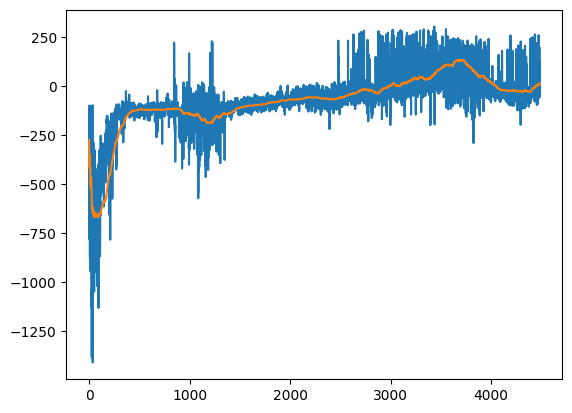

In [12]:
# Generate recent 150 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 150:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-149:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

## Testing
The testing result will be the average reward of 5 testing

In [ ]:
fix(env, seed)
agent.network.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)

  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing


In [ ]:
print(np.mean(test_total_reward))

Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

Saving the result of Model Testing


In [ ]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list))

### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

# Server
The code below simulate the environment on the judge server. Can be used for testing.

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:

      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
